In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator

Species: UAM502, 777 spectra eliminated out of 11342


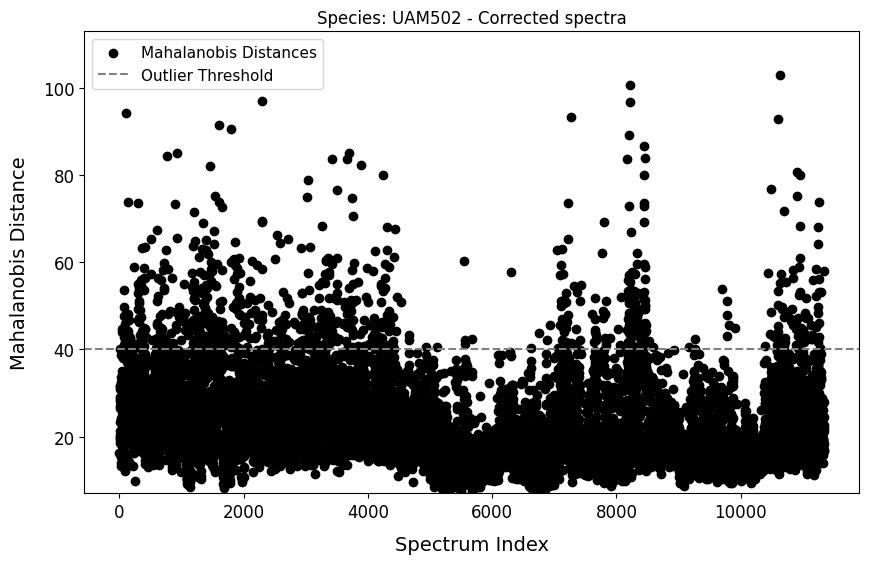

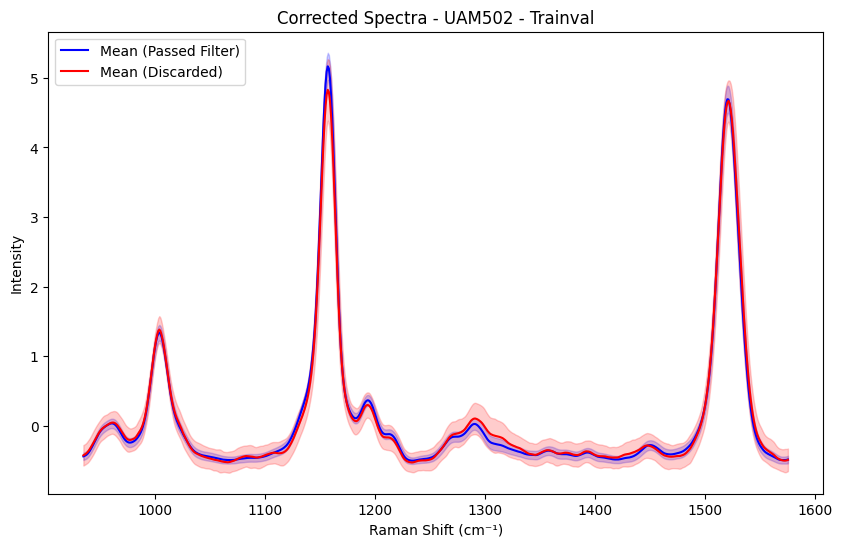

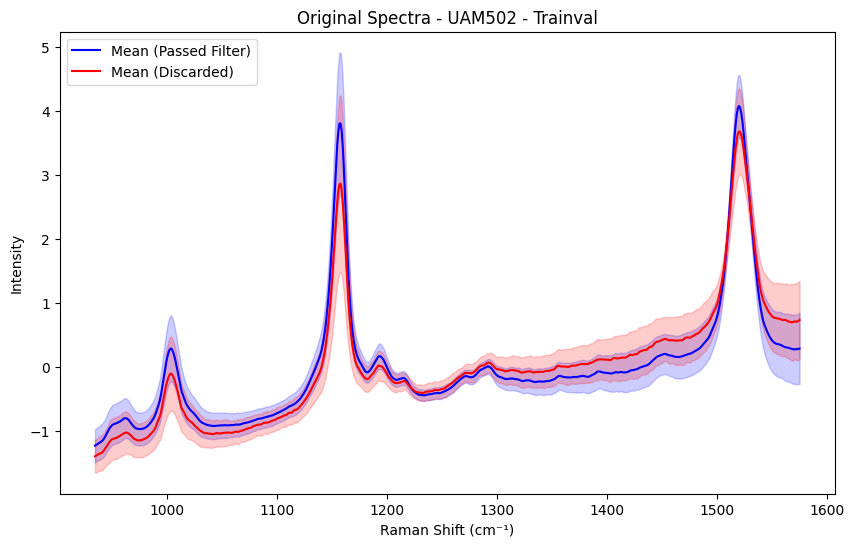

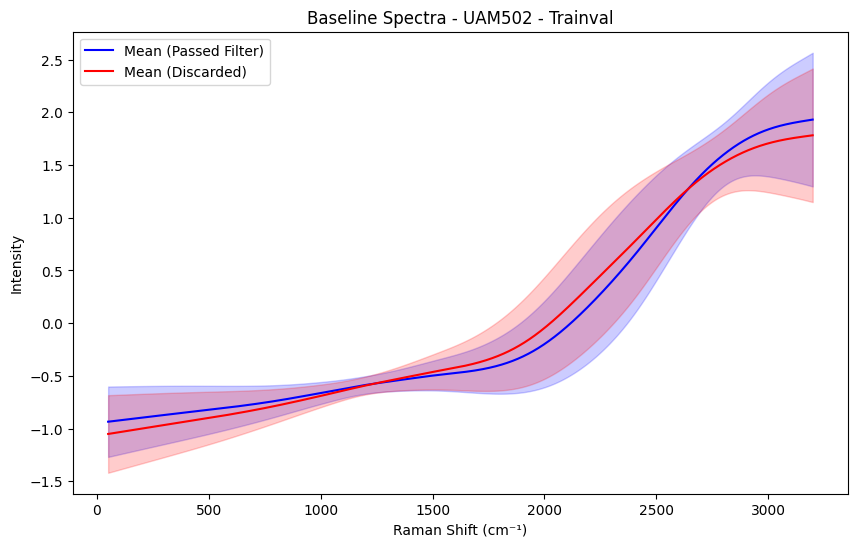

Species: UAM588, 774 spectra eliminated out of 10938


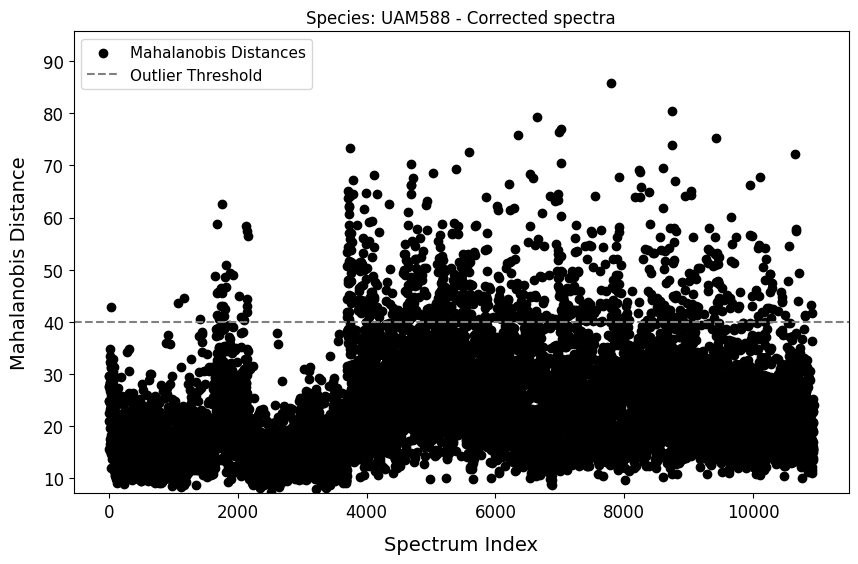

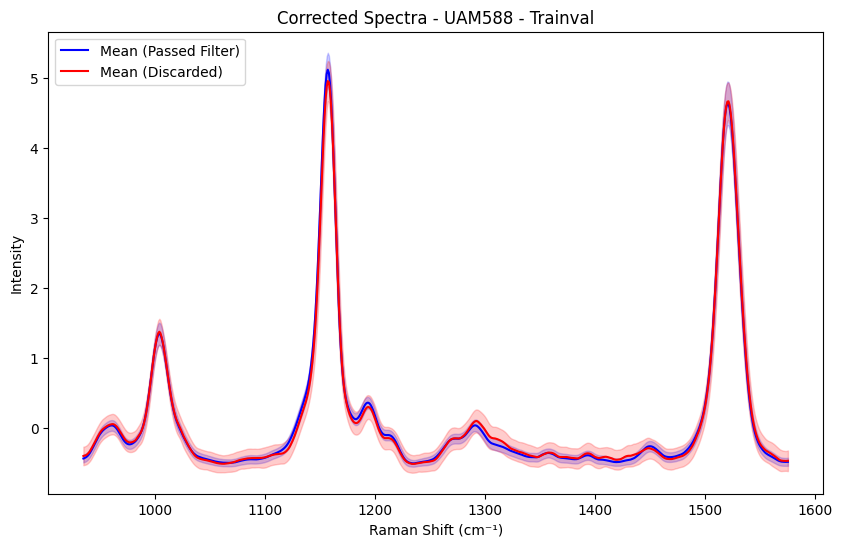

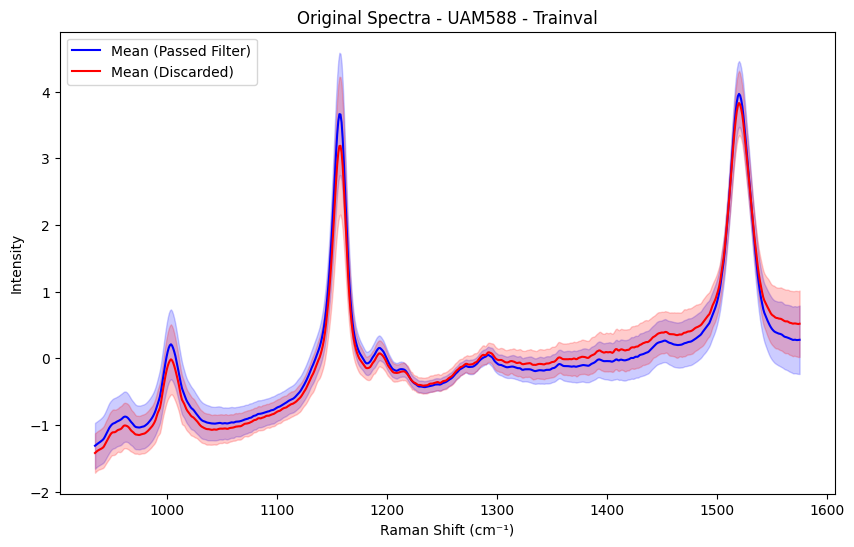

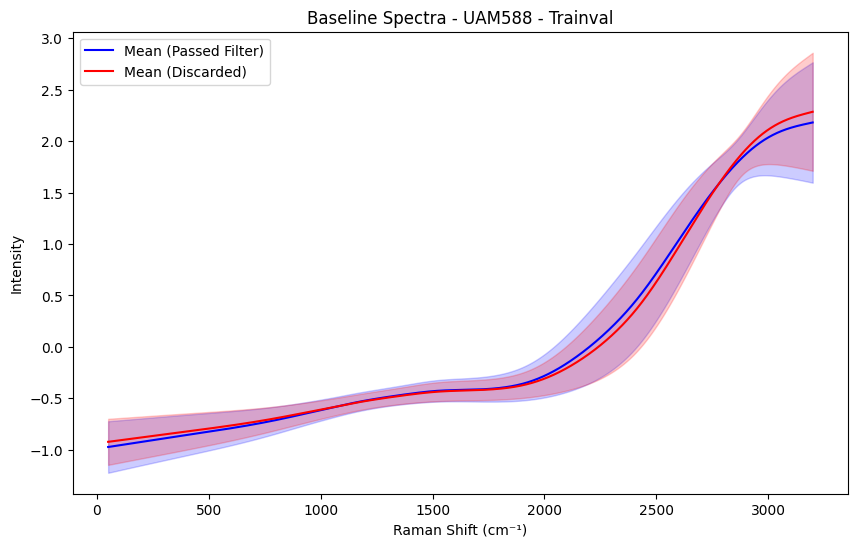

Species: UAM565, 700 spectra eliminated out of 9009


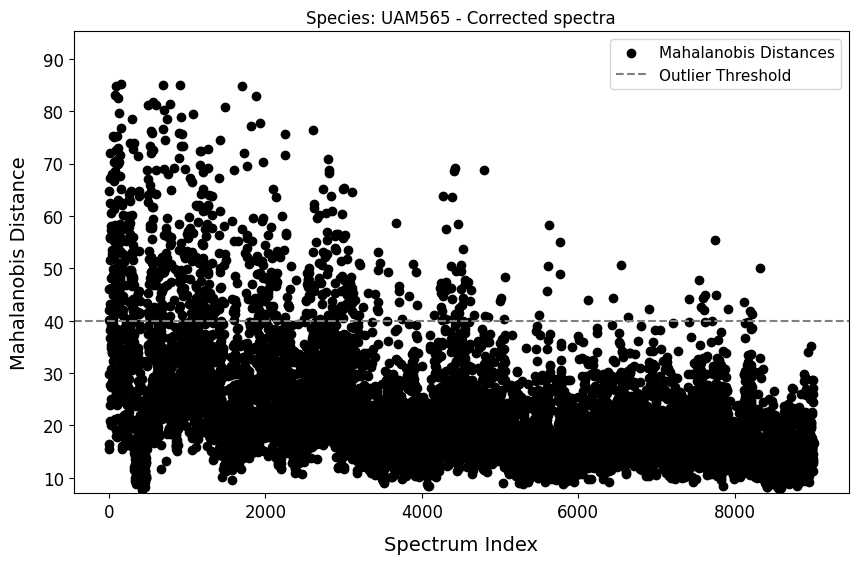

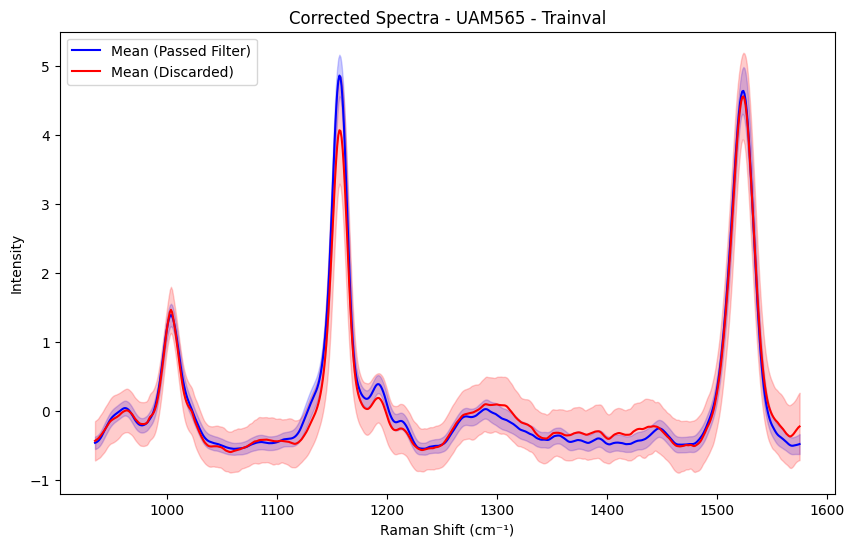

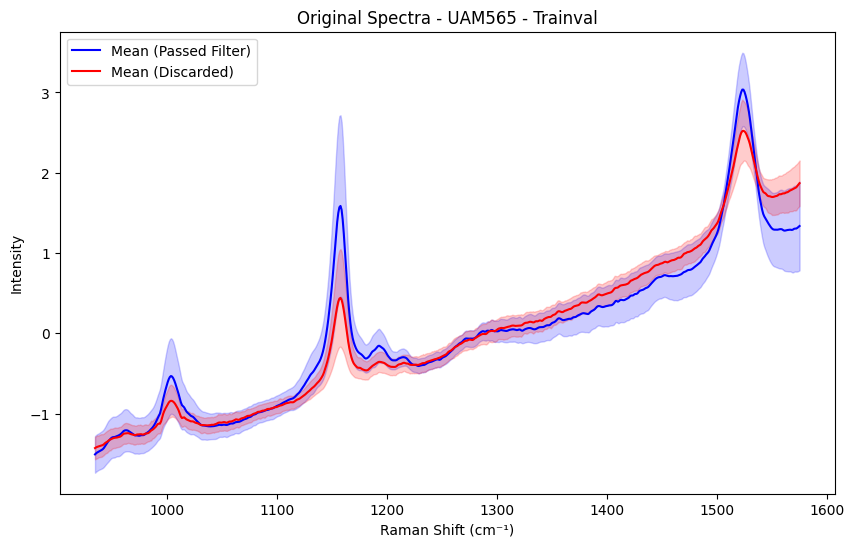

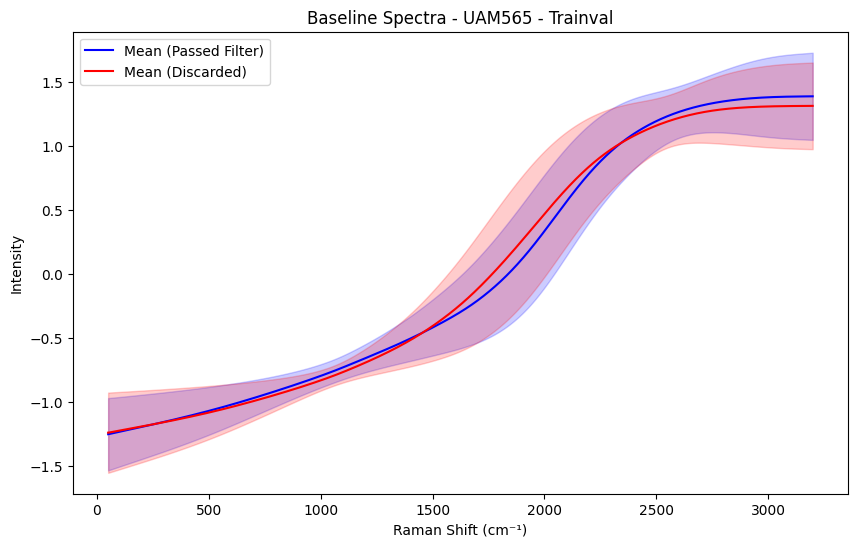

Species: UAM253, 297 spectra eliminated out of 8353


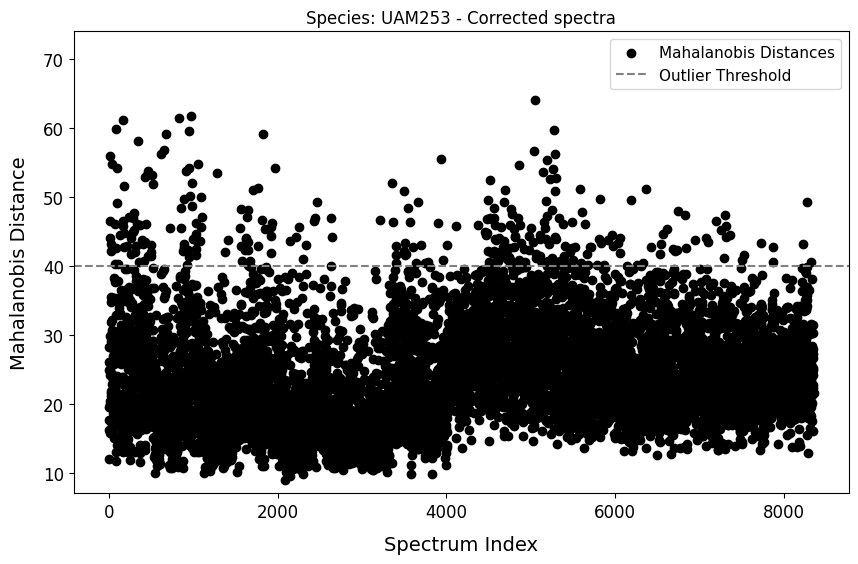

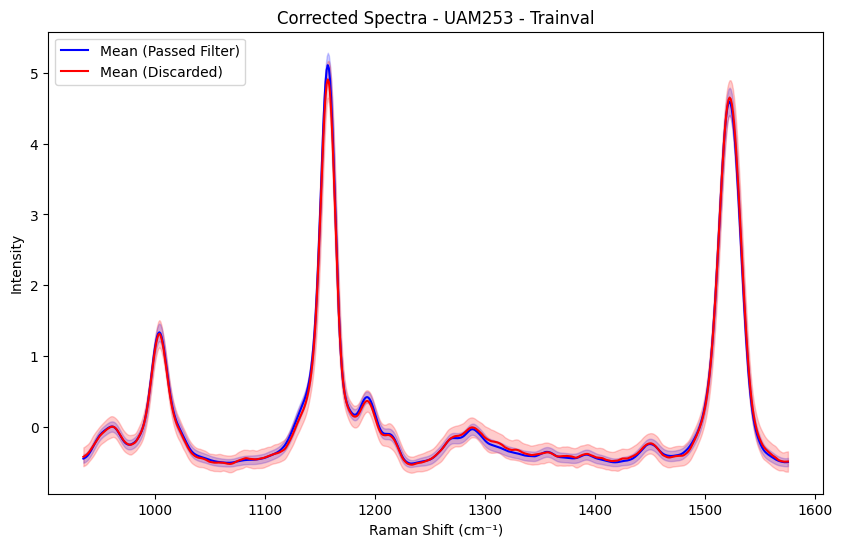

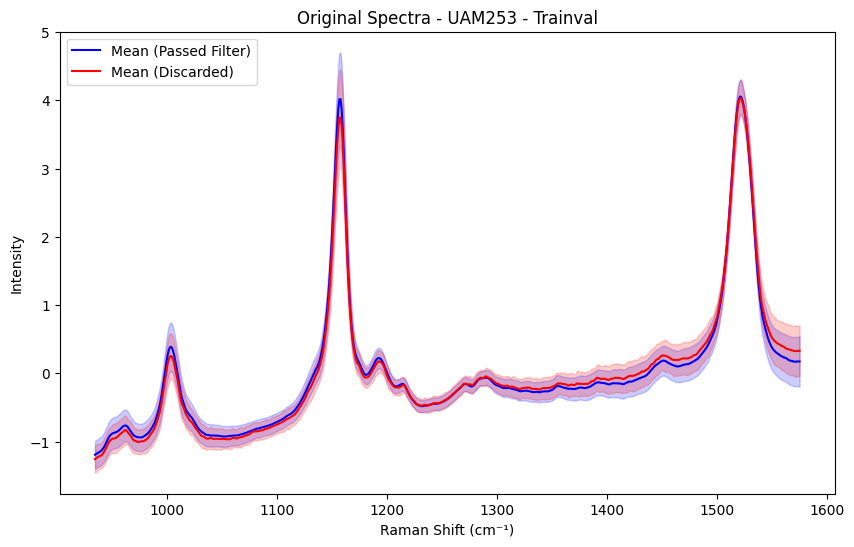

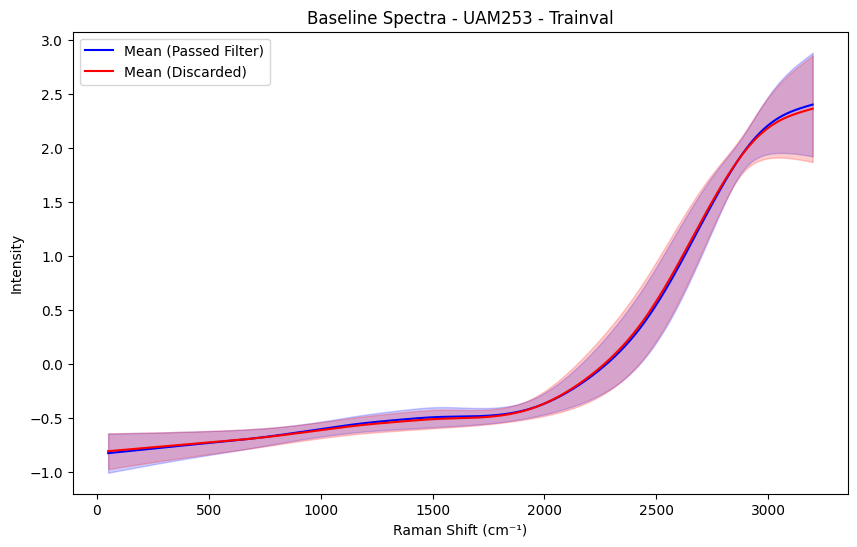

Species: charco, 17 spectra eliminated out of 3033


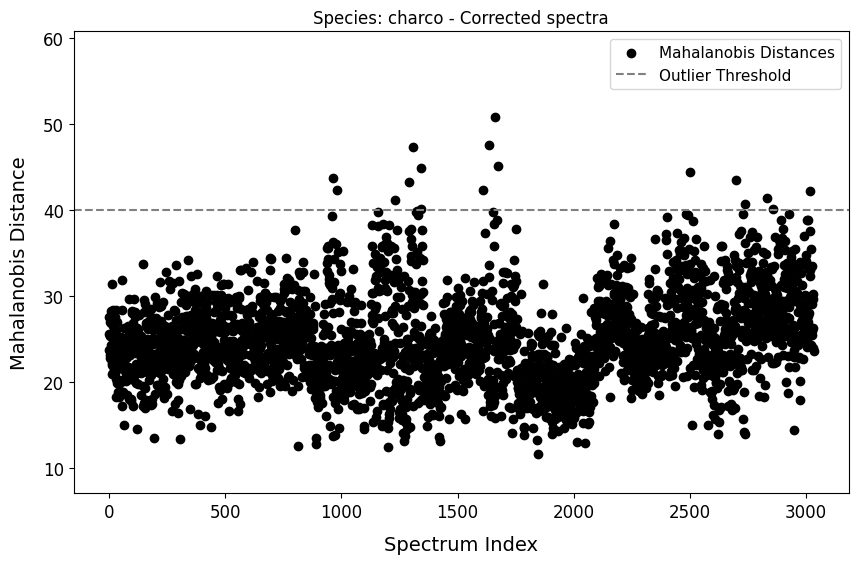

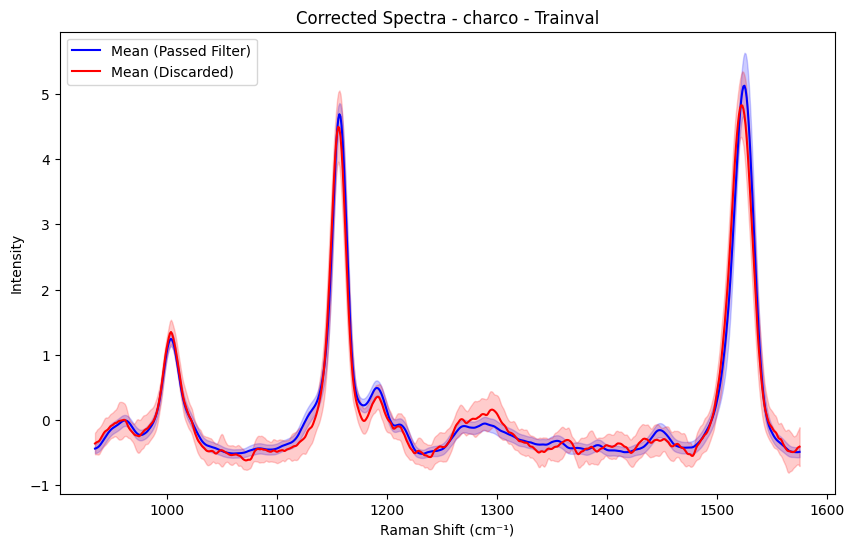

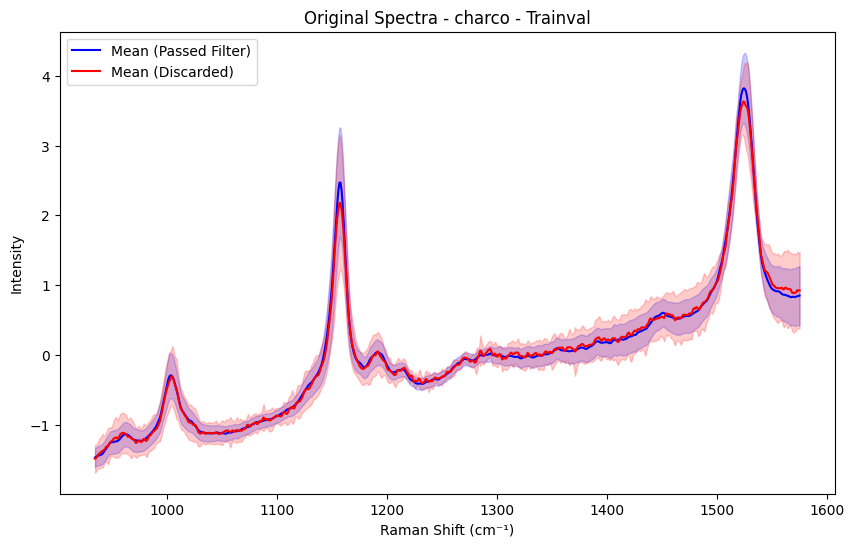

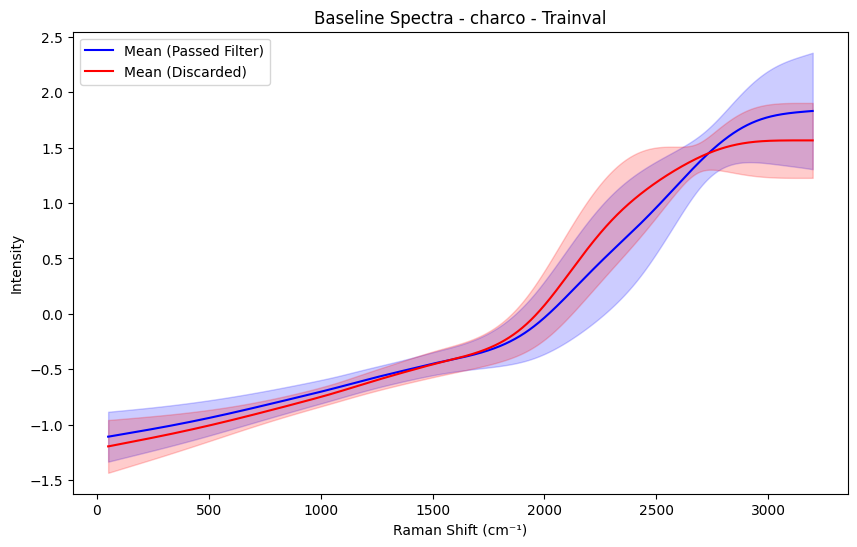

Filtering completed for trainval and test, and files saved.


In [12]:
# Function to plot the mean spectrum and standard deviation
def plot_mean_and_std(df_passed, df_outliers, title, raman_shifts):
    plt.figure(figsize=(10, 6))
    
    # Calculate the mean and standard deviation of spectra that pass the filter
    if not df_passed.empty:
        mean_passed = df_passed.mean(axis=0)
        std_passed = df_passed.std(axis=0)
        plt.plot(raman_shifts, mean_passed, color='blue', label='Mean (Passed Filter)')
        plt.fill_between(raman_shifts, mean_passed - std_passed, mean_passed + std_passed, color='blue', alpha=0.2)
    
    # Calculate the mean and standard deviation of discarded spectra
    if not df_outliers.empty:
        mean_outliers = df_outliers.mean(axis=0)
        std_outliers = df_outliers.std(axis=0)
        plt.plot(raman_shifts, mean_outliers, color='red', label='Mean (Discarded)')
        plt.fill_between(raman_shifts, mean_outliers - std_outliers, mean_outliers + std_outliers, color='red', alpha=0.2)

    plt.title(title)
    plt.xlabel("Raman Shift (cm⁻¹)")
    plt.ylabel("Intensity")
    plt.legend()
    plt.show()

# Function to compute the inverse covariance matrix and mean vector for a given species
def compute_mahalanobis_params(df, y, species):
    species_mask = (y == species)
    df_species = df[species_mask]
    
    # Exclude categorical columns to calculate Mahalanobis distance
    df_numeric = df_species.drop(columns=categorical_columns + coordinates_columns + names_column)
    
    # Calculate the covariance matrix and its inverse
    cov_matrix = np.cov(df_numeric.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Calculate the mean vector
    mean_vector = df_numeric.mean(axis=0)
    
    return inv_cov_matrix, mean_vector

# Function to apply the Mahalanobis filter to a DataFrame
def apply_mahalanobis_filter(df_trainval, inv_cov_matrix, mean_vector, threshold=40):
    df_trainval_numeric = df_trainval.drop(columns=categorical_columns + coordinates_columns + names_column)
    
    # Calculate the Mahalanobis distance for each spectrum in the trainval set
    mahalanobis_distances = df_trainval_numeric.apply(lambda row: distance.mahalanobis(row, mean_vector, inv_cov_matrix), axis=1)
    
    # Define the outlier threshold
    outliers_mask = mahalanobis_distances > threshold
    
    return outliers_mask, mahalanobis_distances

# Function to filter and plot the results (means and standard deviations)
def filter_and_plot(df, outliers_mask, raman_shifts, title):
    df_passed = df[~outliers_mask].drop(columns=categorical_columns + coordinates_columns + names_column)
    df_outliers = df[outliers_mask].drop(columns=categorical_columns + coordinates_columns + names_column)
    
    plot_mean_and_std(df_passed, df_outliers, title, raman_shifts)
    
    return df_passed, df_outliers

# Define categorical and coordinate columns
categorical_columns = ['date', 't_exp', 'especie', 'medium']
coordinates_columns = ['X', 'Y']
names_column = ['name']

# 1. Load trainval data
paths = [
       r'C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\especiesUAM_CORRECTED_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES.csv',
       r'C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\especiesUAM_ORIGINALES_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES.csv',
       r'C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\especiesUAM_BASELINES_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES.csv'
]

df = pd.read_csv(paths[0])
df_originals = pd.read_csv(paths[1])
df_baselines = pd.read_csv(paths[2])

# Define the Raman shift ranges
raman_shifts_corrected = np.arange(935, 1576, 1)  # For corrected and originals
raman_shifts_baselines = np.arange(50, 3200, 1)  # For baselines

# 2. Apply the Mahalanobis filter for each species in trainval
outliers_indices_trainval = []
params_by_species = {}

y_trainval = df['especie']  # Class labels (species)

for species in y_trainval.unique():
    inv_cov_matrix, mean_vector = compute_mahalanobis_params(df, y_trainval, species)
    params_by_species[species] = (inv_cov_matrix, mean_vector)
    
    # Filter only the data for the current species
    species_mask = (y_trainval == species)
    df_species = df[species_mask]
    df_species_originals = df_originals[species_mask]
    df_species_baselines = df_baselines[species_mask]
    
    # Apply Mahalanobis to this species for corrected
    outliers_mask_corrected, mahalanobis_distances_corrected = apply_mahalanobis_filter(df_species, inv_cov_matrix, mean_vector)

    # Count the discarded spectra for this species
    eliminated = outliers_mask_corrected.sum()
    total = len(outliers_mask_corrected)
    print(f"Species: {species}, {eliminated} spectra eliminated out of {total}")
    
    # Plot the Mahalanobis distances for this species in corrected
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(mahalanobis_distances_corrected)), mahalanobis_distances_corrected, c='black', label='Mahalanobis Distances')
    plt.axhline(y=40, color='grey', linestyle='--', label="Outlier Threshold")
    plt.title(f"Species: {species} - Corrected spectra", fontsize = 12)
    plt.xlabel("Spectrum Index", fontsize = 14, labelpad = 10)
    plt.ylabel("Mahalanobis Distance", fontsize = 14, labelpad = 10)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.ylim(7, max(mahalanobis_distances_corrected)+10)
    plt.legend(fontsize = 11)
    plt.show()

    # Filter and plot the means and standard deviations for corrected
    filter_and_plot(df_species, outliers_mask_corrected, raman_shifts_corrected, f"Corrected Spectra - {species} - trainval")

    # Filter and plot the means and standard deviations for originals and baselines by species
    filter_and_plot(df_species_originals, df_species_originals.index.isin(df_species.index[outliers_mask_corrected]), raman_shifts_corrected, f"Original Spectra - {species} - trainval")
    filter_and_plot(df_species_baselines, df_species_baselines.index.isin(df_species.index[outliers_mask_corrected]), raman_shifts_baselines, f"Baseline Spectra - {species} - trainval")

    # Store the indices of outliers
    outliers_indices_trainval.extend(df_species.index[outliers_mask_corrected])

# Remove outliers from all three trainval DataFrames using corrected indices
df_filtered = df.drop(outliers_indices_trainval)
df_originals_filtered = df_originals.drop(outliers_indices_trainval)
df_baselines_filtered = df_baselines.drop(outliers_indices_trainval)

# Save the filtered trainval DataFrames
'''df_filtered.to_csv(paths[0].replace('.csv', '_WITHOUTOUTLIERS.csv'), index=False)
df_originals_filtered.to_csv(paths[1].replace('.csv', '_WITHOUTOUTLIERS.csv'), index=False)
df_baselines_filtered.to_csv(paths[2].replace('.csv', '_WITHOUTOUTLIERS.csv'), index=False)'''

print("Filtering completed for trainval and trainval, and files saved.")




Species distribution before applying K-Means (test):
especie
UAM588    4021
UAM253    1634
UAM565    1414
UAM502     908
Name: count, dtype: int64


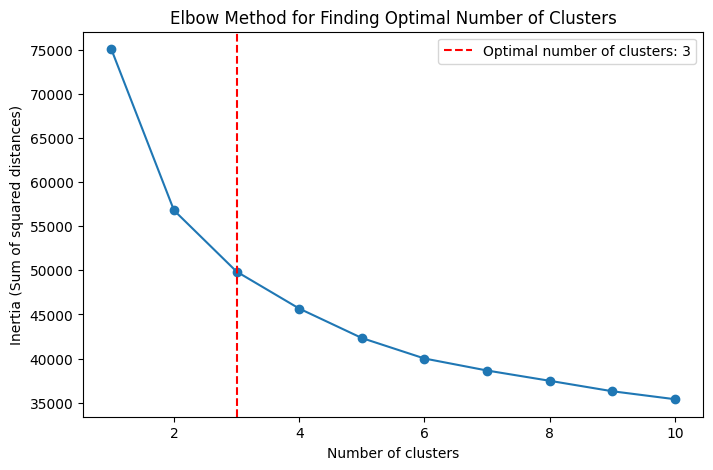

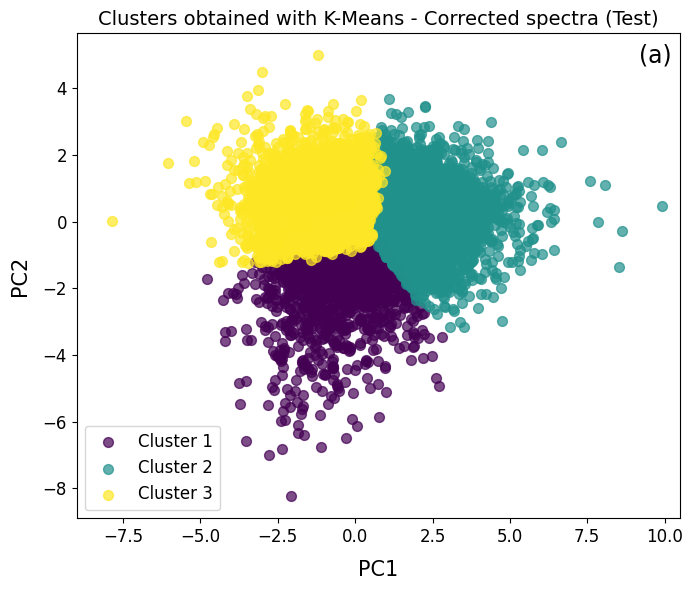

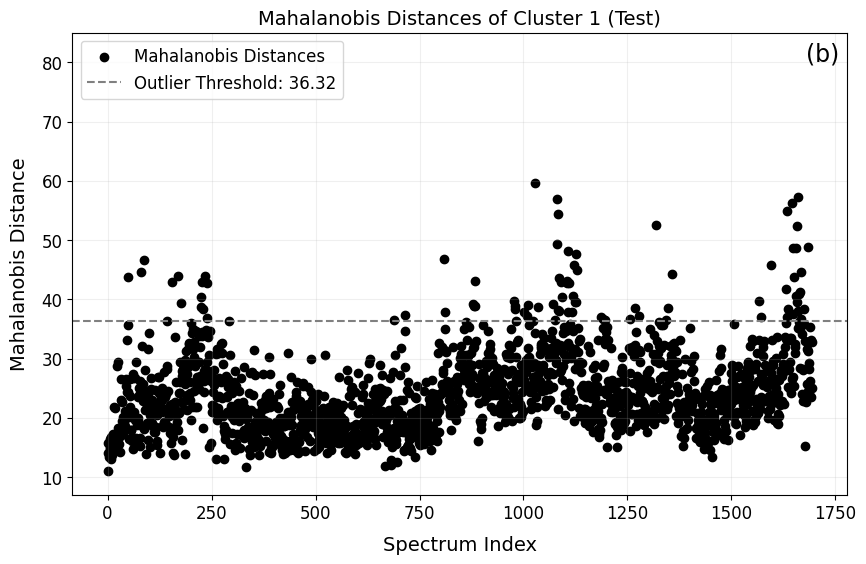

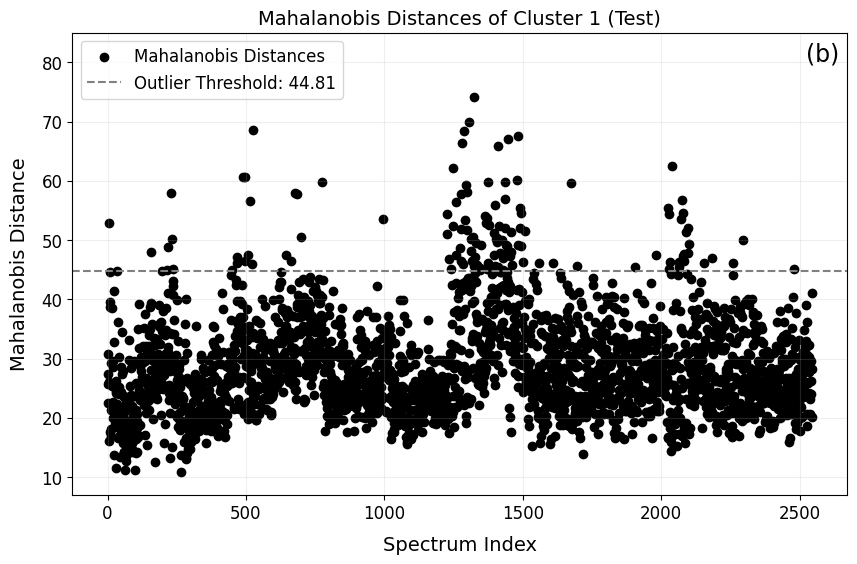

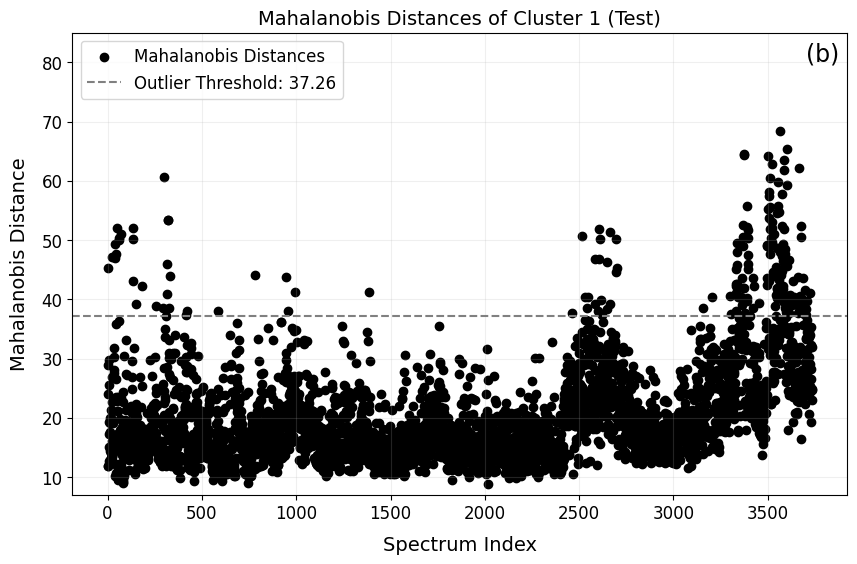

test filtering completed and files saved.


In [12]:

# Function to apply Mahalanobis and get outliers for each cluster
def apply_mahalanobis_filter_by_cluster(df, cluster_labels, inv_cov_matrix, mean_vector, cluster_num, percentile=90):
    cluster_mask = (cluster_labels == cluster_num)
    df_cluster = df[cluster_mask].drop(columns=categorical_columns + coordinates_columns + names_column)
    mahalanobis_distances = df_cluster.apply(lambda row: distance.mahalanobis(row, mean_vector, inv_cov_matrix), axis=1)
    threshold = np.percentile(mahalanobis_distances, percentile)
    outliers_mask = mahalanobis_distances > threshold
    return outliers_mask, mahalanobis_distances, threshold


def plot_mahalanobis_distances(mahalanobis_distances, threshold, output_name):
    """
    Plots Mahalanobis distances for a given dataset and highlights the threshold for outliers.
    
    Args:
        mahalanobis_distances (array-like): Array of Mahalanobis distances for each observation.
        threshold (float): The distance threshold to consider an observation as an outlier.
        title (str): The title of the plot.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(mahalanobis_distances)), mahalanobis_distances, c='black', label='Mahalanobis Distances')
    plt.axhline(y=threshold, color='grey', linestyle='--', label=f"Outlier Threshold: {threshold:.2f}")
    plt.xlabel("Spectrum Index", fontsize=14, labelpad=9)
    plt.ylabel("Mahalanobis Distance", fontsize=14, labelpad=9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title("Mahalanobis Distances of Cluster 1 (Test)", fontsize=14)
    plt.legend(loc='upper left', fontsize=12, facecolor='white')
    plt.grid(alpha=0.2)
    plt.ylim(7, 85)
    plt.text(0.947, 0.98, '(b)', transform=plt.gca().transAxes, fontsize=17, verticalalignment='top')

    plt.savefig(f"C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\mahalanobis\\{output_name}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\mahalanobis\\{output_name}.svg", bbox_inches='tight')
    plt.show()


# Function to find optimal number of clusters using the elbow method
def find_optimal_clusters(data, max_k=10):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    # Use kneed to automatically find the elbow point
    kneedle = KneeLocator(range(1, max_k + 1), inertia, curve="convex", direction="decreasing")
    optimal_k = kneedle.elbow

    # Plot the elbow method
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), inertia, marker='o')
    plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal number of clusters: {optimal_k}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia (Sum of squared distances)')
    plt.title('Elbow Method for Finding Optimal Number of Clusters')
    plt.legend()
    plt.show()
    
    return optimal_k

# Function to apply K-Means and get clusters
def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    return clusters

# Function to reduce dimensionality with PCA (for visualization)
def reduce_dimensionality_with_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    return reduced_data


def compute_global_mahalanobis_params(df):
    df_numeric = df.drop(columns=categorical_columns + coordinates_columns + names_column)
    cov_matrix = np.cov(df_numeric.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean_vector = df_numeric.mean(axis=0)
    
    return inv_cov_matrix, mean_vector


# Define categorical and coordinate columns
categorical_columns = ['date', 't_exp', 'especie', 'medium']
coordinates_columns = ['X', 'Y']
names_column = ['name']

# 1. Load test data
paths = [
    r'C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\especiesUAM_UNSEENS_CORRECTED_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES.csv',
    r'C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\especiesUAM_UNSEENS_ORIGINALES_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES.csv',
    r'C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\especiesUAM_UNSEENS_BASELINES_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES.csv'
]

# Load datasets and exclude unwanted class
test_corrected = pd.read_csv(paths[0])
test_corrected = test_corrected[test_corrected['especie'] != 'charco']
test_originals = pd.read_csv(paths[1])
test_originals = test_originals[test_originals['especie'] != 'charco']
test_baselines = pd.read_csv(paths[2])
test_baselines = test_baselines[test_baselines['especie'] != 'charco']

# Print species distribution before filtering
print("Species distribution before applying K-Means (test):")
print(test_corrected['especie'].value_counts())

# Define Raman shift ranges
raman_shifts_corrected = np.arange(935, 1576, 1)  # For corrected and originals
raman_shifts_baselines = np.arange(50, 3200, 1)  # For baselines

# 2. Apply K-Means to test data
test_numeric = test_corrected.drop(columns=categorical_columns + coordinates_columns + names_column)
n_clusters = find_optimal_clusters(test_numeric, max_k=10)
clusters_test = apply_kmeans(test_numeric, n_clusters=n_clusters)

# Visualize clusters in 2D (test)
reduced_data_test = reduce_dimensionality_with_pca(test_numeric, n_components=2)


# Create the plot
plt.figure(figsize=(7, 6))

# Reduce dimensionality for visualization
reduced_data_corrected = reduce_dimensionality_with_pca(test_numeric.values, n_components=2)
# Get unique clusters and generate colors using the viridis colormap
unique_clusters = np.unique(clusters_test)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Scatter plot for each cluster using the colors from viridis
for cluster, color in zip(unique_clusters, colors):
    cluster_mask = (clusters_test == cluster)
    plt.scatter(
        reduced_data_corrected[cluster_mask, 0],
        reduced_data_corrected[cluster_mask, 1],
        c=[color],
        label=f'Cluster {cluster + 1}',  # Cluster numbering starts from 1
        s=50,
        alpha=0.7
    )

# Add labels and legend
plt.xlabel('PC1', fontsize=15, labelpad=10)
plt.ylabel('PC2', fontsize=15, labelpad=9)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f"Clusters obtained with K-Means - Corrected spectra (Test)", fontsize=14)
plt.legend(fontsize=12, loc='lower left', frameon=True)
plt.text(0.9325, 0.98, '(a)', transform=plt.gca().transAxes, fontsize=17, verticalalignment='top')
plt.tight_layout()
plt.xlim(-9, 10.5)
#plt.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figS2\\figS2a_Kmeans_clusters.svg', format='svg', bbox_inches='tight', dpi =300)
#plt.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figS2\\figS2a_Kmeans_clusters.png', format='png', bbox_inches='tight', dpi =300)
plt.show()


# 3. Apply Mahalanobis filtering by cluster in test data
outliers_indices_test = []
inv_cov_matrix_global, mean_vector_global = compute_global_mahalanobis_params(test_corrected)

for cluster_num in range(n_clusters):
    outliers_mask, mahalanobis_distances, threshold = apply_mahalanobis_filter_by_cluster(
        test_corrected, clusters_test, inv_cov_matrix_global, mean_vector_global, cluster_num, percentile=95)

    # Plot Mahalanobis distances
    plot_mahalanobis_distances(mahalanobis_distances, threshold, f"Mahalanobis Distances of Cluster {cluster_num} (Test)")

    # Filter and plot spectra averages and standard deviations
    cluster_data_corrected = test_corrected[clusters_test == cluster_num]
    filter_and_plot(cluster_data_corrected, outliers_mask, raman_shifts_corrected, f"Corrected Spectra - Cluster {cluster_num} - test")

    cluster_data_originals = test_originals[clusters_test == cluster_num]
    cluster_data_baselines = test_baselines[clusters_test == cluster_num]

    filter_and_plot(cluster_data_originals, outliers_mask, raman_shifts_corrected, f"Original Spectra - Cluster {cluster_num} - test")
    filter_and_plot(cluster_data_baselines, outliers_mask, raman_shifts_baselines, f"Baseline Spectra - Cluster {cluster_num} - test")

    # Store outlier indices
    outliers_indices_test.extend(cluster_data_corrected.index[outliers_mask])

# Remove outliers from test data
test_corrected_filtered = test_corrected.drop(outliers_indices_test)
test_originals_filtered = test_originals.drop(outliers_indices_test)
test_baselines_filtered = test_baselines.drop(outliers_indices_test)

'''test_corrected_filtered.to_csv(paths[0].replace('.csv', '_WITHOUTOUTLIERS_kmeans.csv'), index=False)
test_originals_filtered.to_csv(paths[1].replace('.csv', '_WITHOUTOUTLIERS_kmeans.csv'), index=False)
test_baselines_filtered.to_csv(paths[2].replace('.csv', '_WITHOUTOUTLIERS_kmeans.csv'), index=False)'''

print("test filtering completed and files saved.")




Procesando archivo: 031024_UAM253_500ms_1acc_pwcas1_5um_1
Válidos: 37, Outliers: 7


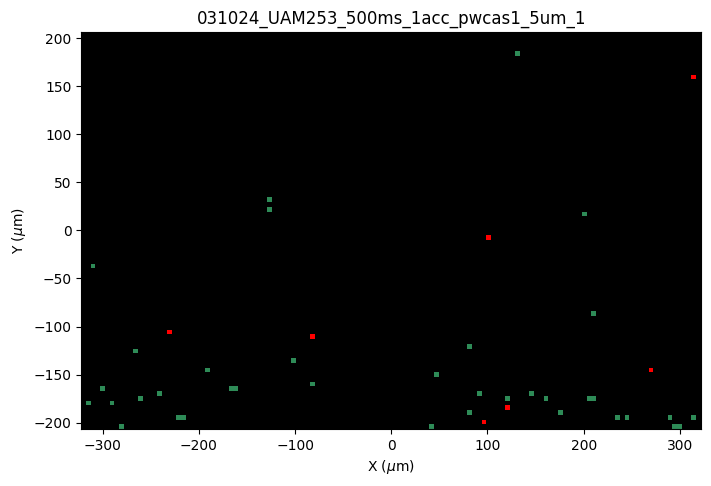


Procesando archivo: 041024_UAM253_500ms_1acc_pwcas1_5um_2
Válidos: 47, Outliers: 2


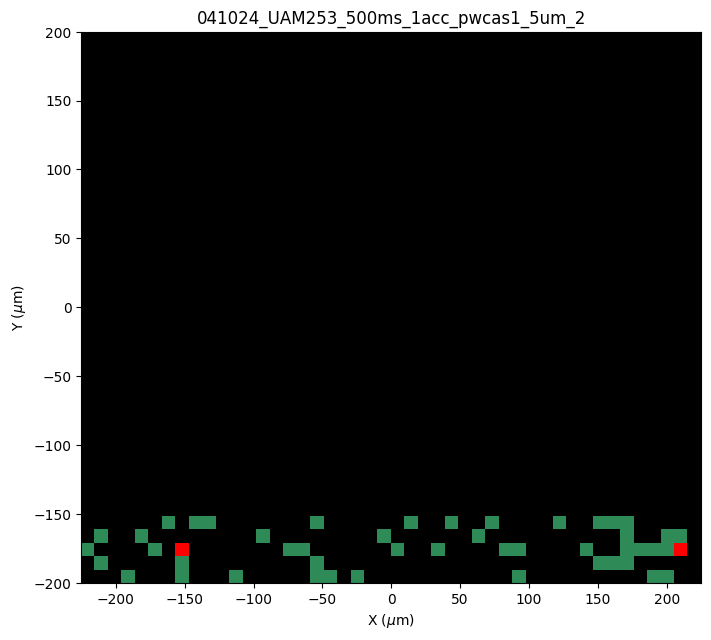


Procesando archivo: 041024_UAM253_500ms_1acc_pwras_5um_1
Válidos: 400, Outliers: 6


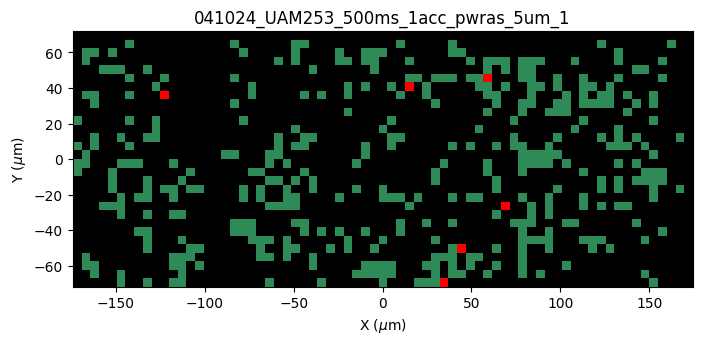


Procesando archivo: 041024_UAM253_500ms_1acc_pwras_5um_3
Válidos: 1956, Outliers: 53


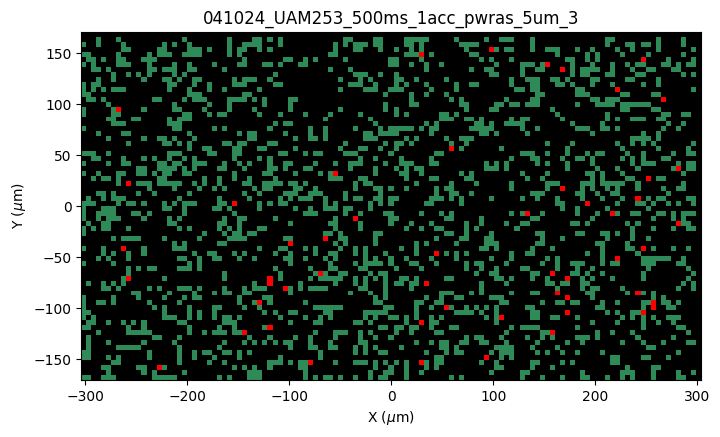


Procesando archivo: 060624_UAM502_300ms_1acc_pwras_5um
Válidos: 146, Outliers: 9


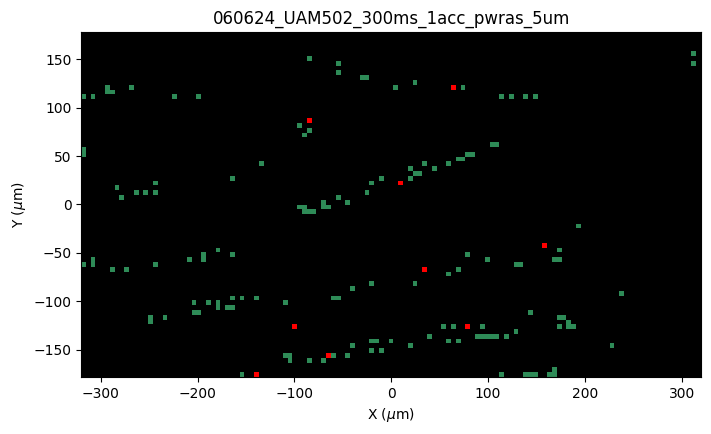


Procesando archivo: 060824_charco_500ms_1acc_pwras_5um_1
Válidos: 75, Outliers: 0


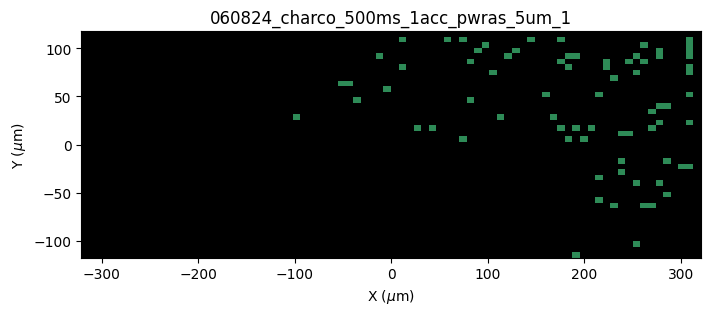


Procesando archivo: 060824_charco_500ms_1acc_pwras_5um_2
Válidos: 259, Outliers: 0


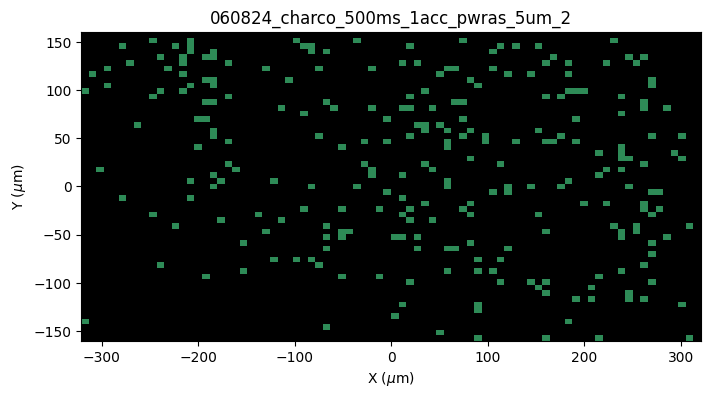


Procesando archivo: 070824_charco_700ms_1acc_pwcasiras_1
Válidos: 829, Outliers: 6


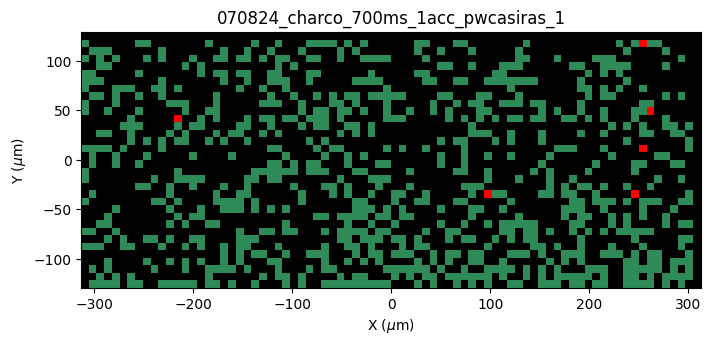


Procesando archivo: 070824_charco_700ms_1acc_pwcasiras_2
Válidos: 109, Outliers: 0


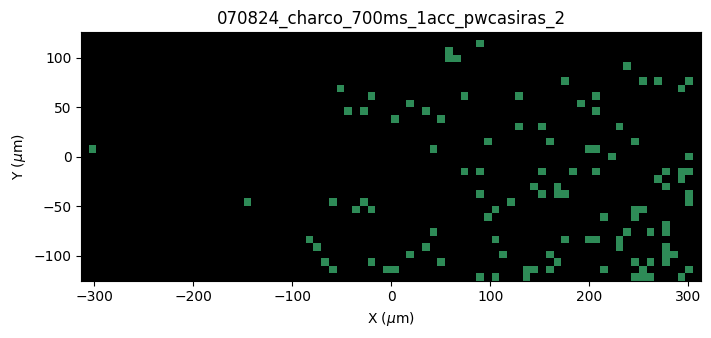


Procesando archivo: 080724_UAM588_1s_1acc_5um_pwcasiras
Válidos: 191, Outliers: 0


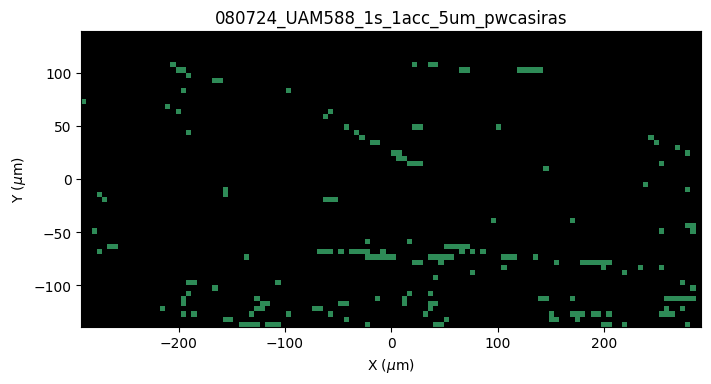


Procesando archivo: 080824_UAM565_500ms_1acc_pwmuesca1_2um_2_largo
Válidos: 795, Outliers: 375


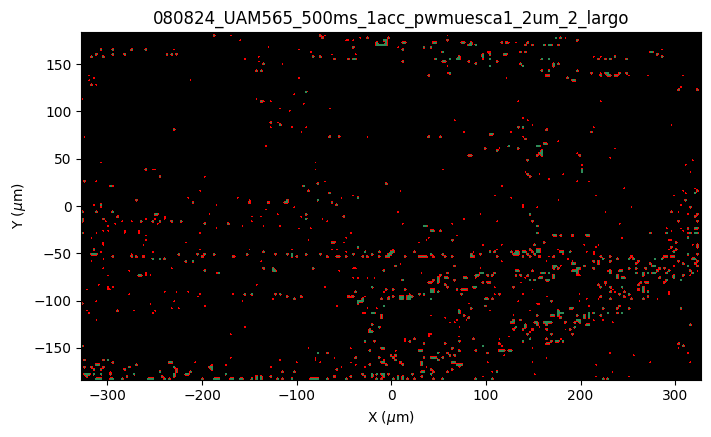


Procesando archivo: 080824_UAM565_700ms_1acc_pwmuesca1_6um_1
Válidos: 48, Outliers: 0


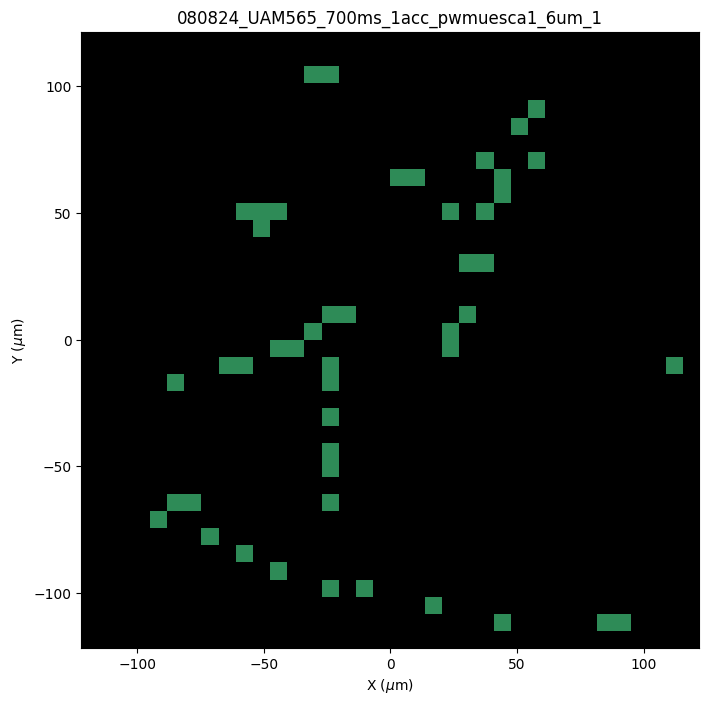


Procesando archivo: 080824_UAM565_700ms_1acc_pwmuesca1_6um_2
Válidos: 4, Outliers: 0


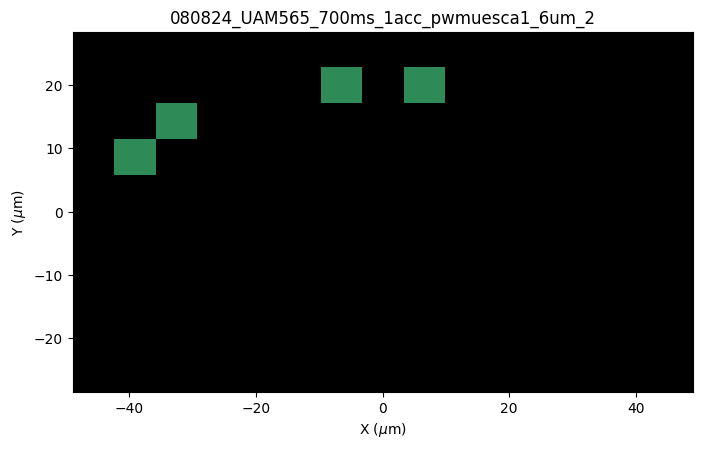


Procesando archivo: 080824_UAM565_700ms_1acc_pwmuesca1_6um_3
Válidos: 41, Outliers: 0


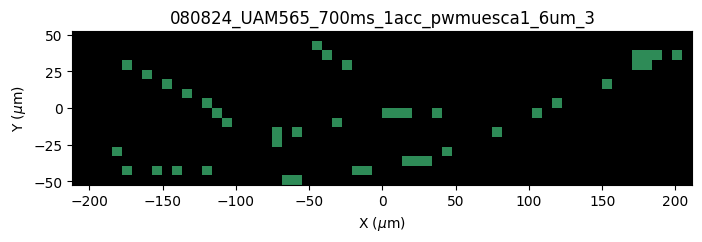


Procesando archivo: 080824_UAM565_700ms_1acc_pwmuesca1_6um_4
Válidos: 28, Outliers: 0


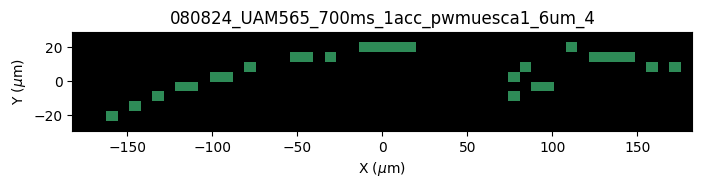


Procesando archivo: 090723_UAM588_500ms_1acc_pwcasi1_5um
Válidos: 1169, Outliers: 2


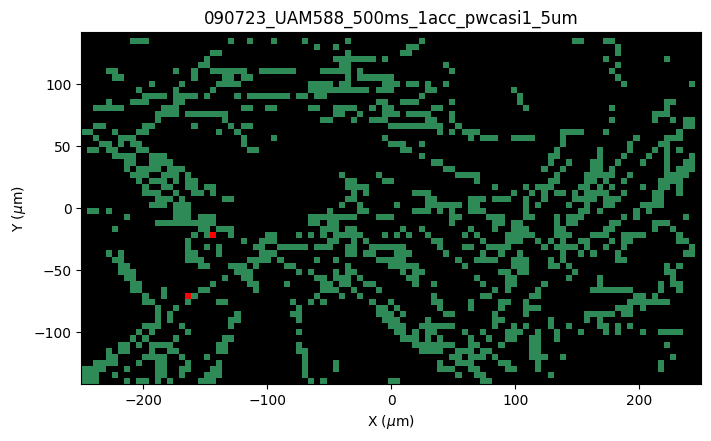


Procesando archivo: 090724_UAM588_1s_2acc_3um_pwcasiras
Válidos: 229, Outliers: 0


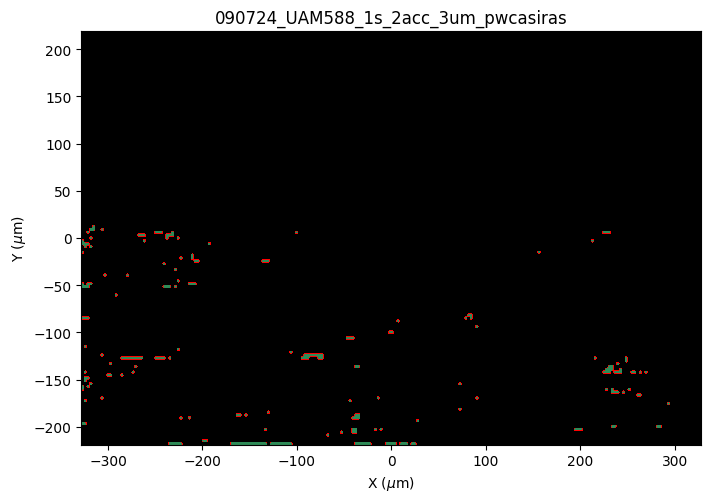


Procesando archivo: 090724_UAM588_500ms_1acc_5um_pwcasi1
Válidos: 357, Outliers: 0


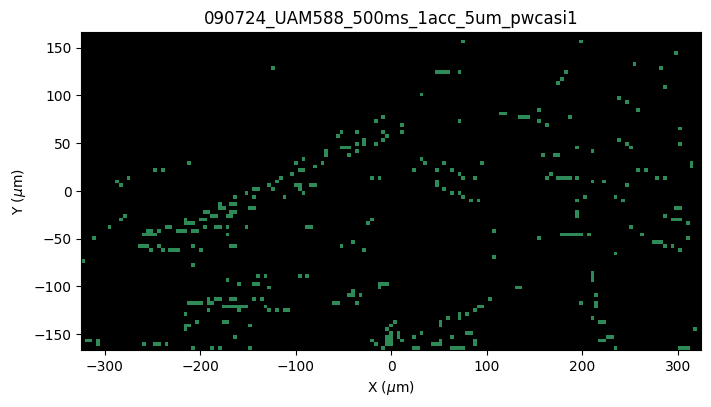


Procesando archivo: 090824_UAM565_300ms_1acc_pwmuescacasi1_5um_1
Válidos: 234, Outliers: 3


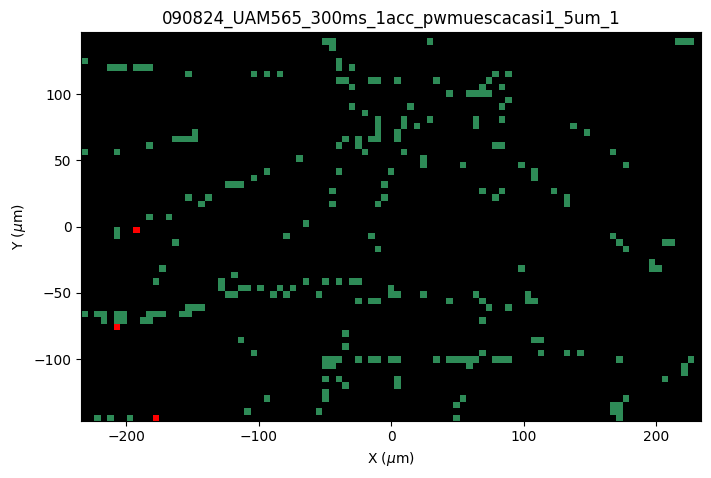


Procesando archivo: 090824_UAM565_500ms_1acc_pwcasiras_5um_1
Válidos: 56, Outliers: 11


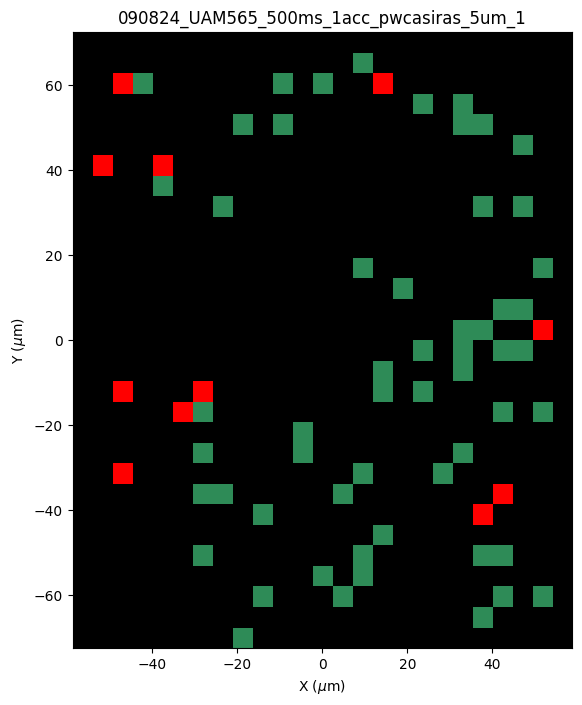


Procesando archivo: 090824_UAM565_500ms_1acc_pwcasiras_5um_2
Válidos: 206, Outliers: 39


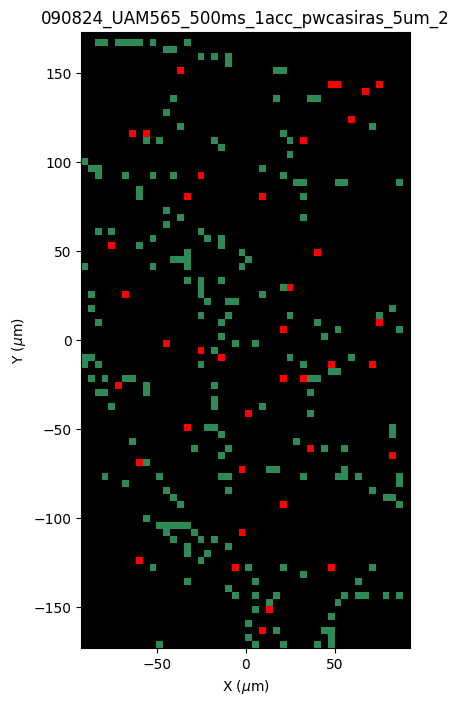


Procesando archivo: 090824_UAM565_500ms_1acc_pwcasiras_5um_3
Válidos: 219, Outliers: 37


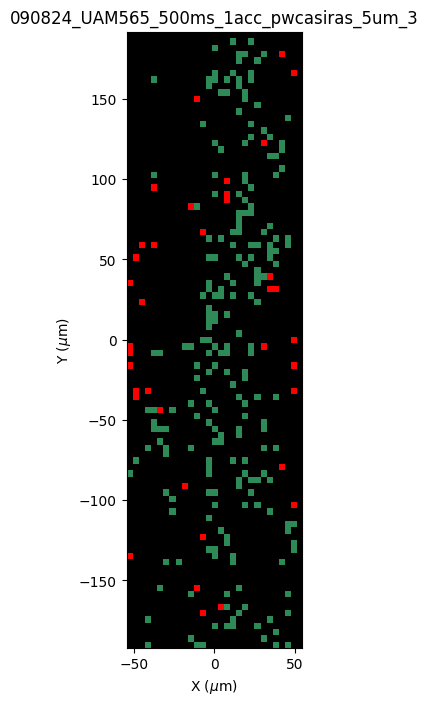


Procesando archivo: 090824_UAM565_500ms_1acc_pwmuescacasi1_5um_1
Válidos: 170, Outliers: 3


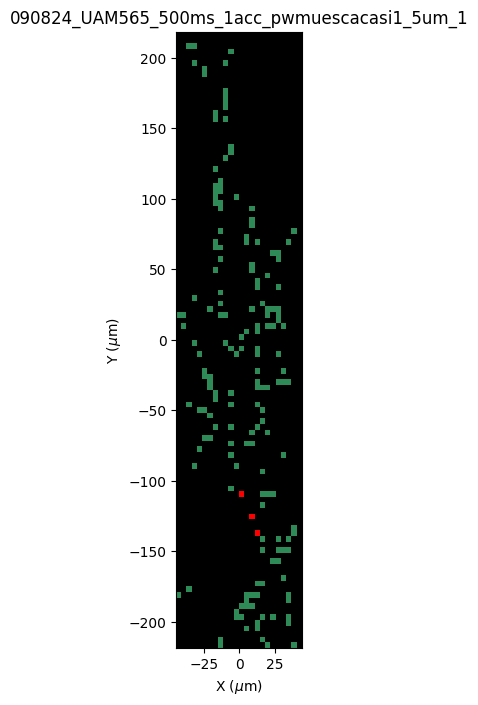


Procesando archivo: 090824_UAM565_500ms_1acc_pwmuescacasi1_5um_2
Válidos: 123, Outliers: 24


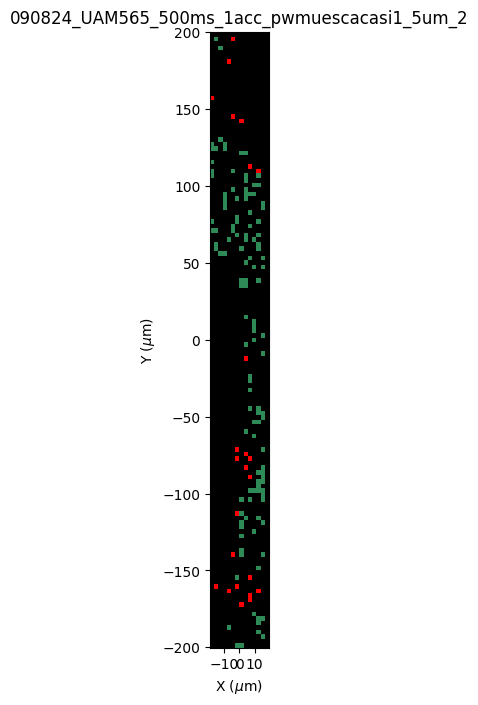


Procesando archivo: 090824_UAM565_700ms_1acc_pwmuescacasi1_5um_1
Válidos: 196, Outliers: 49


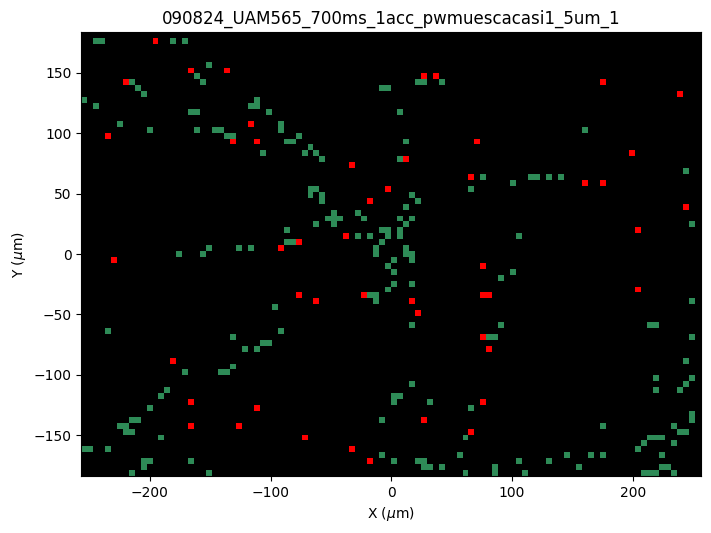


Procesando archivo: 090824_UAM565_700ms_1acc_pwmuescacasi1_5um_2
Válidos: 237, Outliers: 33


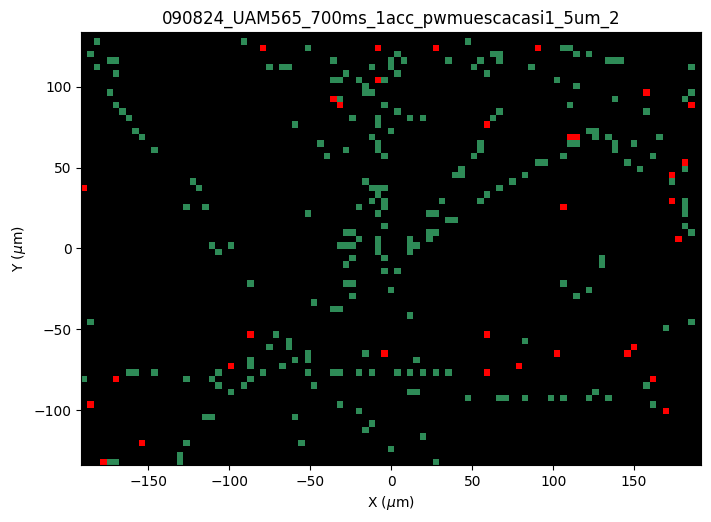


Procesando archivo: 091024_UAM253_500ms_1acc_pwras_1
Válidos: 173, Outliers: 0


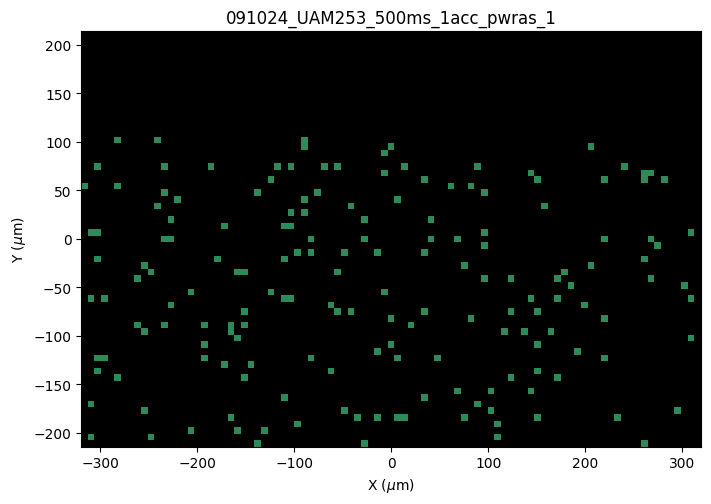


Procesando archivo: 091024_UAM253_500ms_1acc_pwras_2
Válidos: 53, Outliers: 1


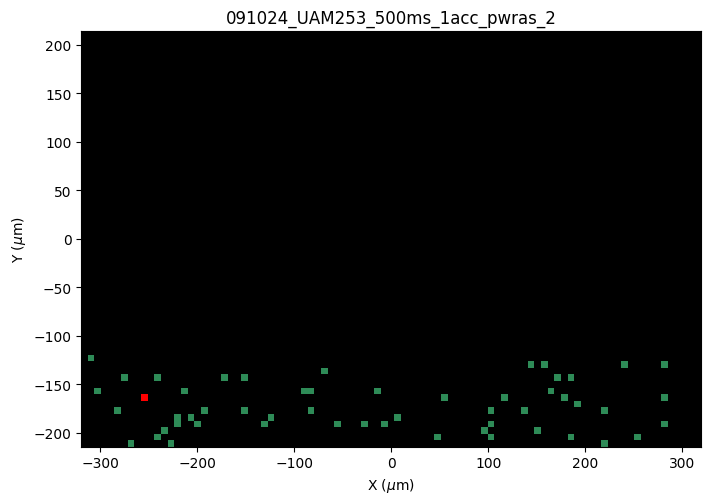


Procesando archivo: 091024_UAM253_500ms_1acc_pwras_3
Válidos: 102, Outliers: 4


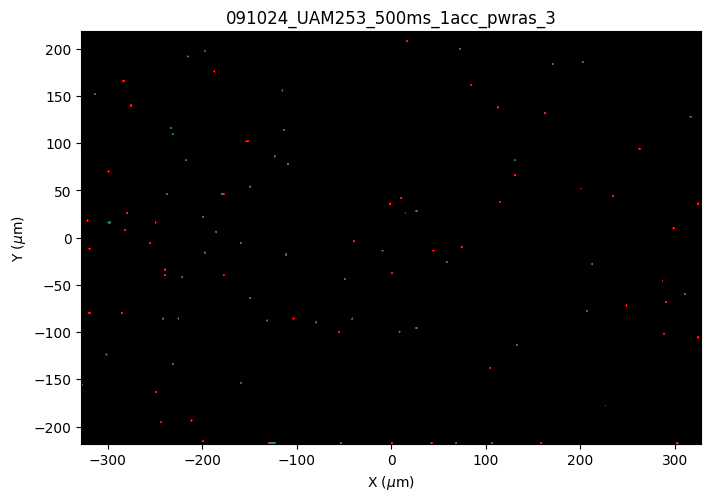


Procesando archivo: 091024_UAM253_500ms_1acc_pwras_4
Válidos: 83, Outliers: 0


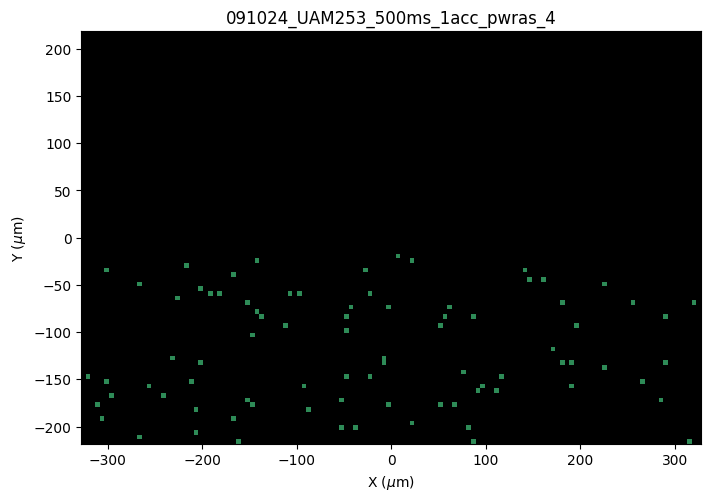


Procesando archivo: 091024_UAM253_500ms_1acc_pwras_5
Válidos: 158, Outliers: 0


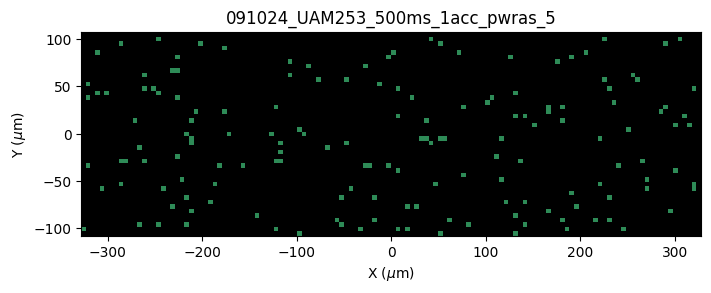


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_1
Válidos: 23, Outliers: 2


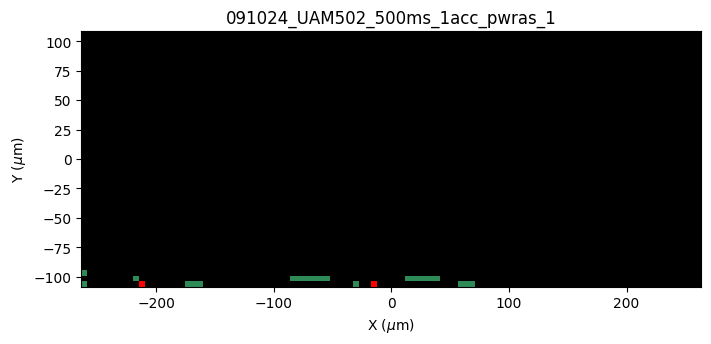


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_10
Válidos: 53, Outliers: 8


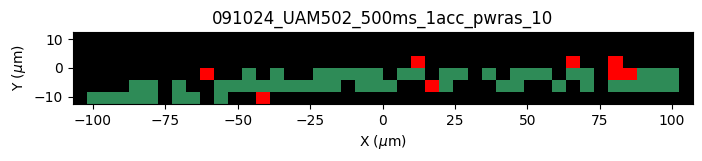


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_11
Válidos: 48, Outliers: 3


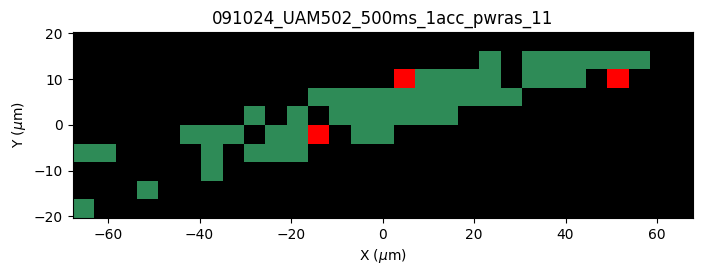


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_12
Válidos: 44, Outliers: 3


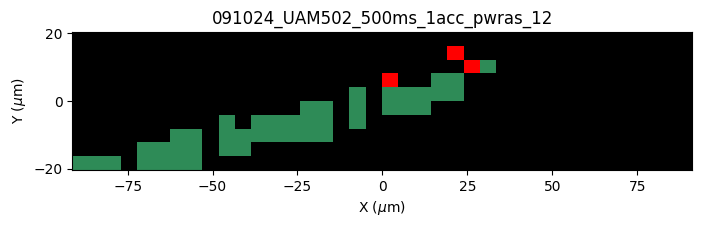


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_13
Válidos: 20, Outliers: 3


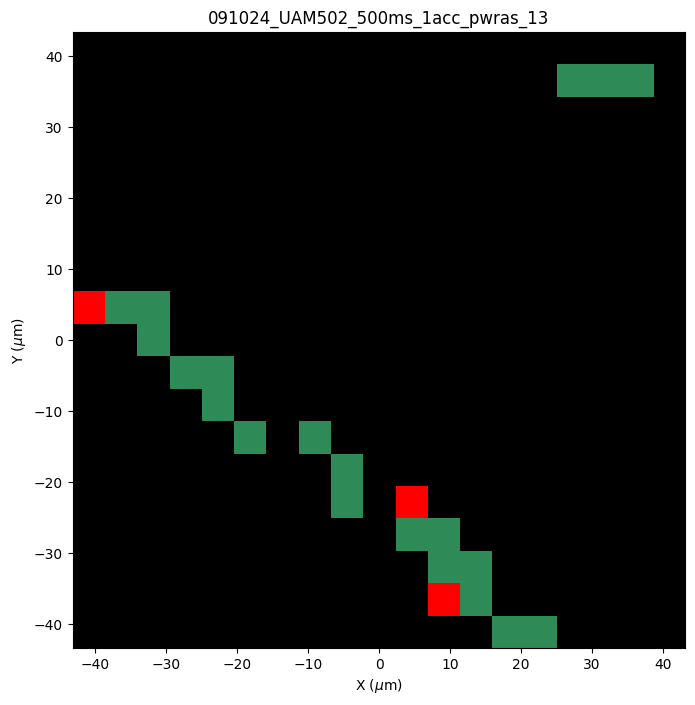


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_14
Válidos: 19, Outliers: 0


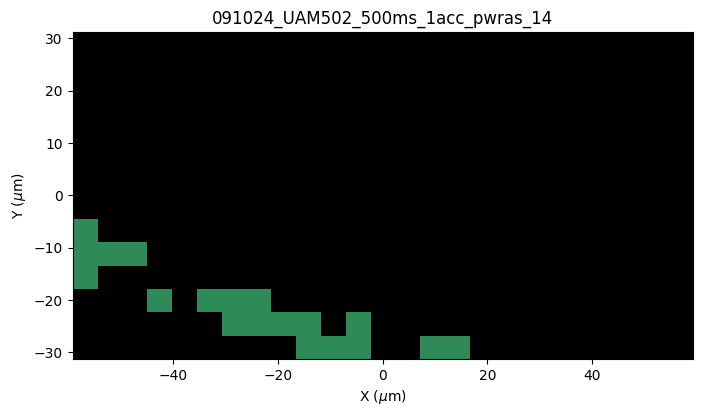


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_15
Válidos: 16, Outliers: 0


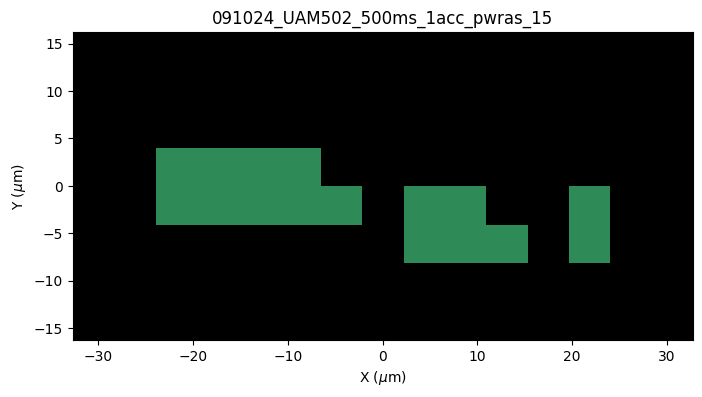


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_16
Válidos: 19, Outliers: 0


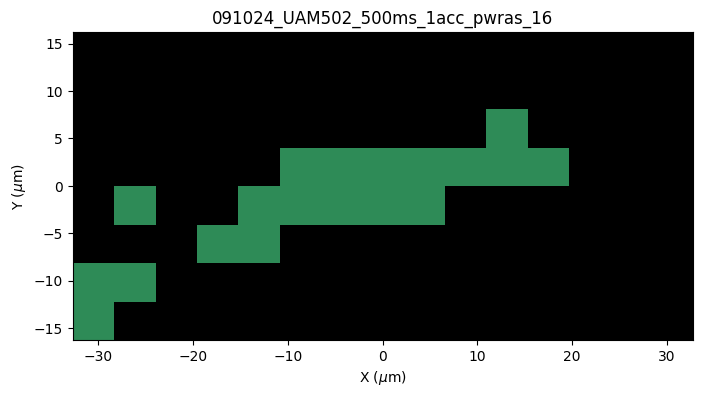


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_17
Válidos: 56, Outliers: 3


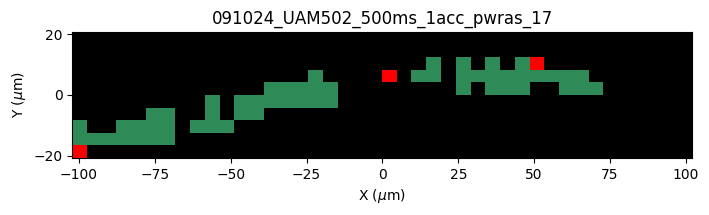


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_18
Válidos: 96, Outliers: 3


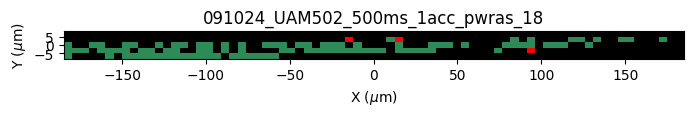


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_19
Válidos: 59, Outliers: 5


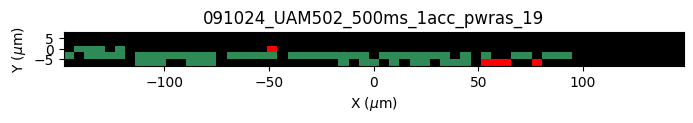


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_2
Válidos: 105, Outliers: 5


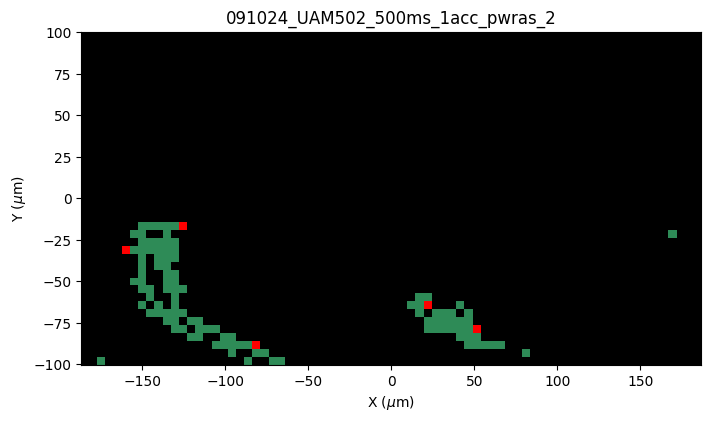


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_20
Válidos: 66, Outliers: 2


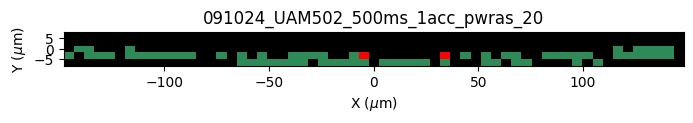


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_3
Válidos: 11, Outliers: 1


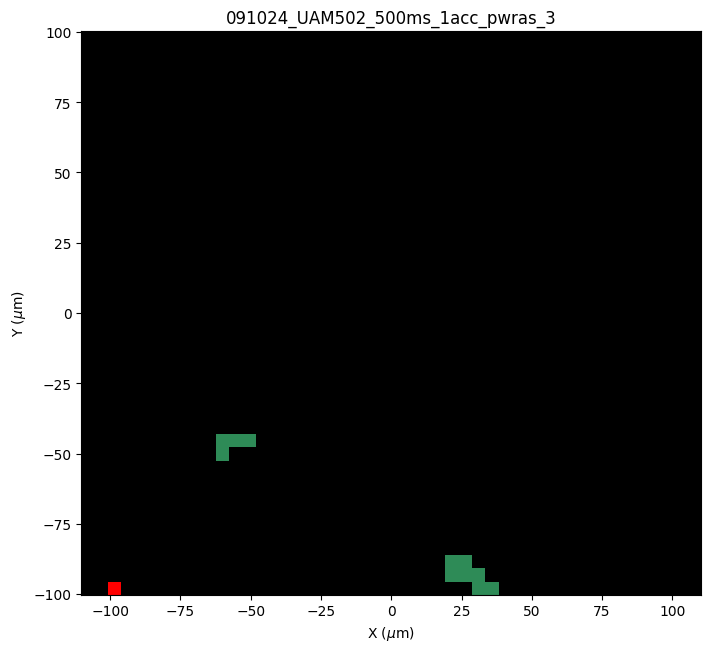


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_4
Válidos: 22, Outliers: 11


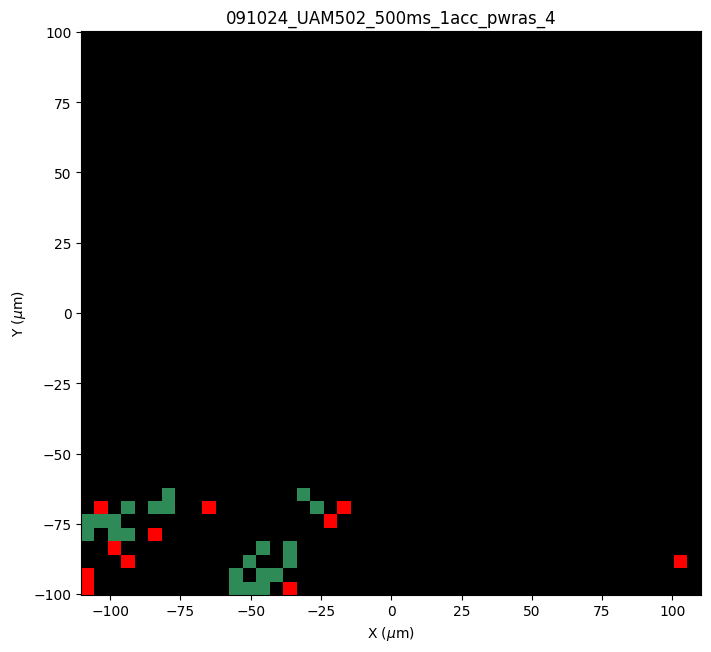


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_5
Válidos: 15, Outliers: 0


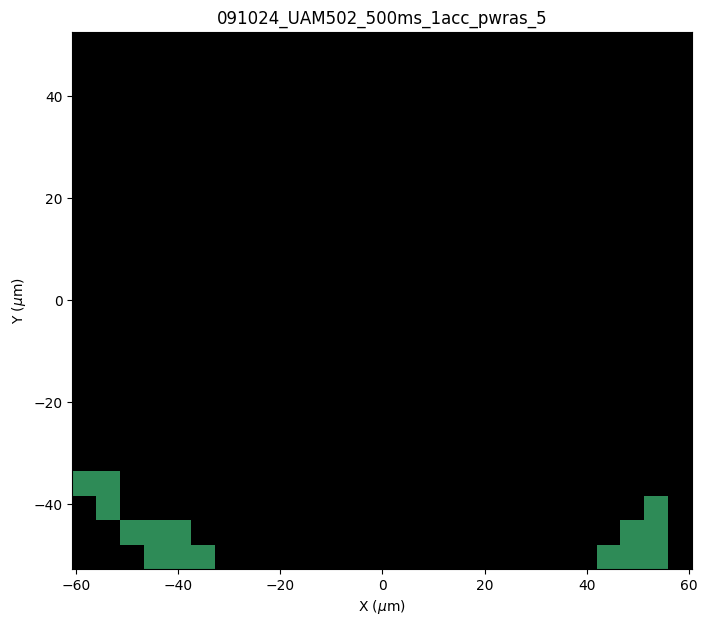


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_6
Válidos: 4, Outliers: 1


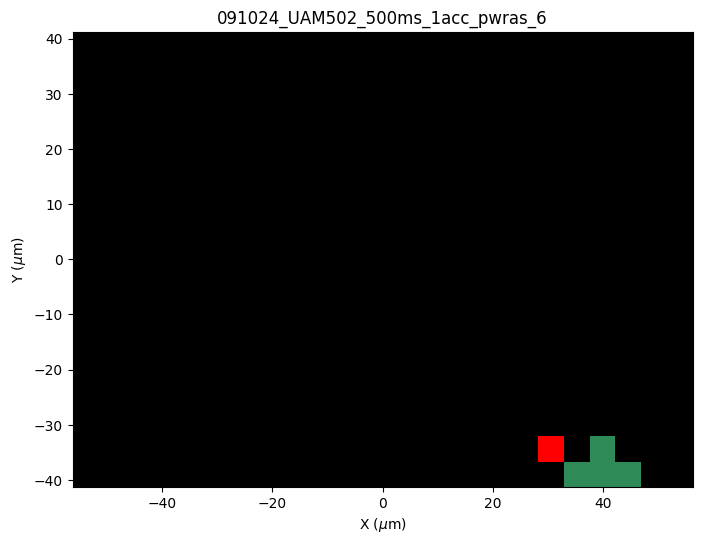


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_7
Válidos: 25, Outliers: 9


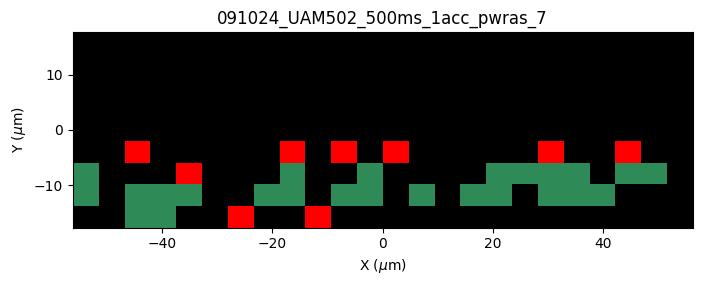


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_8
Válidos: 94, Outliers: 7


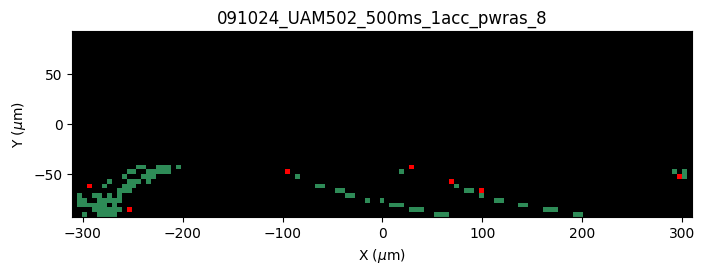


Procesando archivo: 091024_UAM502_500ms_1acc_pwras_9
Válidos: 116, Outliers: 14


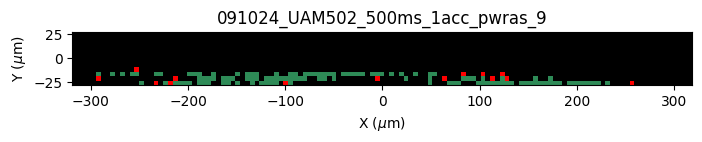


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_1
Válidos: 2, Outliers: 0


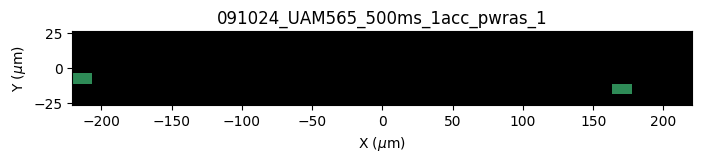


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_10
Válidos: 4, Outliers: 0


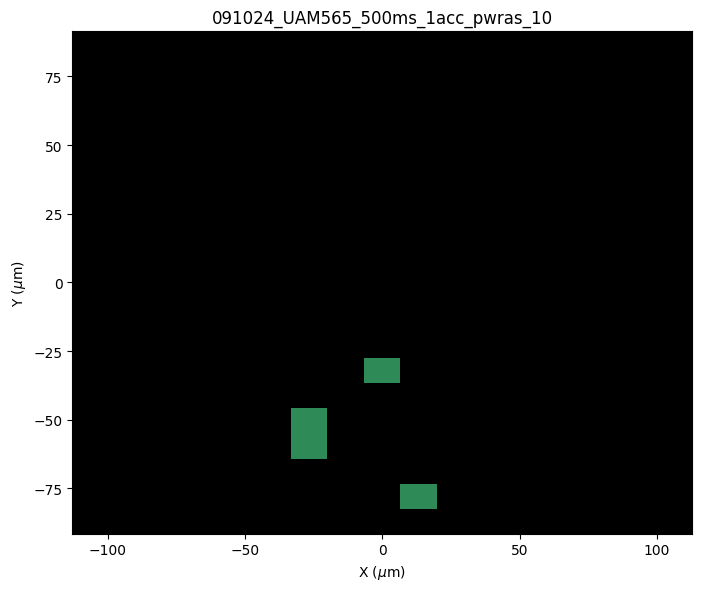


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_11
Válidos: 128, Outliers: 0


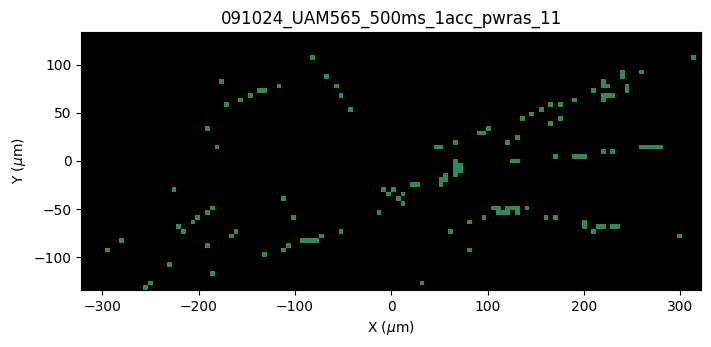


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_16
Válidos: 137, Outliers: 0


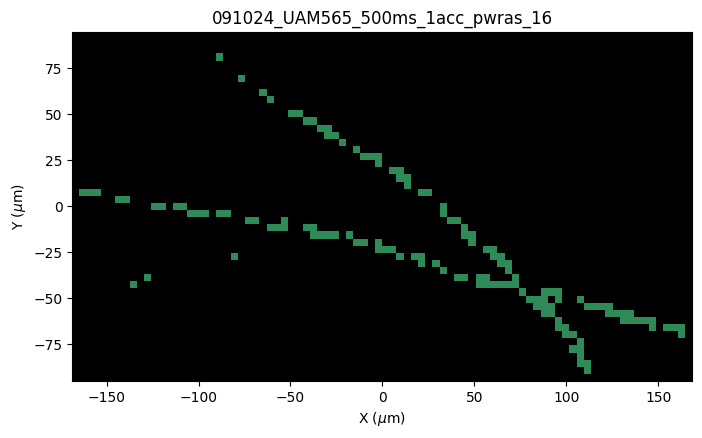


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_2
Válidos: 9, Outliers: 0


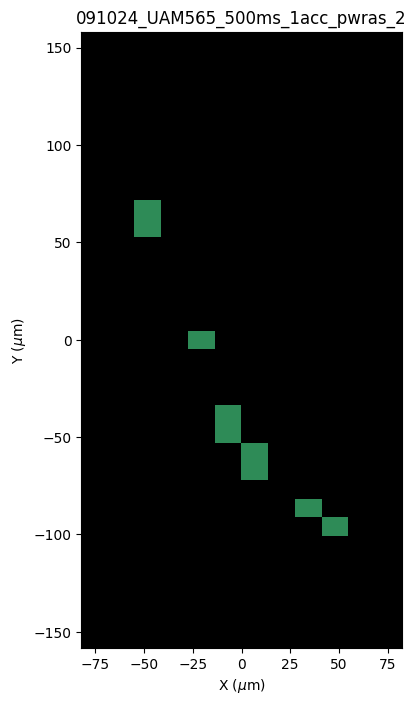


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_3
Válidos: 8, Outliers: 0


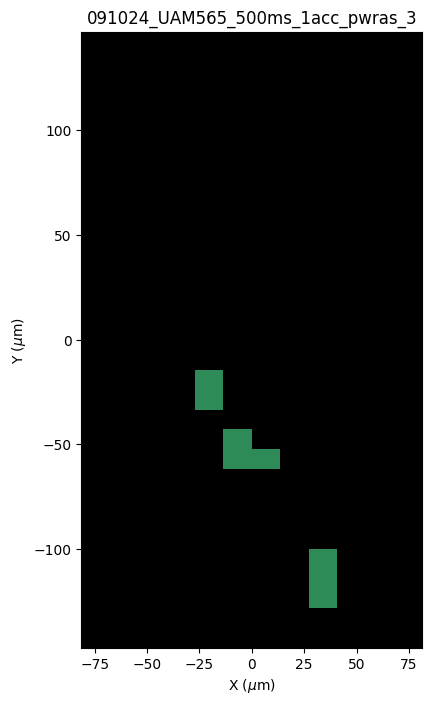


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_4
Válidos: 1, Outliers: 0


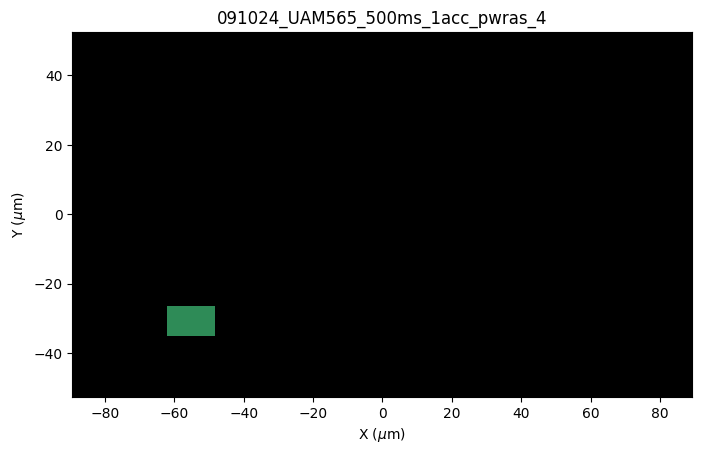


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_5
Válidos: 8, Outliers: 0


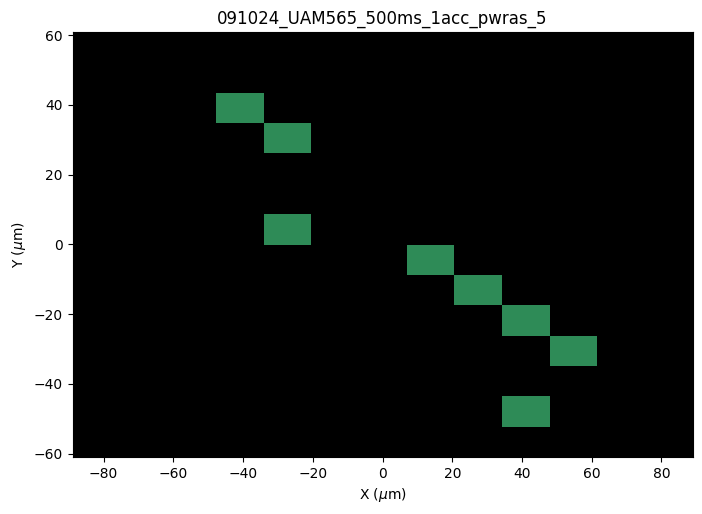


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_6
Válidos: 4, Outliers: 0


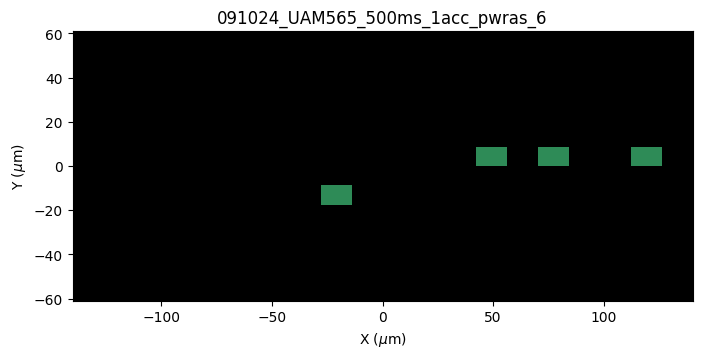


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_7
Válidos: 15, Outliers: 0


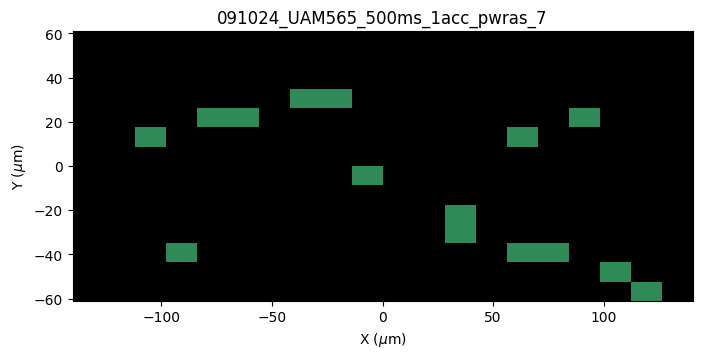


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_8
Válidos: 5, Outliers: 0


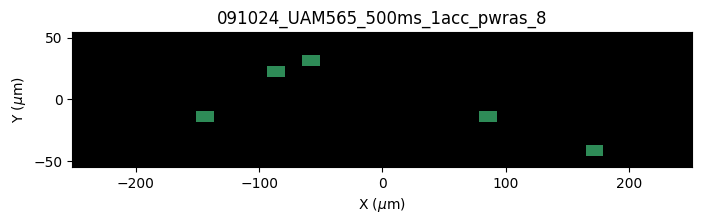


Procesando archivo: 091024_UAM565_500ms_1acc_pwras_9
Válidos: 29, Outliers: 0


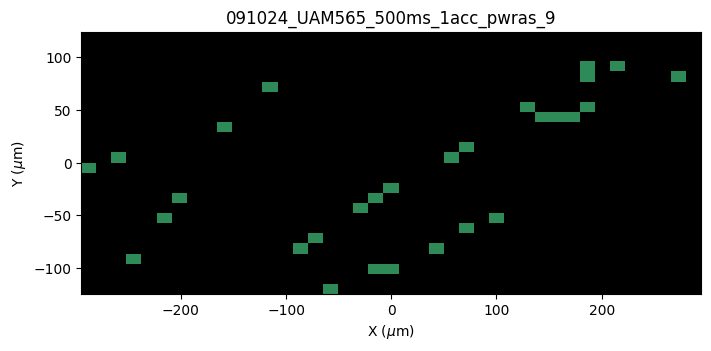


Procesando archivo: 091024_UAM565_controzos_500ms_1acc_pwras_12
Válidos: 16, Outliers: 0


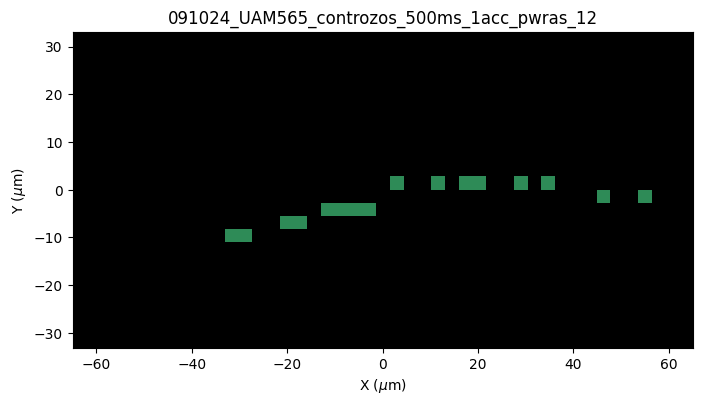


Procesando archivo: 091024_UAM565_controzos_500ms_1acc_pwras_13
Válidos: 102, Outliers: 0


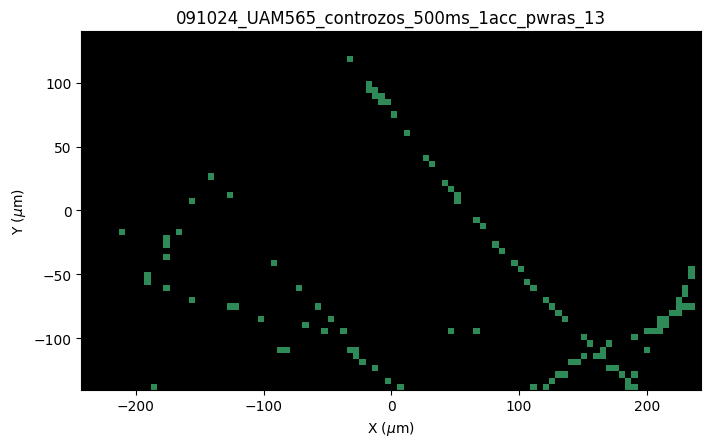


Procesando archivo: 091024_UAM565_controzos_500ms_1acc_pwras_14
Válidos: 104, Outliers: 0


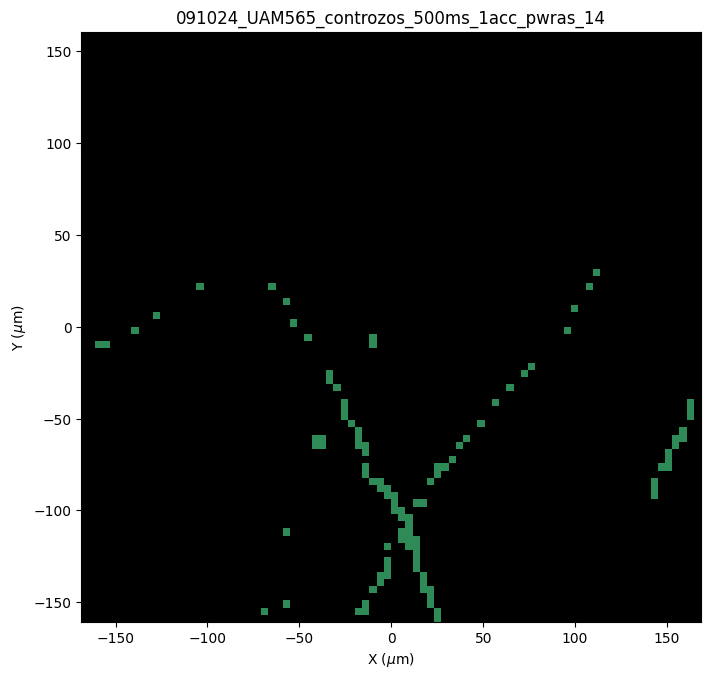


Procesando archivo: 091024_UAM565_controzos_500ms_1acc_pwras_15
Válidos: 41, Outliers: 0


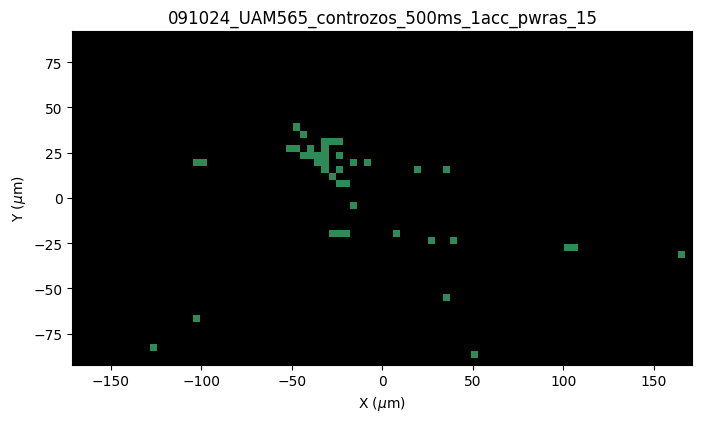


Procesando archivo: 091024_UAM565_controzos_500ms_1acc_pwras_17
Válidos: 62, Outliers: 0


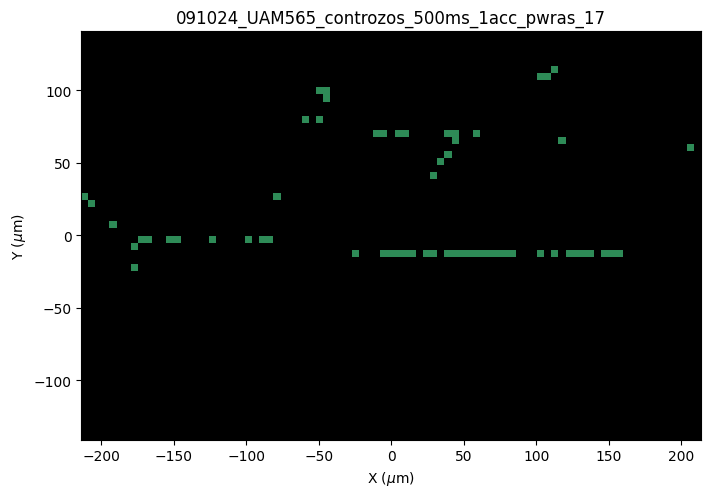


Procesando archivo: 091024_UAM588_2_500ms_1acc_pwras_1
Válidos: 38, Outliers: 1


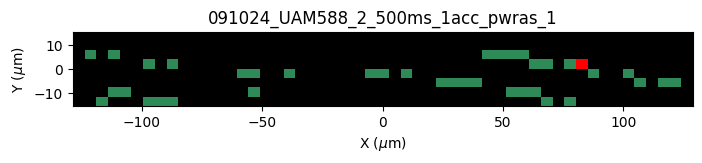


Procesando archivo: 091024_UAM588_2_500ms_1acc_pwras_2
Válidos: 10, Outliers: 0


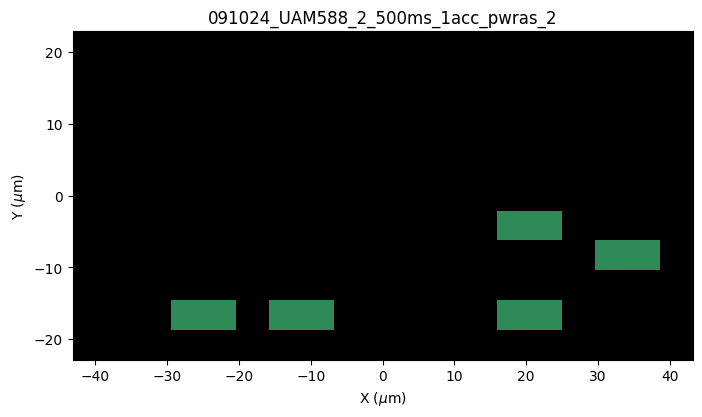


Procesando archivo: 091024_UAM588_2_500ms_1acc_pwras_3
Válidos: 52, Outliers: 0


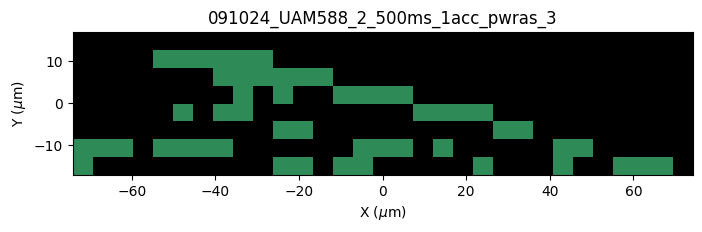


Procesando archivo: 091024_UAM588_2_500ms_1acc_pwras_4
Válidos: 52, Outliers: 4


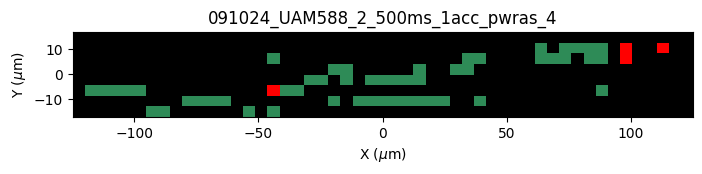


Procesando archivo: 091024_UAM588_2_500ms_1acc_pwras_5
Válidos: 111, Outliers: 0


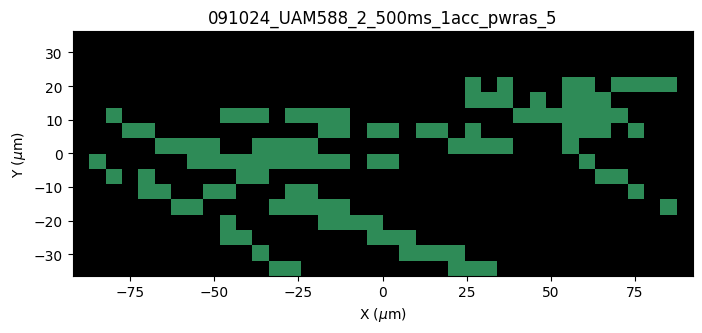


Procesando archivo: 091024_UAM588_2_500ms_1acc_pwras_6
Válidos: 43, Outliers: 5


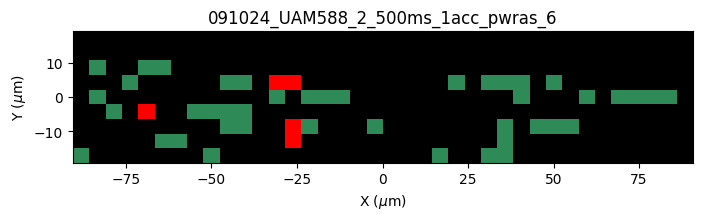


Procesando archivo: 091024_UAM588_2_500ms_1acc_pwras_7
Válidos: 46, Outliers: 0


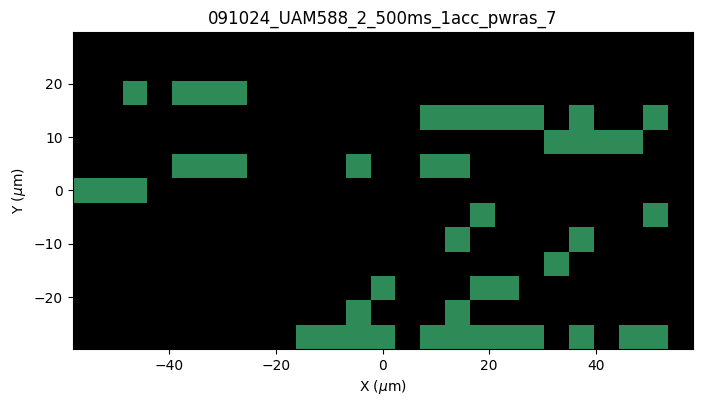


Procesando archivo: 091024_UAM588_2_500ms_1acc_pwras_8
Válidos: 155, Outliers: 28


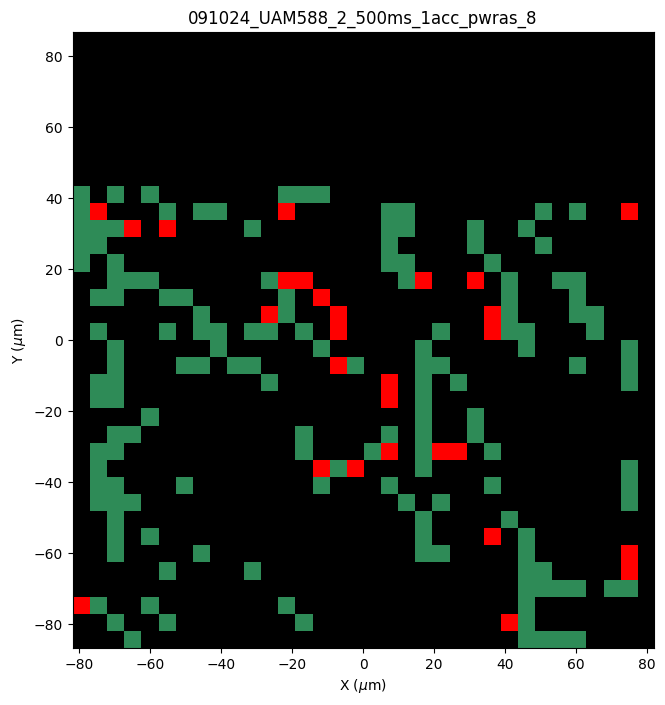


Procesando archivo: 091024_UAM588_500ms_1acc_pwras_1
Válidos: 407, Outliers: 17


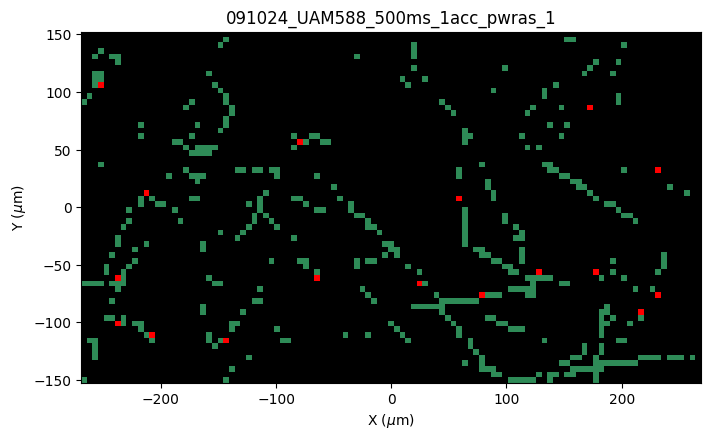


Procesando archivo: 091024_UAM588_500ms_1acc_pwras_2
Válidos: 178, Outliers: 3


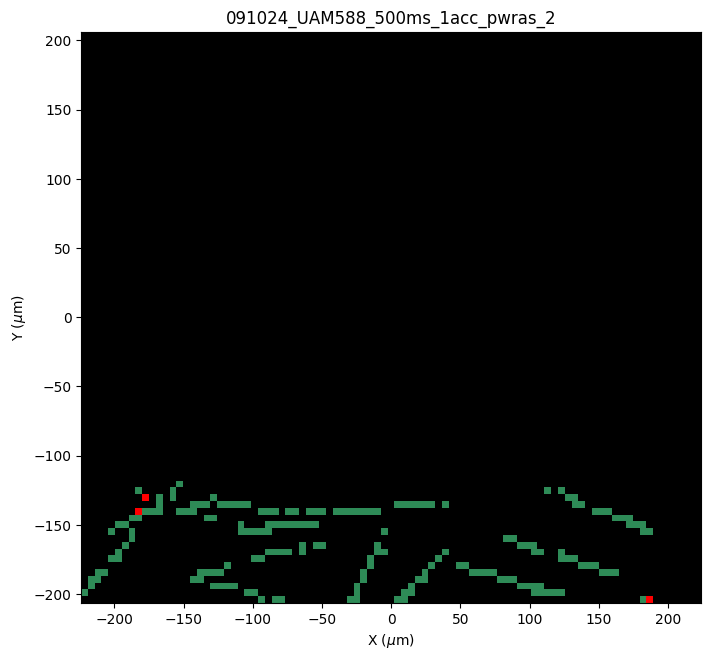


Procesando archivo: 091024_UAM588_500ms_1acc_pwras_3
Válidos: 332, Outliers: 21


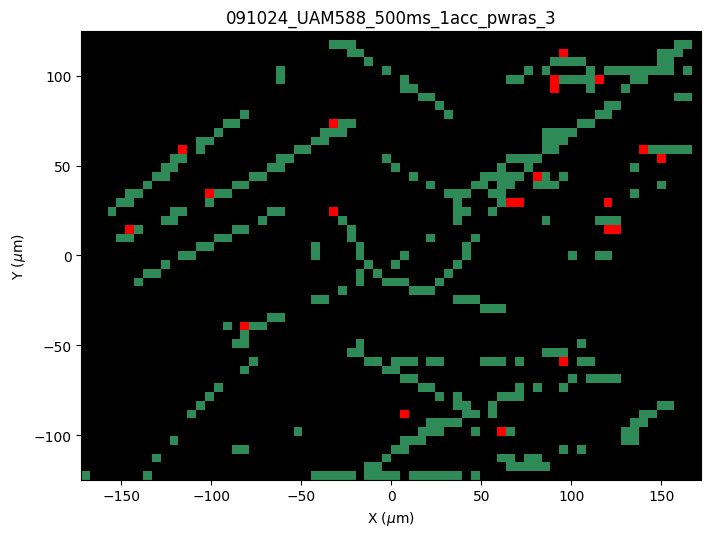


Procesando archivo: 091024_UAM588_500ms_1acc_pwras_4
Válidos: 4, Outliers: 1


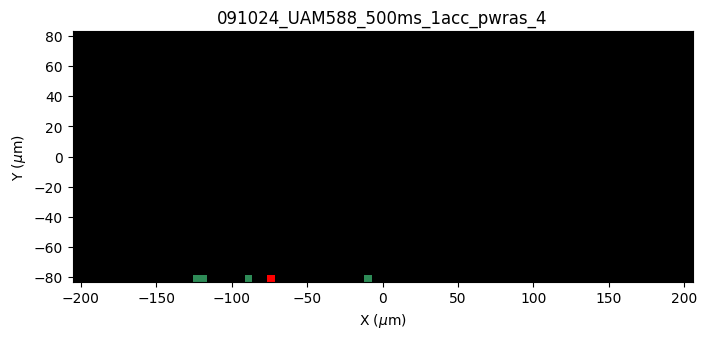


Procesando archivo: 091024_UAM588_500ms_1acc_pwras_5
Válidos: 155, Outliers: 2


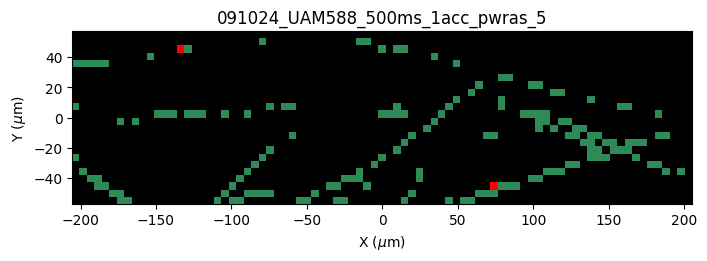


Procesando archivo: 100724_UAM502_500ms_1acc_pwmuesca1
Válidos: 334, Outliers: 41


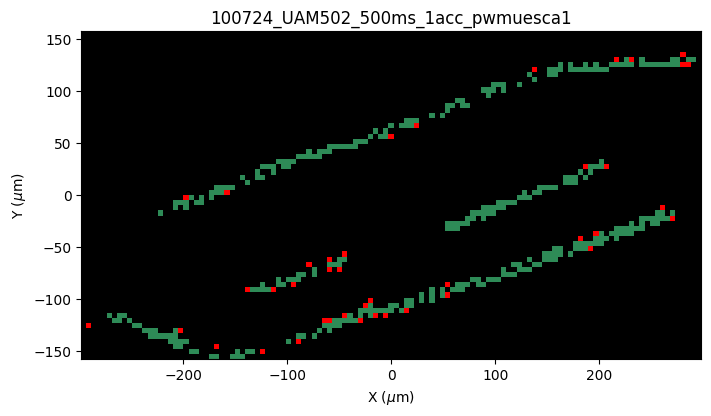


Procesando archivo: 100724_UAM502_500ms_1acc_pwmuesca1_2
Válidos: 86, Outliers: 10


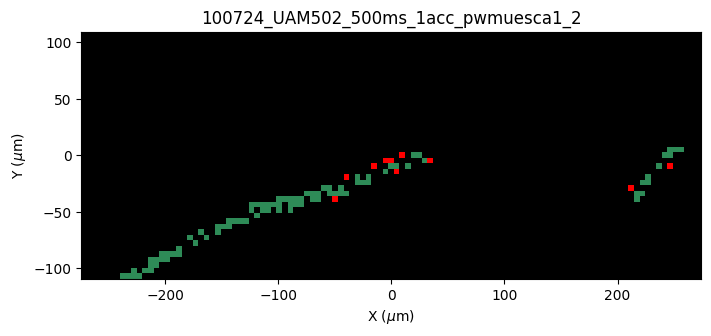


Procesando archivo: 100724_UAM502_500ms_1acc_pwmuesca1_3
Válidos: 35, Outliers: 2


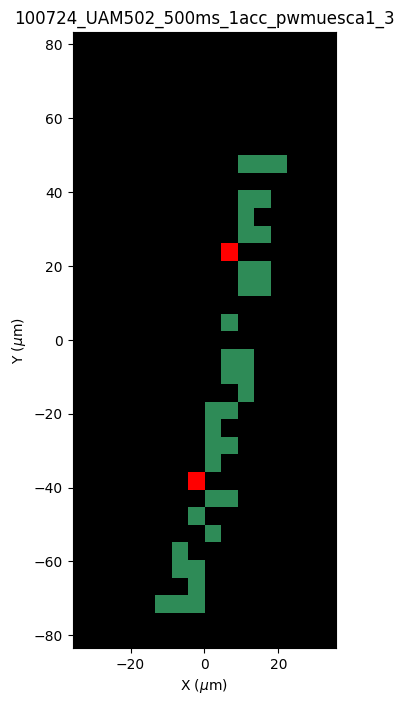


Procesando archivo: 100724_UAM588_1s_2acc_2um
Válidos: 756, Outliers: 0


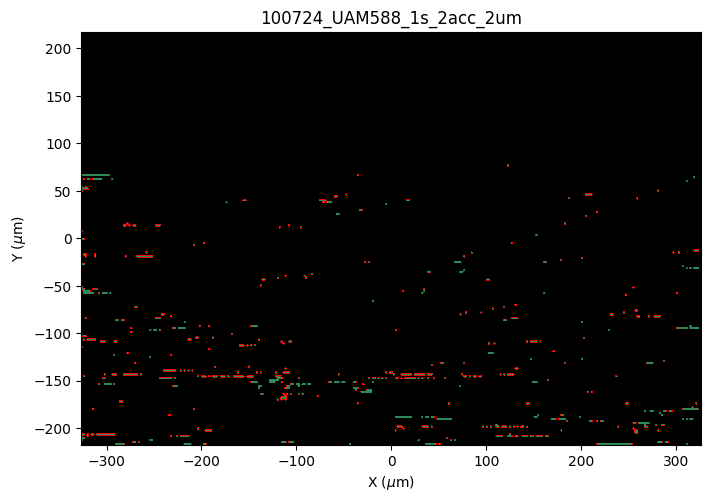


Procesando archivo: 100824_UAM565_1s_1acc_pwcasi1_2um_1
Válidos: 245, Outliers: 34


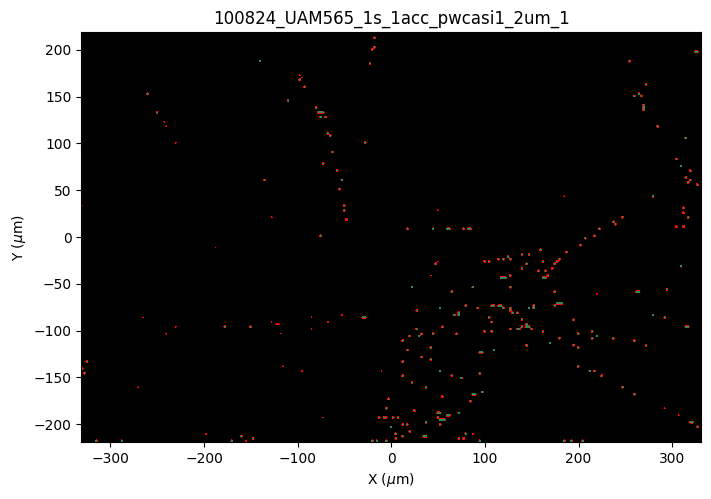


Procesando archivo: 110624_UAM253_1s_1acc_pwmuesca1_10um_3
Válidos: 200, Outliers: 1
No se encontraron datos en infomapas para el archivo: 110624_UAM253_1s_1acc_pwmuesca1_10um_3

Procesando archivo: 110624_UAM253_1s_1acc_pwmuesca1_5um_1
Válidos: 799, Outliers: 80


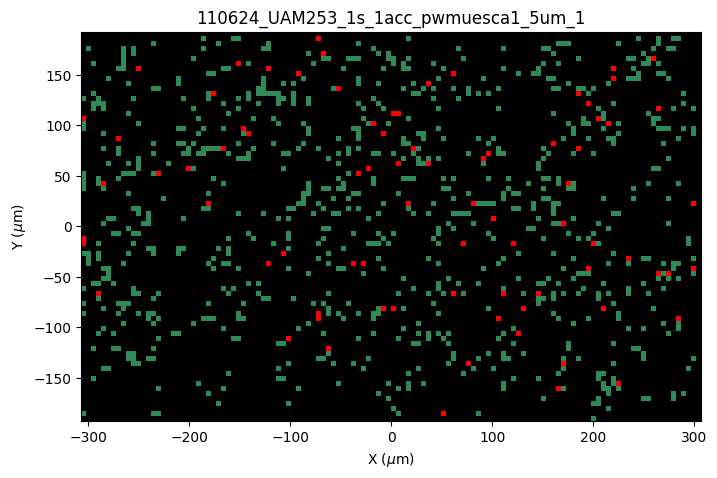


Procesando archivo: 110624_UAM253_1s_1acc_pwmuesca1_7um_2
Válidos: 388, Outliers: 3


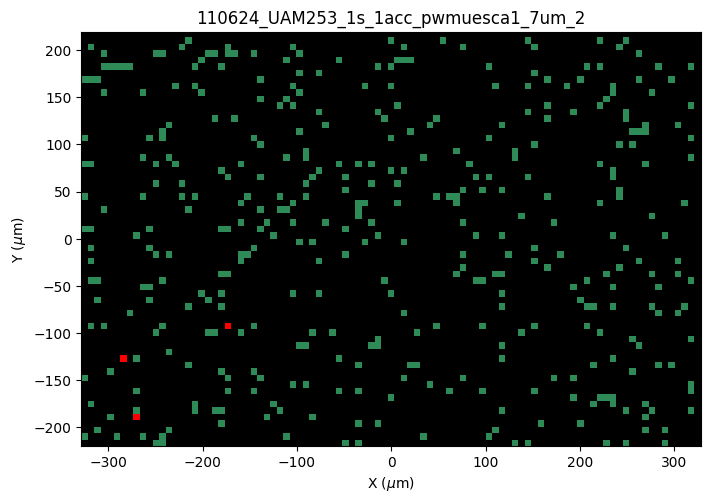


Procesando archivo: 120624_UAM253_1s_1acc_pwmuesca1_10um_4
Válidos: 268, Outliers: 4


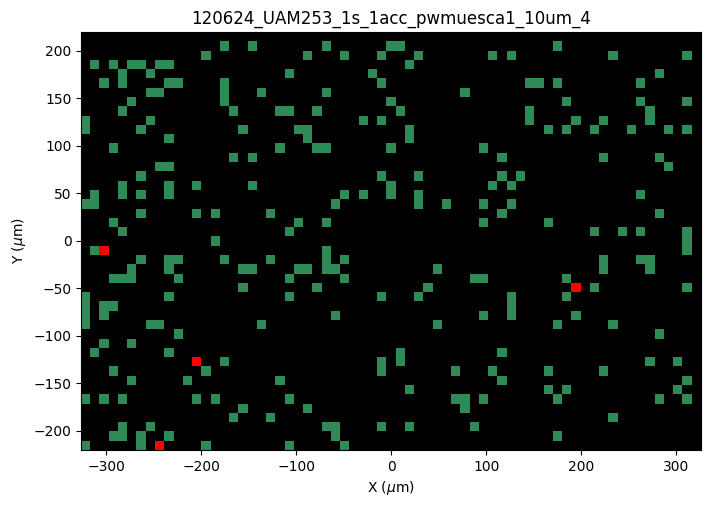


Procesando archivo: 120624_UAM253_1s_1acc_pwmuesca1_10um_6
Válidos: 232, Outliers: 1


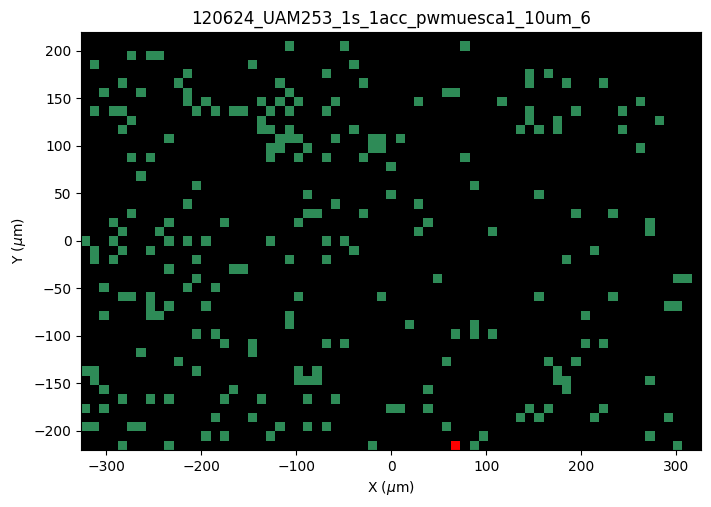


Procesando archivo: 120624_UAM253_1s_1acc_pwmuesca1_5um_5
Válidos: 607, Outliers: 29


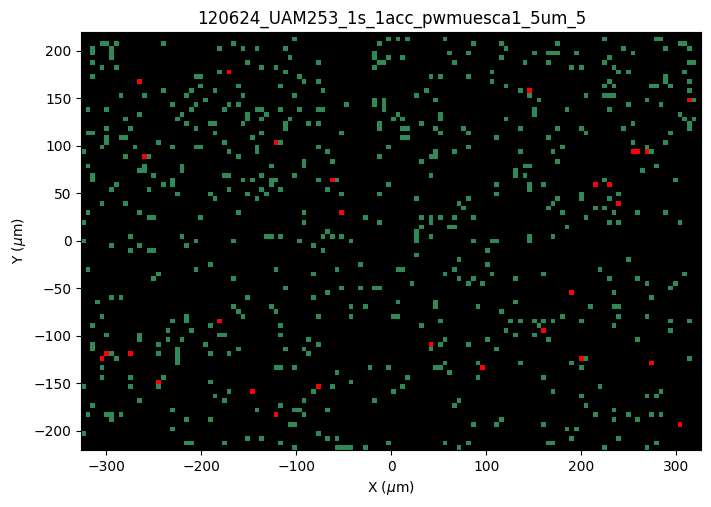


Procesando archivo: 120624_UAM253_1s_1acc_pwras_5um_10
Válidos: 150, Outliers: 9


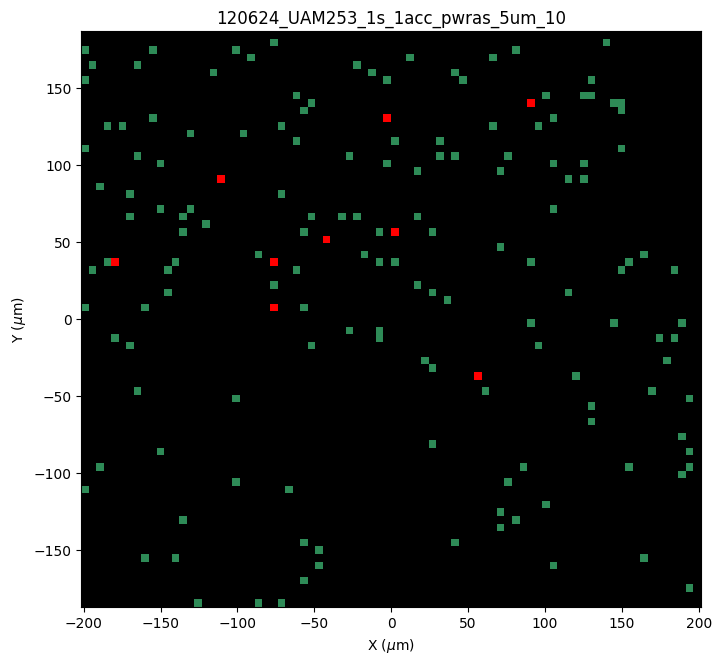


Procesando archivo: 120624_UAM253_1s_1acc_pwras_5um_9
Válidos: 480, Outliers: 13


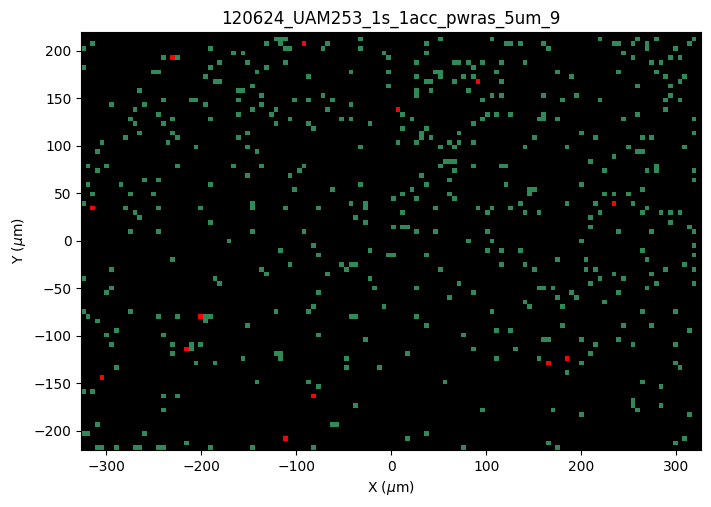


Procesando archivo: 120624_UAM253_2s_1acc_pwmuesca1_10um_7
Válidos: 339, Outliers: 1


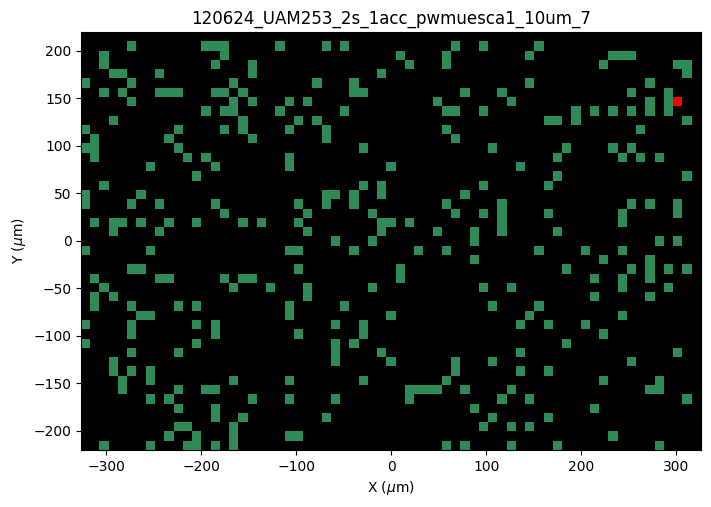


Procesando archivo: 120624_UAM253_2s_1acc_pwmuesca1_10um_8
Válidos: 406, Outliers: 0


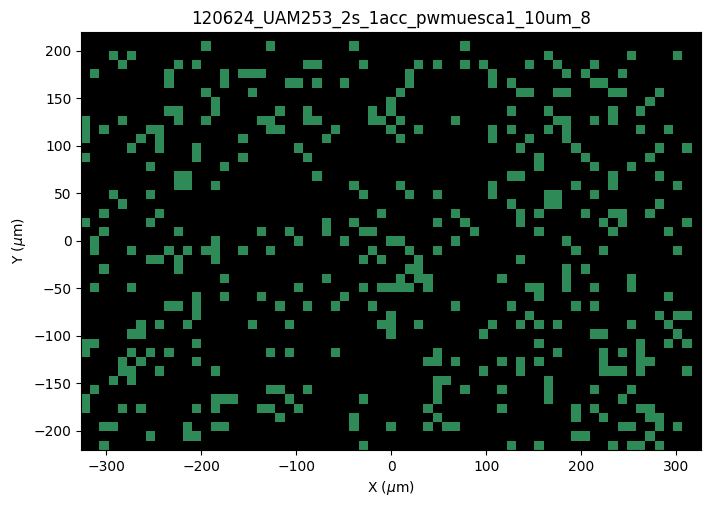


Procesando archivo: 120724_charco1_1s_1acc_pwcasiras
Válidos: 25, Outliers: 0


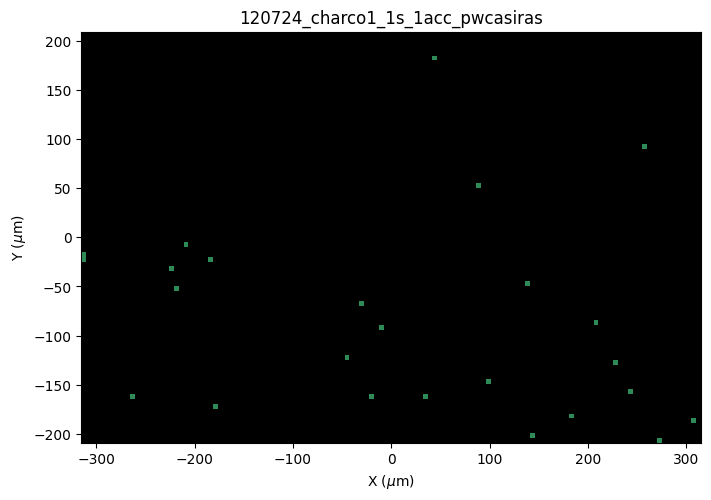


Procesando archivo: 120824_UAM565_300ms_1acc_pwcasiras_6um_1
Válidos: 352, Outliers: 7


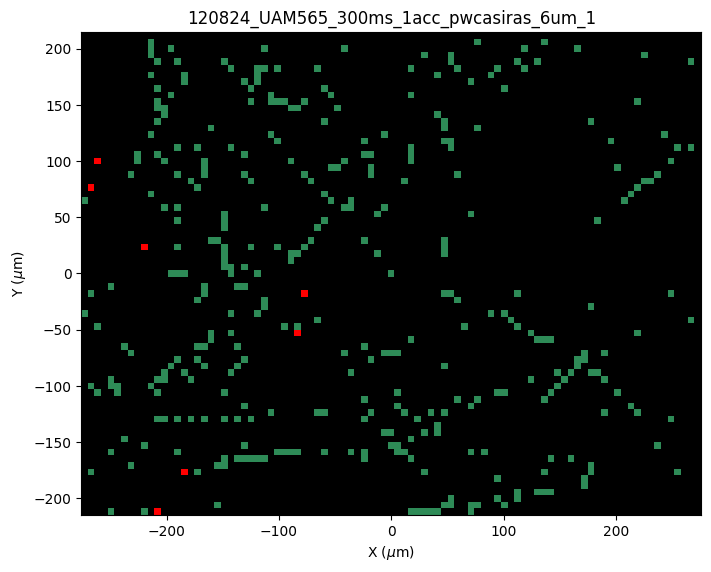


Procesando archivo: 120824_UAM565_300ms_1acc_pwcasiras_6um_2
Válidos: 237, Outliers: 0


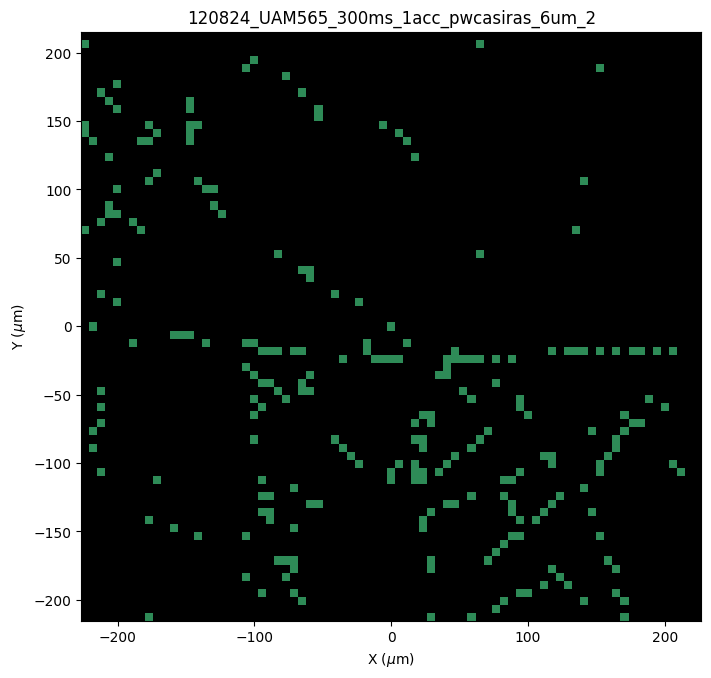


Procesando archivo: 120824_UAM565_300ms_1acc_pwcasiras_6um_3
Válidos: 201, Outliers: 5


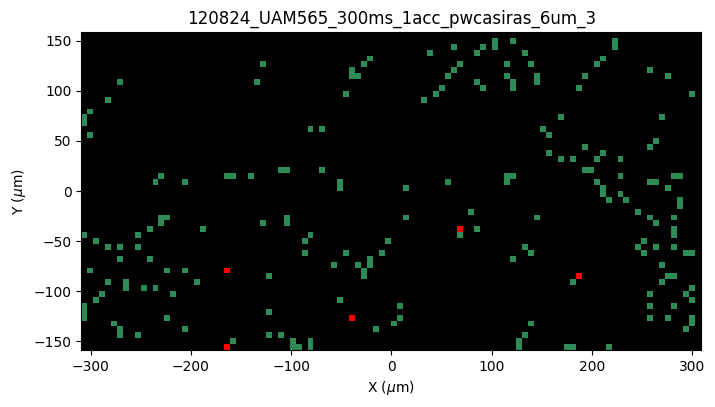


Procesando archivo: 120824_UAM565_300ms_1acc_pwcasiras_6um_4
Válidos: 25, Outliers: 6


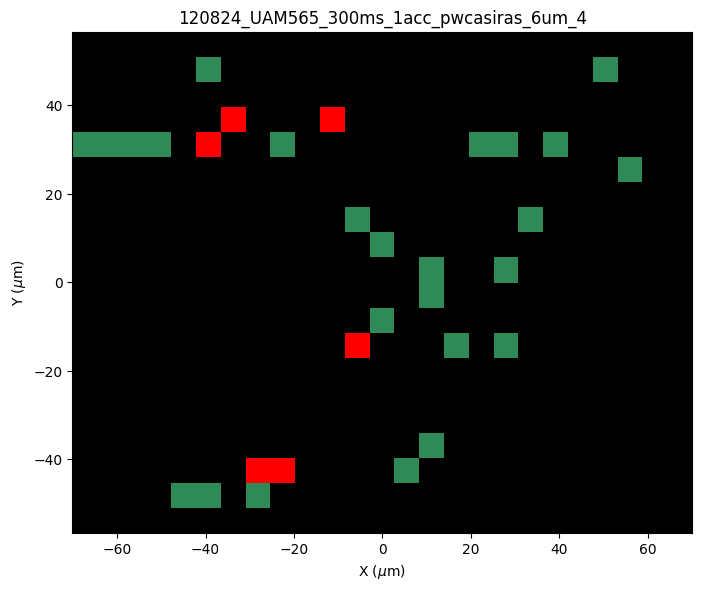


Procesando archivo: 120824_UAM565_300ms_1acc_pwcasiras_6um_5
Válidos: 135, Outliers: 0


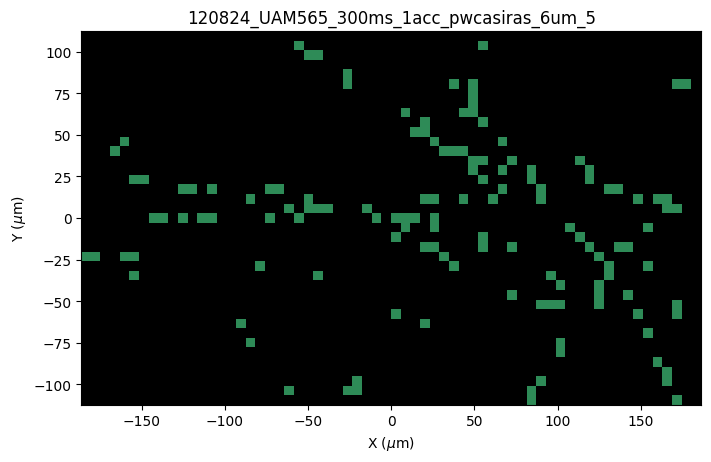


Procesando archivo: 120824_UAM565_300ms_1acc_pwmedio1_5um_3
Válidos: 166, Outliers: 6


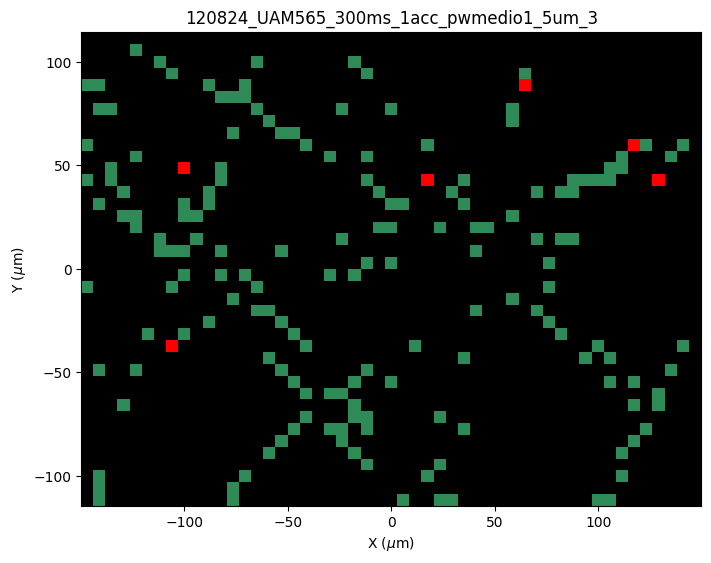


Procesando archivo: 120824_UAM565_500ms_1acc_pwmedio1_5um_1
Válidos: 248, Outliers: 3


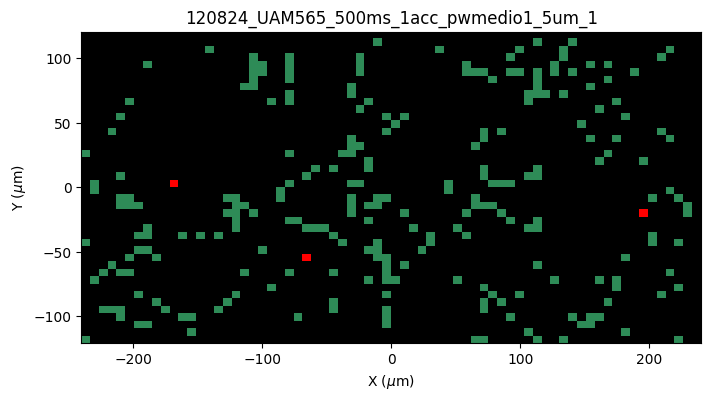


Procesando archivo: 120824_UAM565_500ms_1acc_pwmedio1_5um_2
Válidos: 243, Outliers: 37


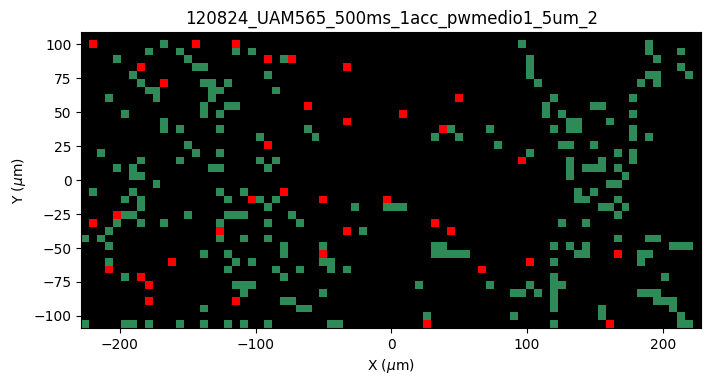


Procesando archivo: 120824_UAM565_500ms_1acc_pwmedio1_5um_3
Válidos: 116, Outliers: 0


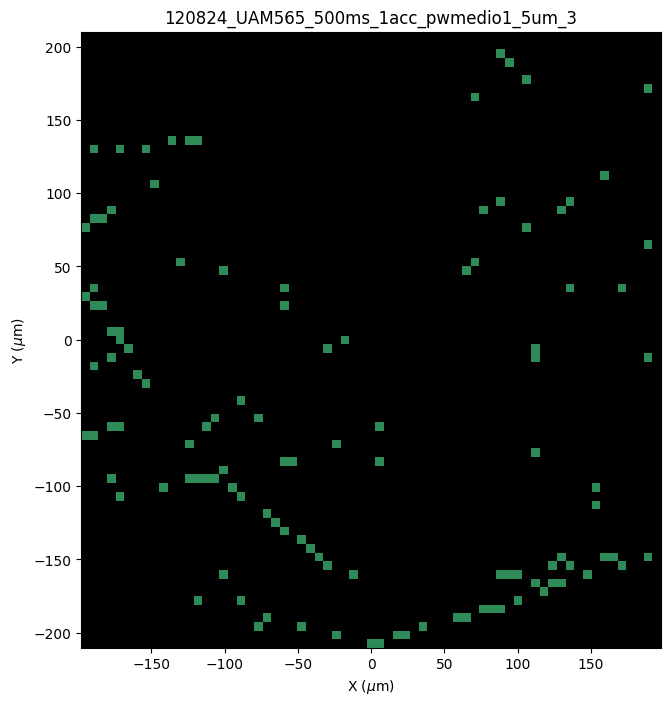


Procesando archivo: 120824_UAM565_500ms_1acc_pwmedio1_5um_4
Válidos: 68, Outliers: 3


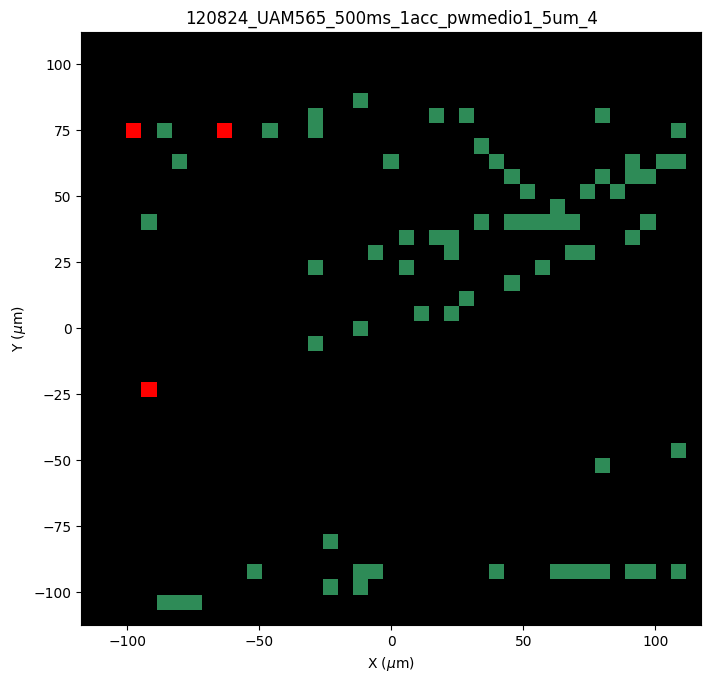


Procesando archivo: 120824_UAM565_500ms_1acc_pwmedio1_5um_5
Válidos: 108, Outliers: 1


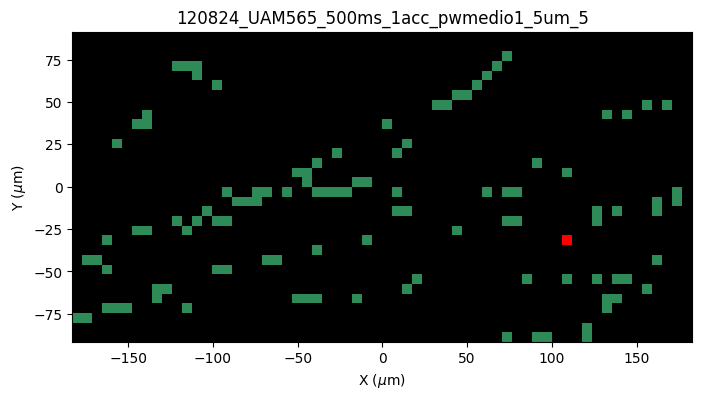


Procesando archivo: 120824_UAM565_500ms_1acc_pwmedio1_5um_6
Válidos: 66, Outliers: 0


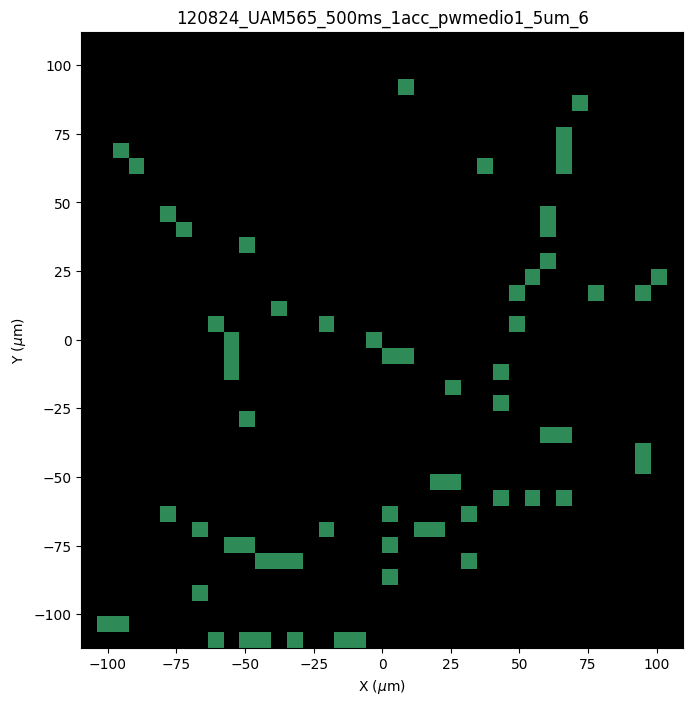


Procesando archivo: 130824_UAM253_500ms_1acc_pwcasi1_6um_1
Válidos: 208, Outliers: 0


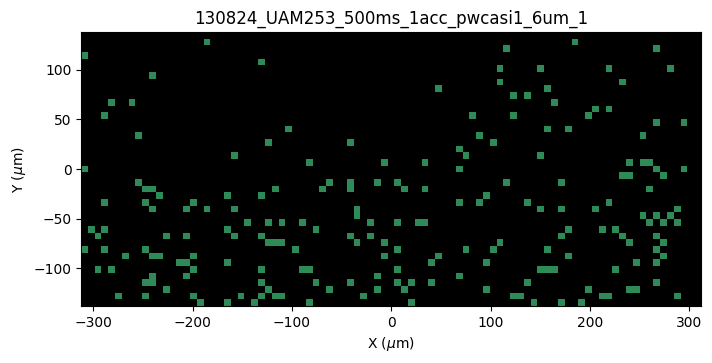


Procesando archivo: 130824_UAM253_500ms_1acc_pwcasi1_6um_2
Válidos: 128, Outliers: 2


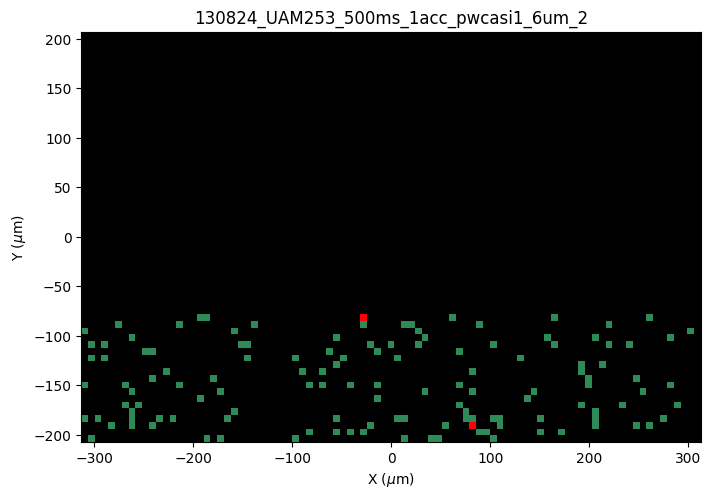


Procesando archivo: 130824_UAM565_1s_1acc_pwmuesca1_6um_1
Válidos: 32, Outliers: 0


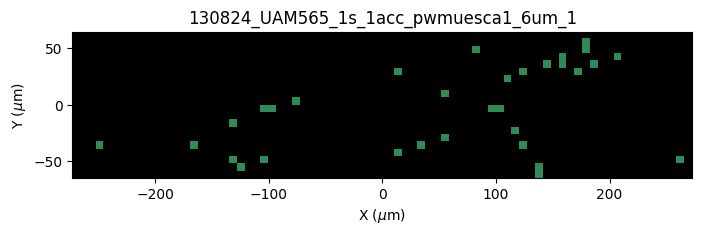


Procesando archivo: 130824_UAM565_1s_1acc_pwmuesca1_6um_2
Válidos: 34, Outliers: 0


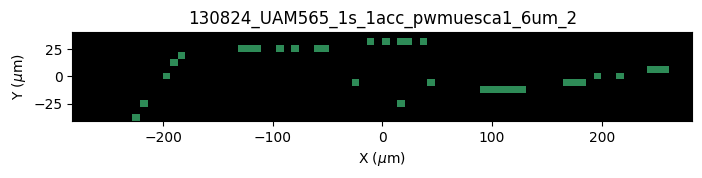


Procesando archivo: 130824_UAM565_1s_1acc_pwmuesca1_6um_3
Válidos: 53, Outliers: 1


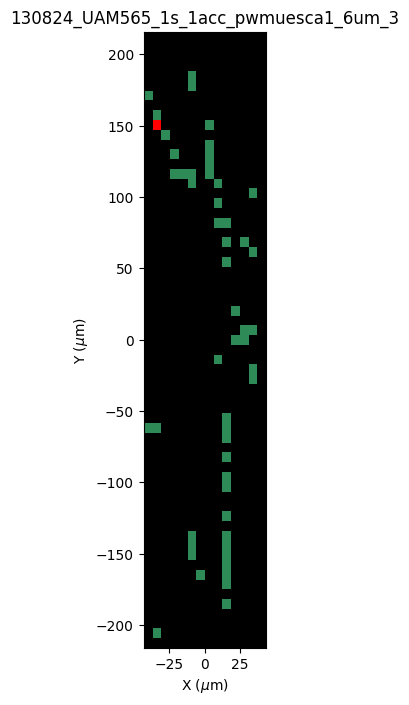


Procesando archivo: 130824_UAM565_1s_1acc_pwmuesca1_6um_4
Válidos: 14, Outliers: 0


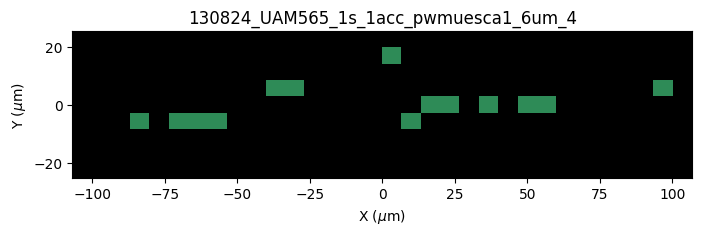


Procesando archivo: 130824_UAM565_300ms_1acc_pwmedio_6um_1
Válidos: 132, Outliers: 4


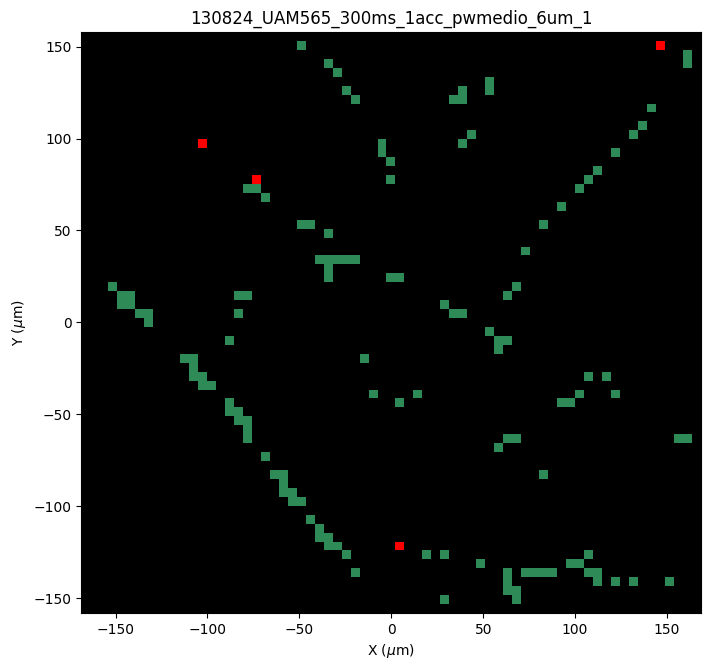


Procesando archivo: 130824_UAM565_300ms_1acc_pwmedio_6um_2
Válidos: 158, Outliers: 0


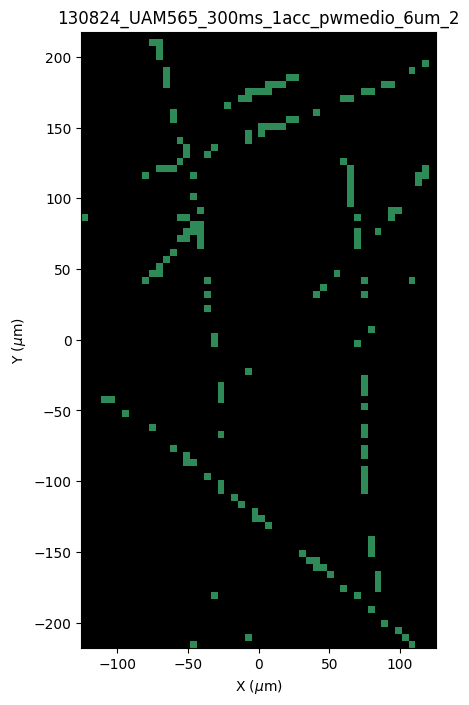


Procesando archivo: 130824_UAM565_300ms_1acc_pwmedio_6um_3
Válidos: 142, Outliers: 0


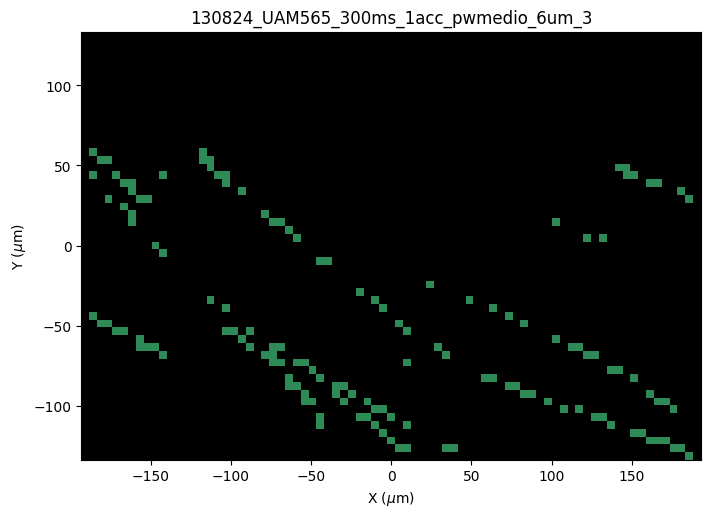


Procesando archivo: 130824_UAM565_300ms_1acc_pwmedio_6um_4
Válidos: 85, Outliers: 0


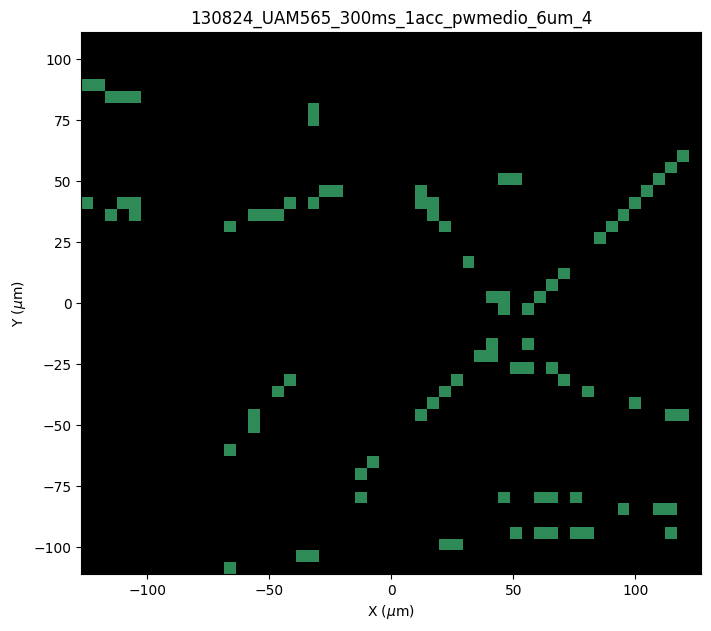


Procesando archivo: 130824_UAM565_500ms_1acc_pwmuescacasi1_5um_1
Válidos: 67, Outliers: 0


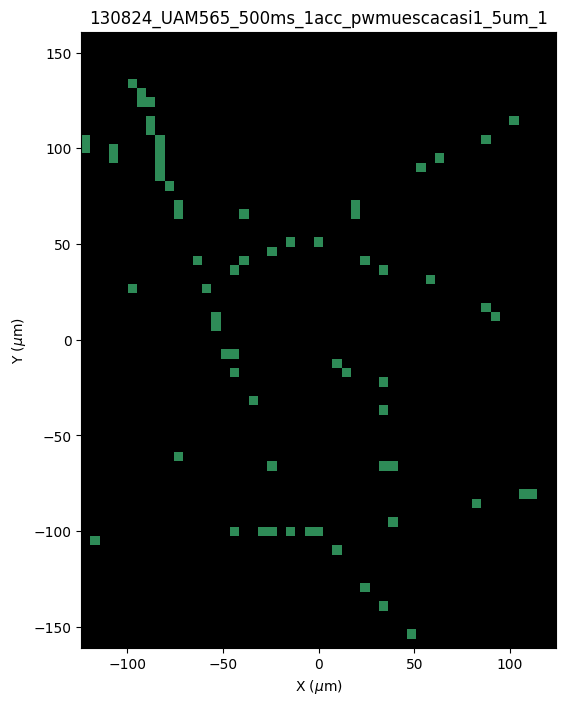


Procesando archivo: 130824_UAM565_500ms_1acc_pwmuescacasi1_5um_2
Válidos: 204, Outliers: 2


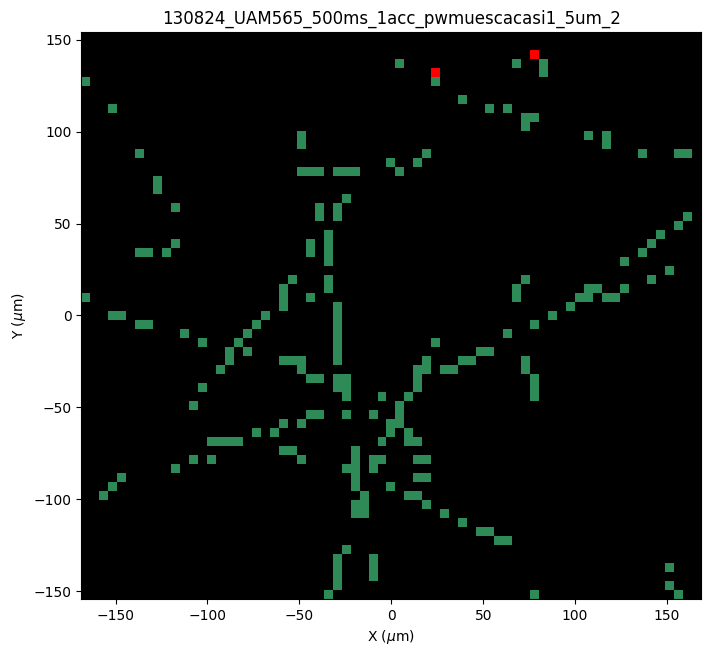


Procesando archivo: 140323_UAM588_2s_1acc_pwmuesca2_3um
Válidos: 44, Outliers: 1
No se encontraron datos en infomapas para el archivo: 140323_UAM588_2s_1acc_pwmuesca2_3um

Procesando archivo: 140323_UAM588_2s_1acc_pwmuesca2_4um
Válidos: 32, Outliers: 0
No se encontraron datos en infomapas para el archivo: 140323_UAM588_2s_1acc_pwmuesca2_4um

Procesando archivo: 140824_UAM253_500ms_1acc_pwcas1_5um_1
Válidos: 60, Outliers: 2


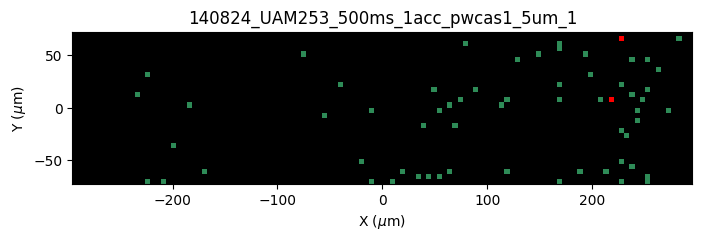


Procesando archivo: 140824_UAM253_500ms_1acc_pwcas1_5um_2
Válidos: 782, Outliers: 79


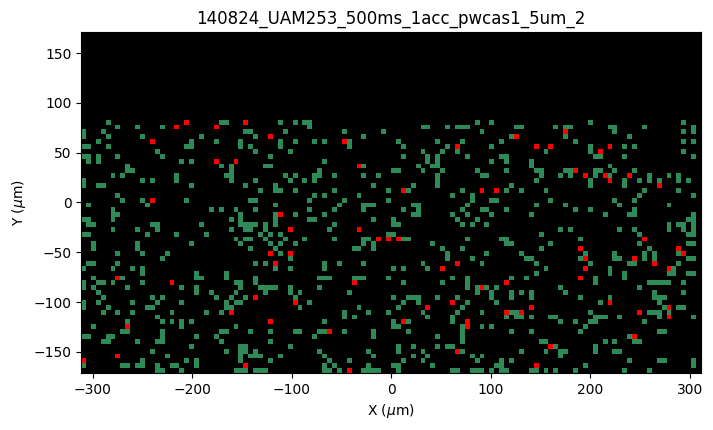


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_2um_1_largo
Válidos: 1490, Outliers: 12


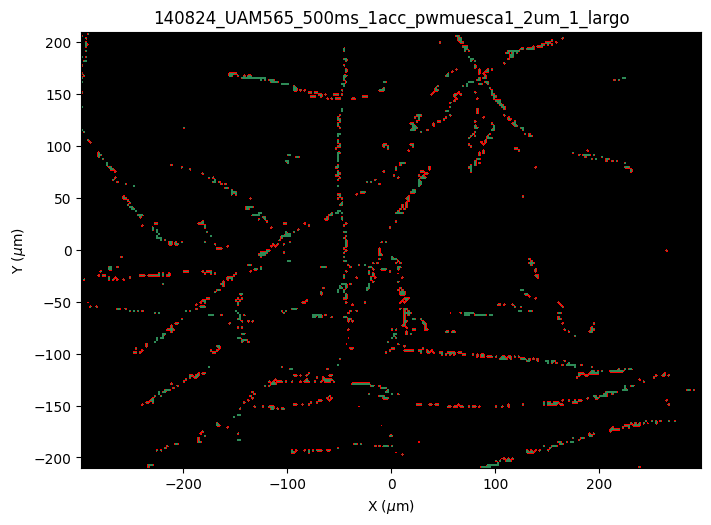


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_1
Válidos: 113, Outliers: 0


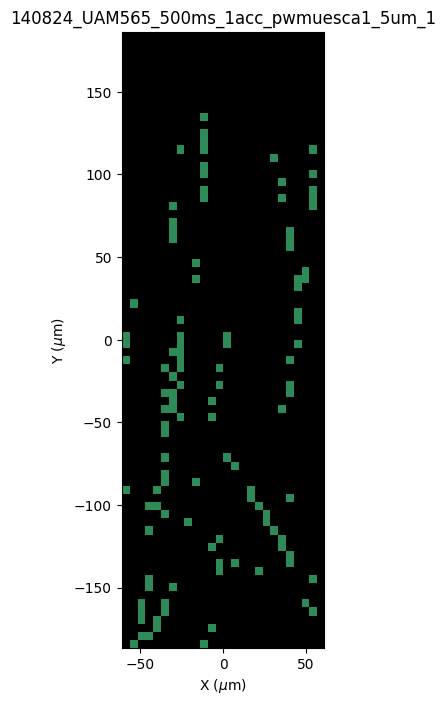


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_10
Válidos: 10, Outliers: 0


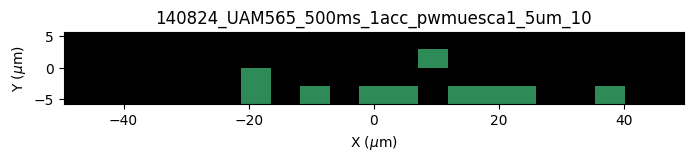


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_2
Válidos: 31, Outliers: 0


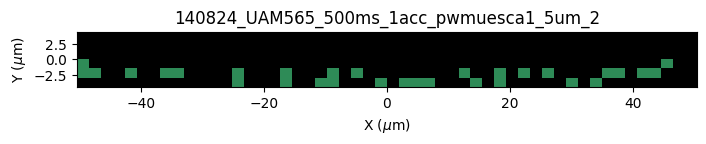


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_3
Válidos: 11, Outliers: 0


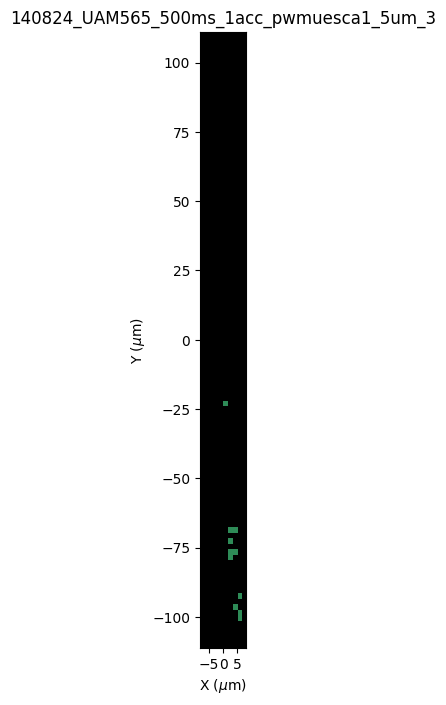


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_4
Válidos: 3, Outliers: 0


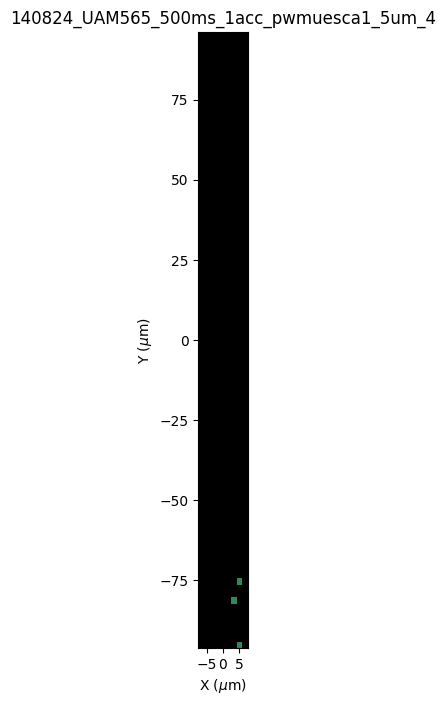


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_5
Válidos: 17, Outliers: 0


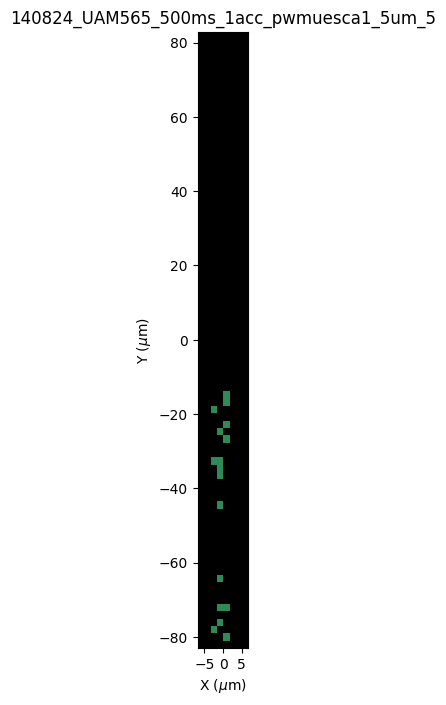


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_6
Válidos: 8, Outliers: 0


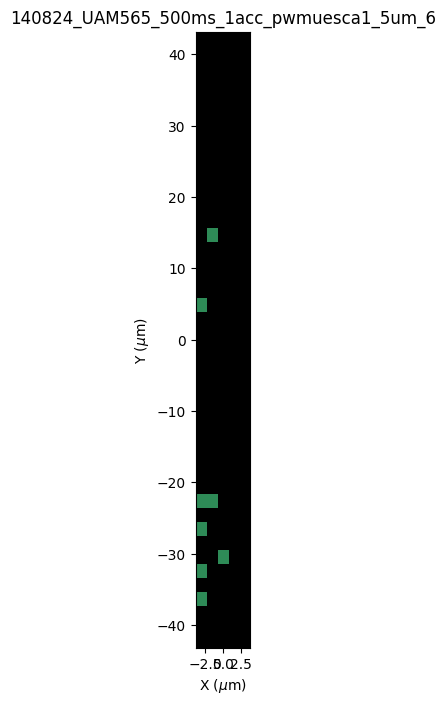


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_7
Válidos: 31, Outliers: 0


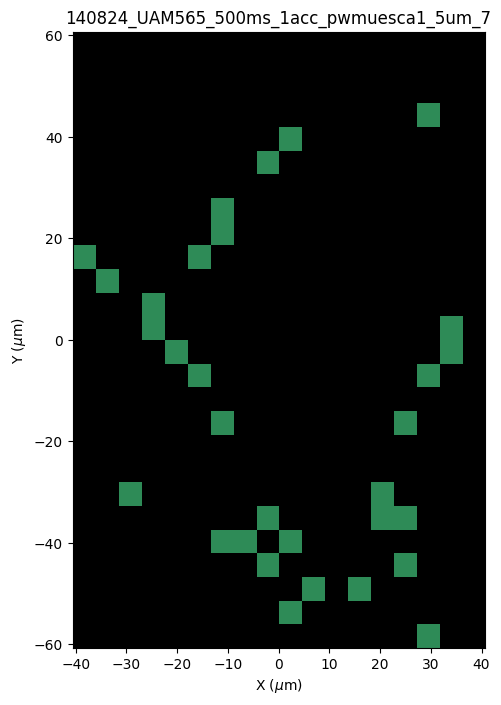


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_8
Válidos: 8, Outliers: 0


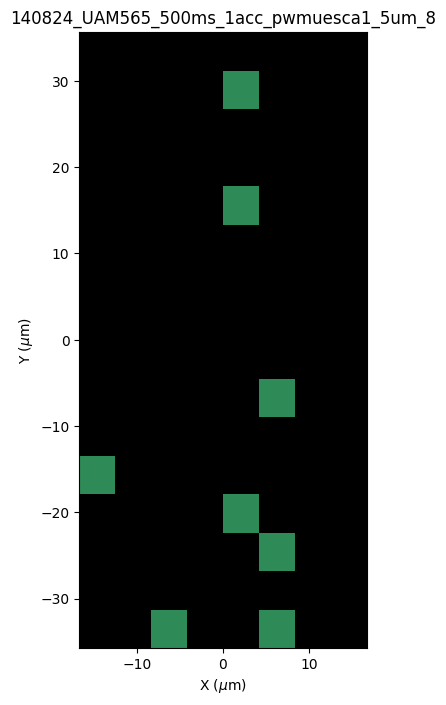


Procesando archivo: 140824_UAM565_500ms_1acc_pwmuesca1_5um_9
Válidos: 2, Outliers: 0


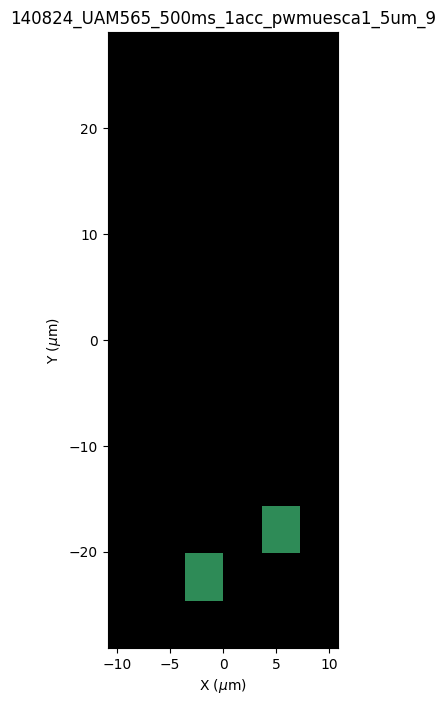


Procesando archivo: 150324_UAM588_2s_1acc_pwmuesca2_4um
Válidos: 47, Outliers: 0


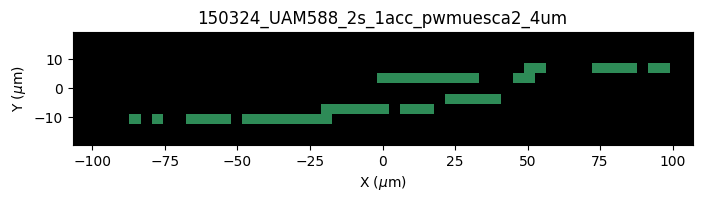


Procesando archivo: 150324_UAM588_300ms_1acc_pwras_5um_2
Válidos: 94, Outliers: 1


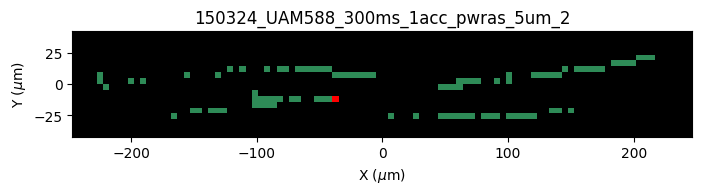


Procesando archivo: 150324_UAM588_300ms_1acc_pwras_5um_3
Válidos: 188, Outliers: 0


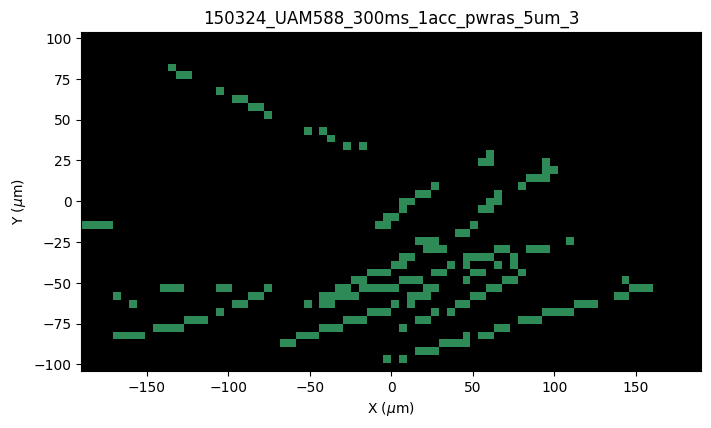


Procesando archivo: 150324_UAM588_500ms_1acc_pwmuesca1_4um
Válidos: 7, Outliers: 0


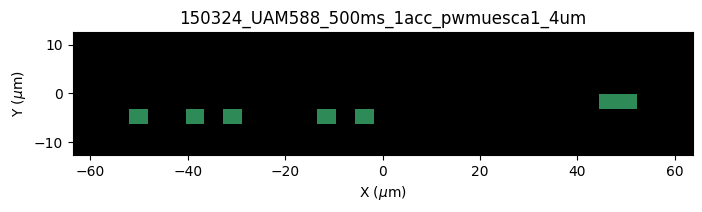


Procesando archivo: 150324_UAM588_500ms_1acc_pwmuesca1_4um_2
Válidos: 19, Outliers: 0


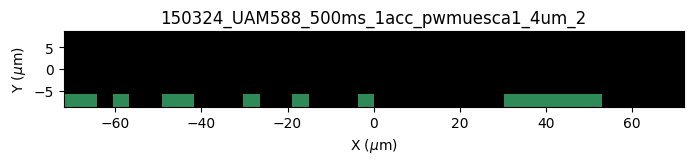


Procesando archivo: 150324_UAM588_500ms_1acc_pwmuesca1_4um_3
Válidos: 40, Outliers: 0


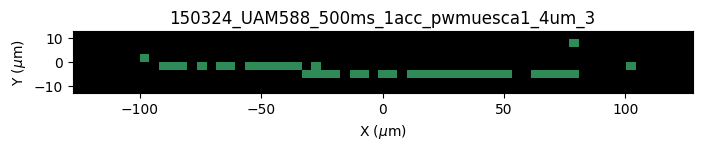


Procesando archivo: 150724_charco1_1s_1acc_pwcasiras
Válidos: 6, Outliers: 0


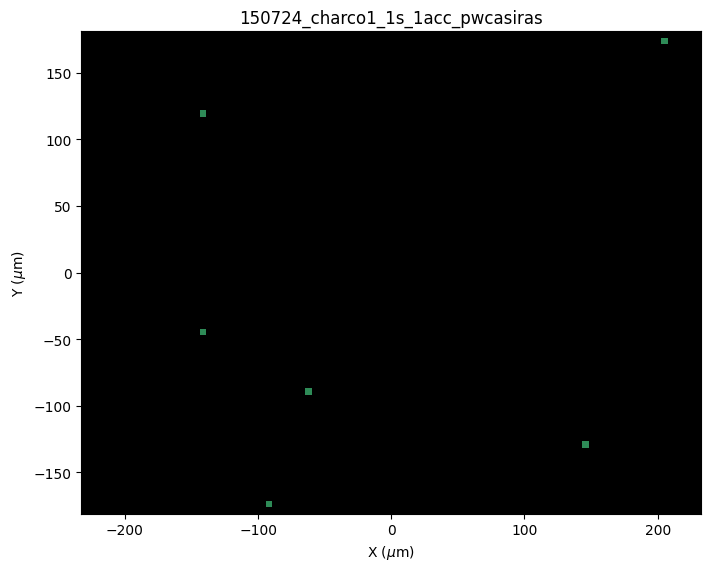


Procesando archivo: 150724_charco1_1s_1acc_pwcasiras_2
Válidos: 610, Outliers: 0


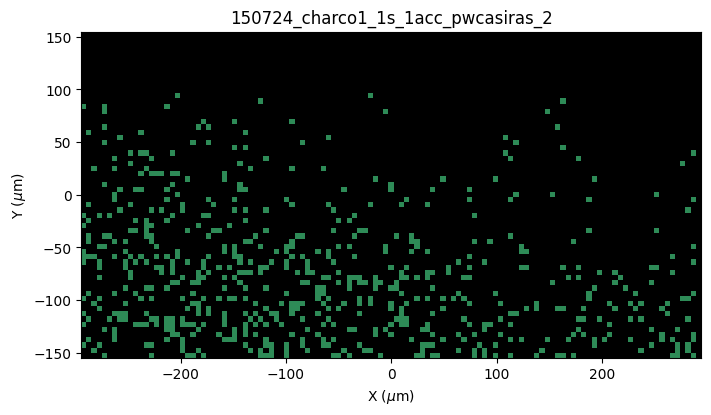


Procesando archivo: 150724_charco1_1s_1acc_pwcasiras_3
Válidos: 443, Outliers: 0


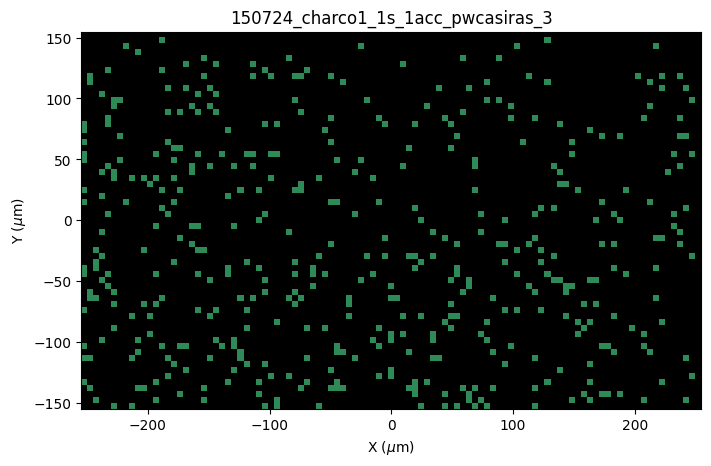


Procesando archivo: 150724_charco2_1s_1acc_pwcasiras
Válidos: 43, Outliers: 2
No se encontraron datos en infomapas para el archivo: 150724_charco2_1s_1acc_pwcasiras

Procesando archivo: 160724_charco2_1s_1acc_pwcasiras
Válidos: 35, Outliers: 0


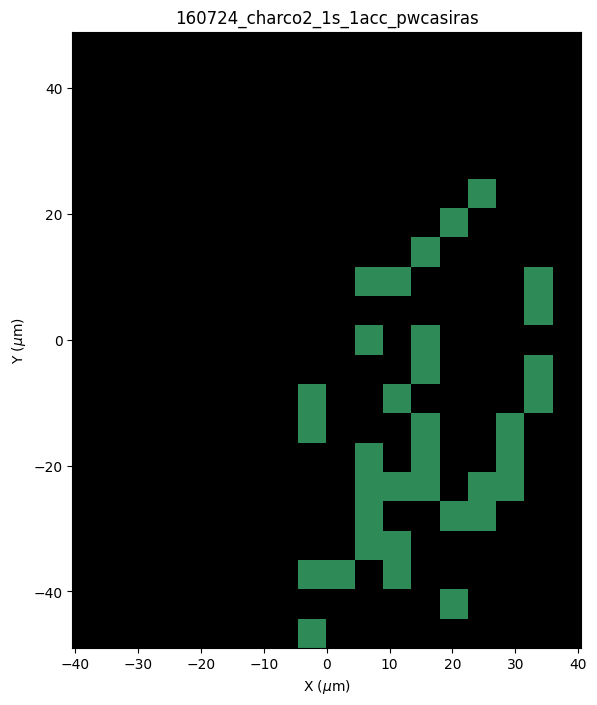


Procesando archivo: 160724_charco2_1s_1acc_pwcasiras_2
Válidos: 177, Outliers: 5


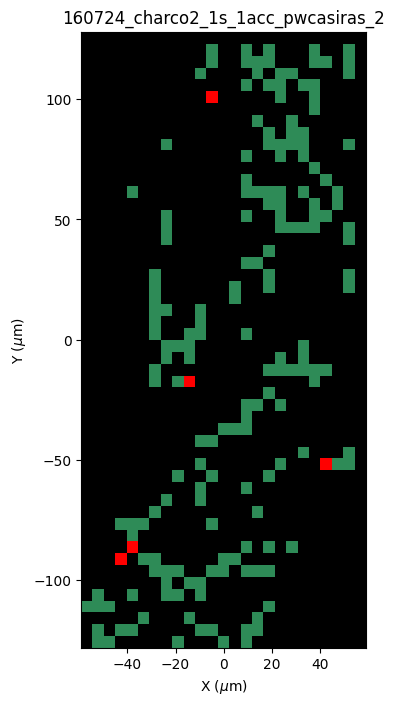


Procesando archivo: 160724_charco2_1s_1acc_pwcasiras_3
Válidos: 7, Outliers: 0


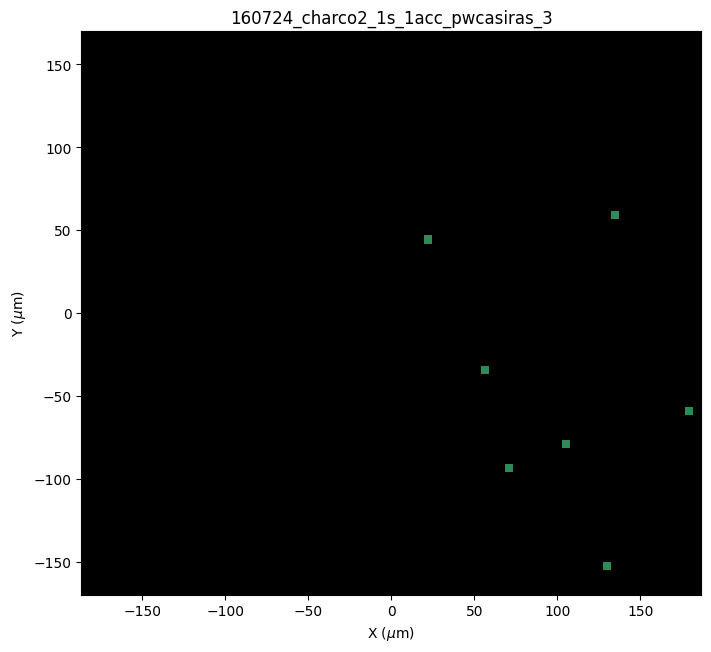


Procesando archivo: 170724_charco_500ms_1acc_pwcasiras_1
Válidos: 6, Outliers: 0


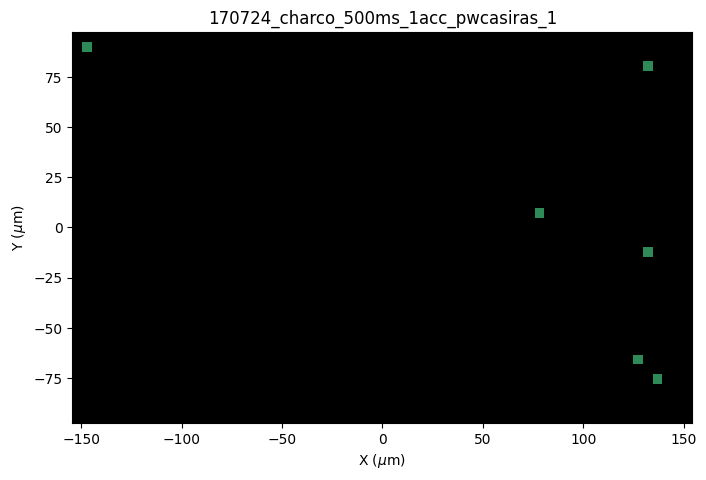


Procesando archivo: 170724_charco_700ms_1acc_pwcasiras_1
Válidos: 31, Outliers: 0


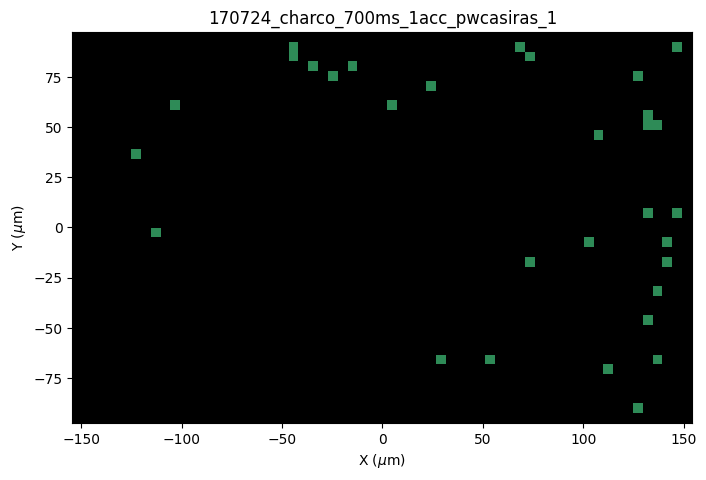


Procesando archivo: 170724_charco_700ms_1acc_pwcasiras_2
Válidos: 45, Outliers: 0


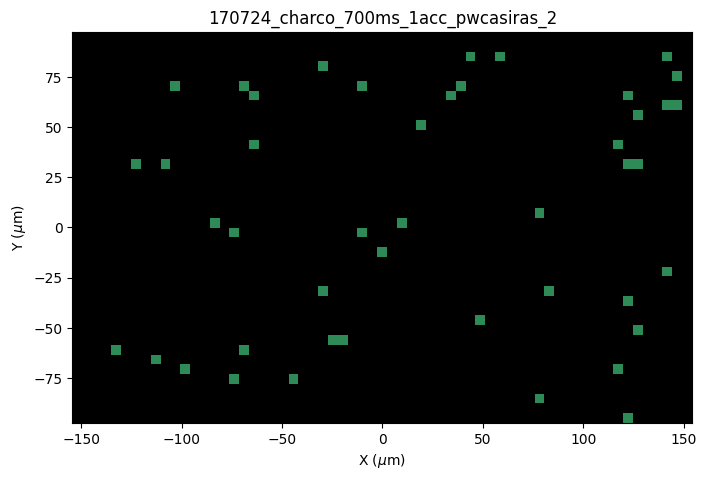


Procesando archivo: 180324_UAM588_300ms_1acc_pwras_20um
Válidos: 14, Outliers: 0


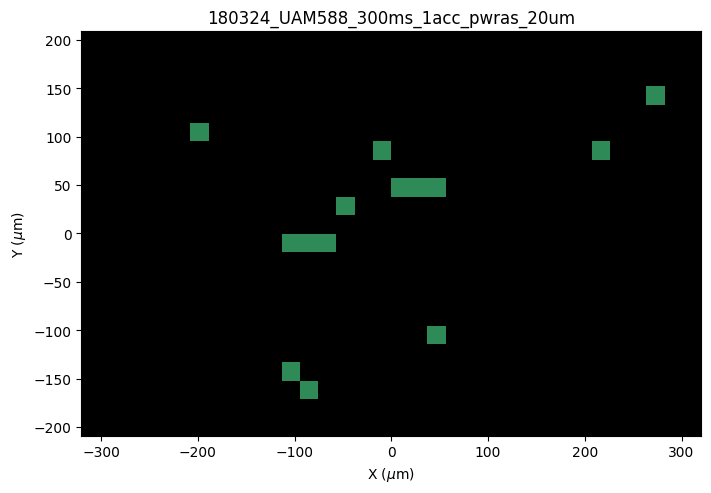


Procesando archivo: 180324_UAM588_300ms_1acc_pwras_5um
Válidos: 47, Outliers: 0


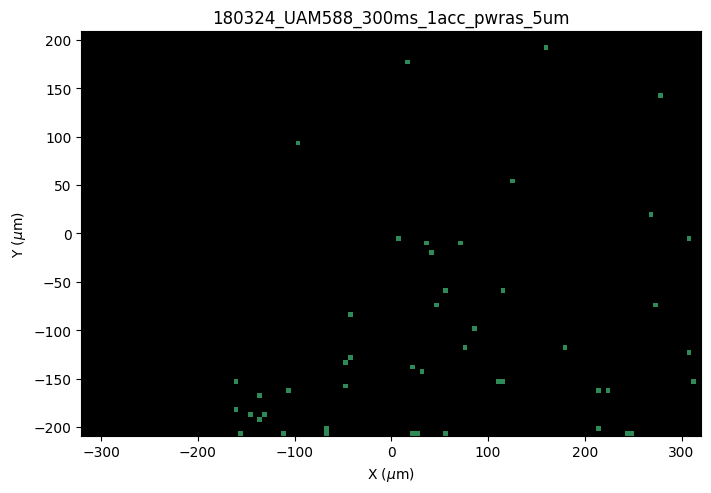


Procesando archivo: 180324_UAM588_300ms_1acc_pwras_7um
Válidos: 219, Outliers: 6


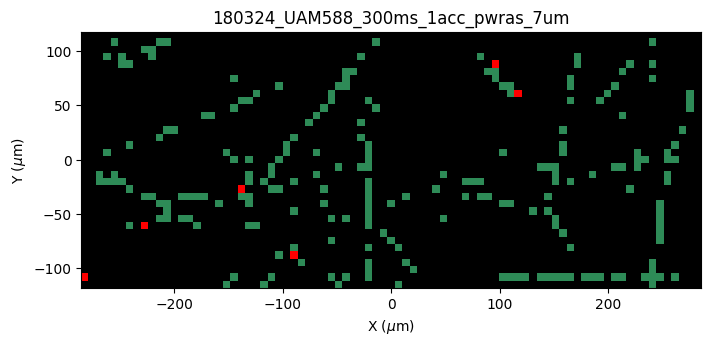


Procesando archivo: 180324_UAM588_300ms_1acc_pwras_7um_1
Válidos: 13, Outliers: 0


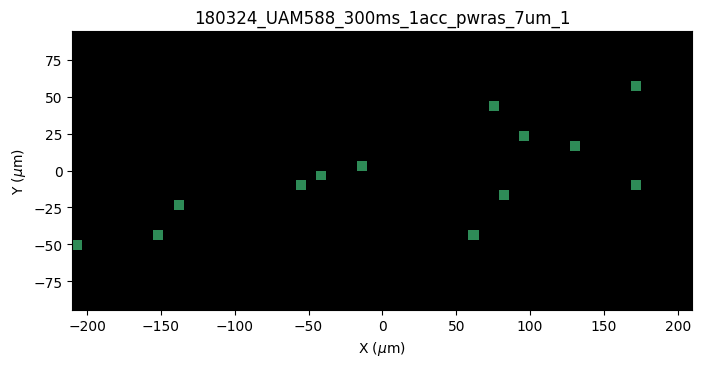


Procesando archivo: 180324_UAM588_500ms_1acc_pwmuesca1_7um_1
Válidos: 151, Outliers: 16


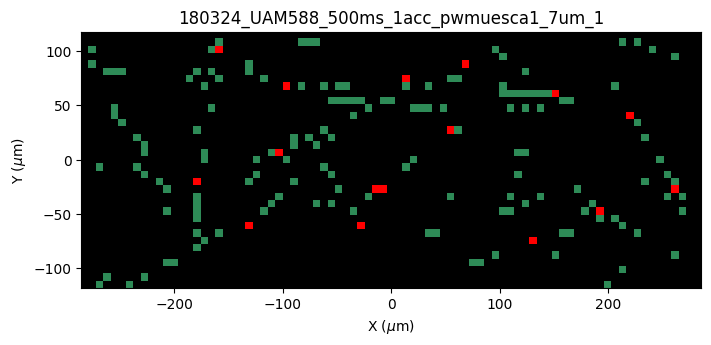


Procesando archivo: 180724_botella_500ms_1acc_pwcasiras_1
Válidos: 33, Outliers: 1


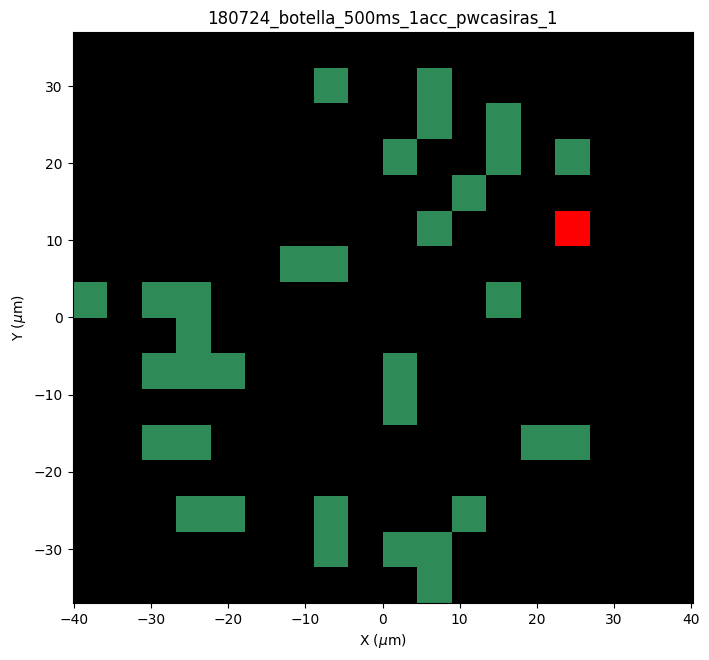


Procesando archivo: 180724_botella_500ms_1acc_pwcasiras_2
Válidos: 9, Outliers: 3


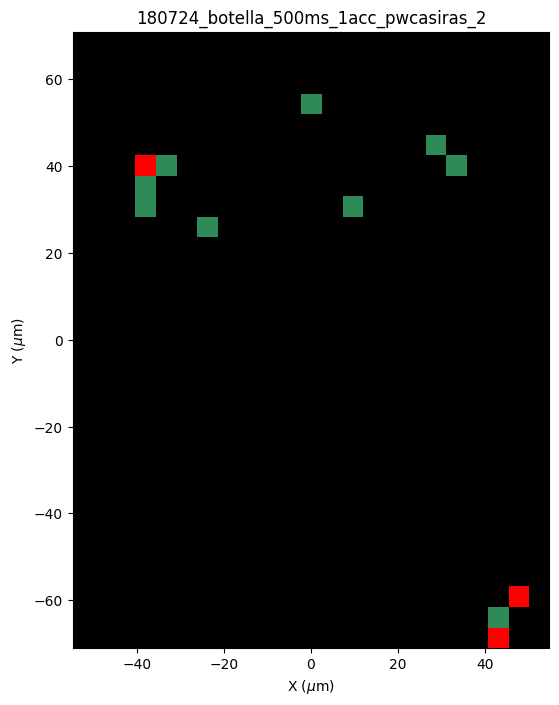


Procesando archivo: 180724_charco_1s_1acc_pwcasiras_1
Válidos: 274, Outliers: 0


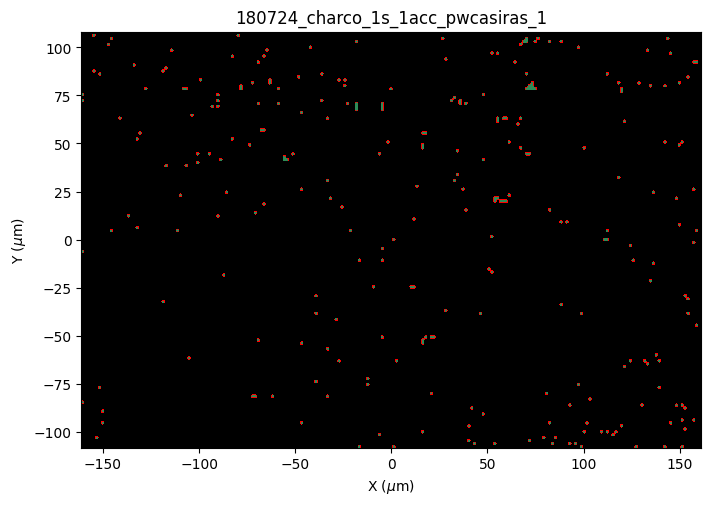


Procesando archivo: 190324_UAM588_300ms_1acc_pwras_6um
Válidos: 41, Outliers: 6


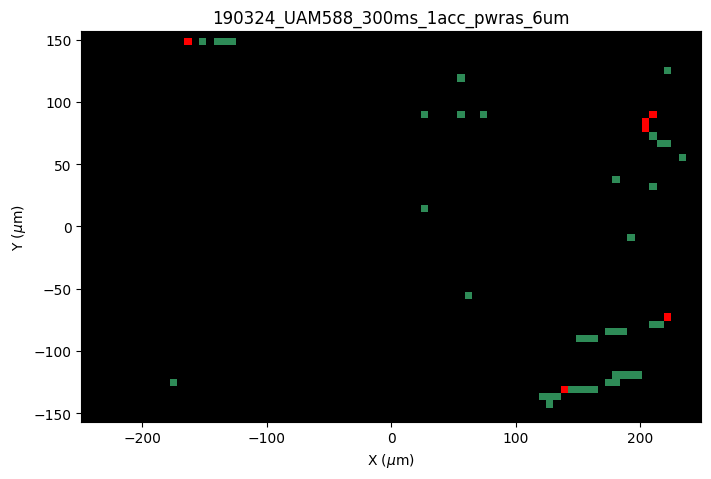


Procesando archivo: 190824_UAM565_500ms_1acc_pwcasiras1_5um_1
Válidos: 165, Outliers: 0


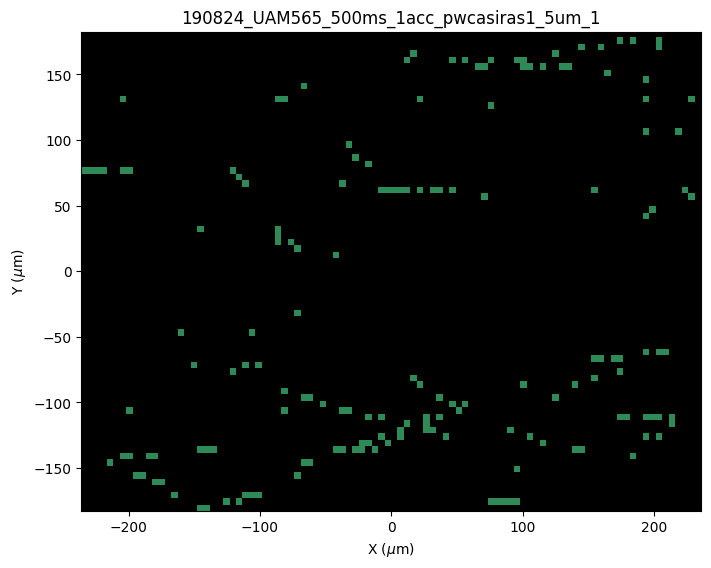


Procesando archivo: 190824_UAM565_500ms_1acc_pwcasiras1_5um_2
Válidos: 44, Outliers: 0


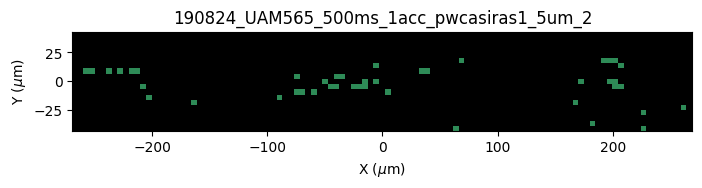


Procesando archivo: 190824_UAM565_500ms_1acc_pwcasiras1_5um_3
Válidos: 27, Outliers: 0


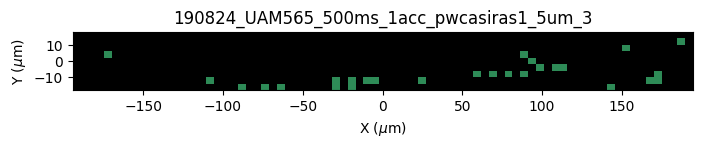


Procesando archivo: 190824_UAM565_500ms_1acc_pwcasiras1_5um_4
Válidos: 28, Outliers: 0


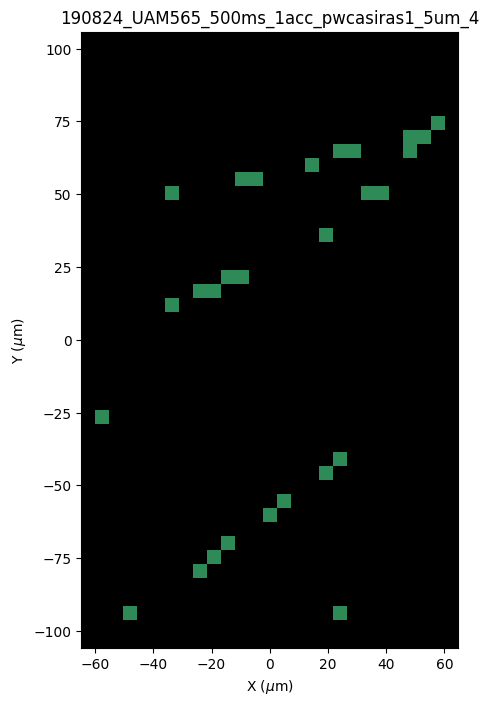


Procesando archivo: 190824_UAM565_500ms_1acc_pwcasiras1_5um_5
Válidos: 56, Outliers: 0


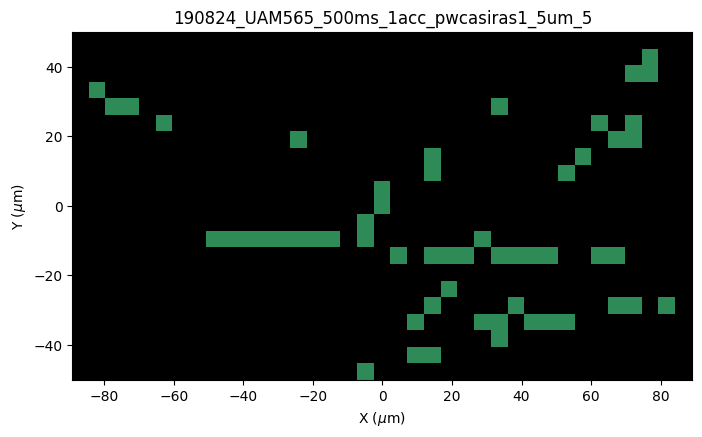


Procesando archivo: 190824_UAM565_500ms_1acc_pwcasiras1_5um_6_largo
Válidos: 102, Outliers: 5


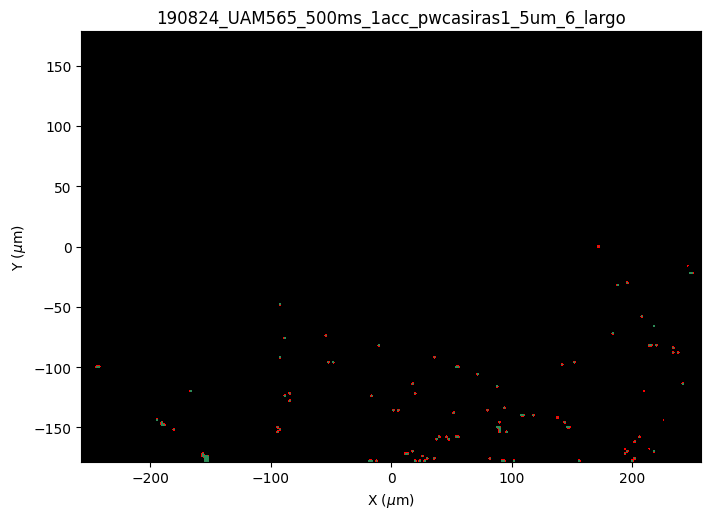


Procesando archivo: 220724_UAM588_500ms_pwcasiras_2um_7
Válidos: 781, Outliers: 70


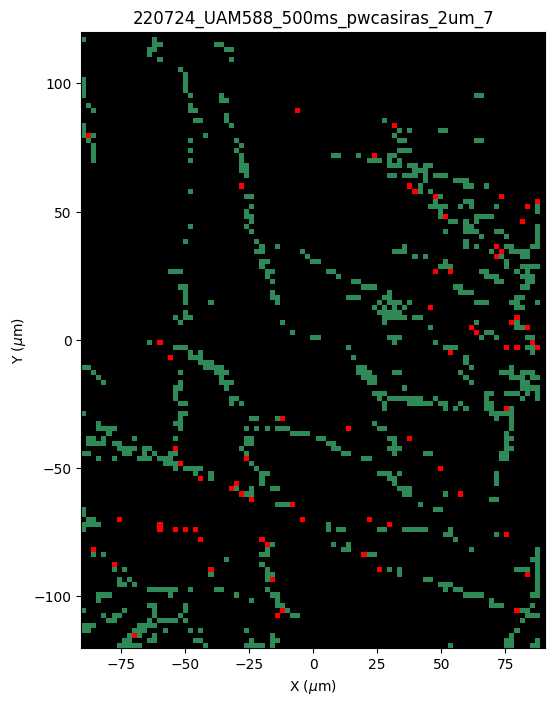


Procesando archivo: 220724_UAM588_500ms_pwcasiras_2um_8
Válidos: 2027, Outliers: 372


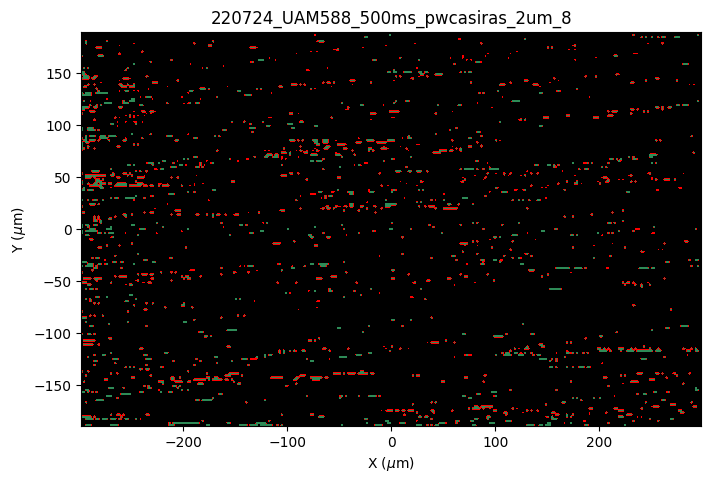


Procesando archivo: 220724_UAM588_500ms_pwras_2um_2
Válidos: 271, Outliers: 11


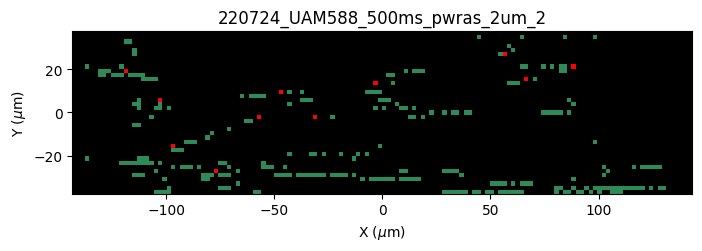


Procesando archivo: 220724_UAM588_500ms_pwras_2um_3
Válidos: 336, Outliers: 22


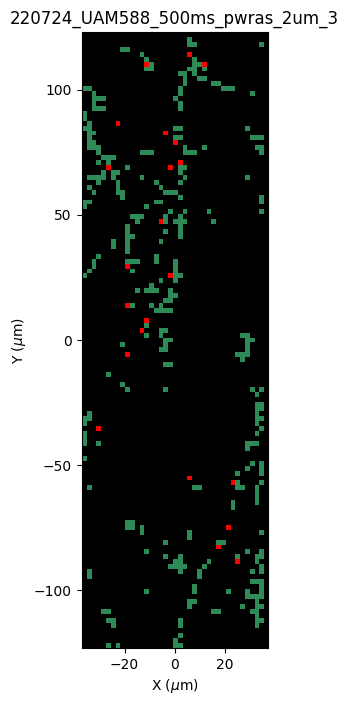


Procesando archivo: 220724_UAM588_500ms_pwras_2um_4
Válidos: 418, Outliers: 50


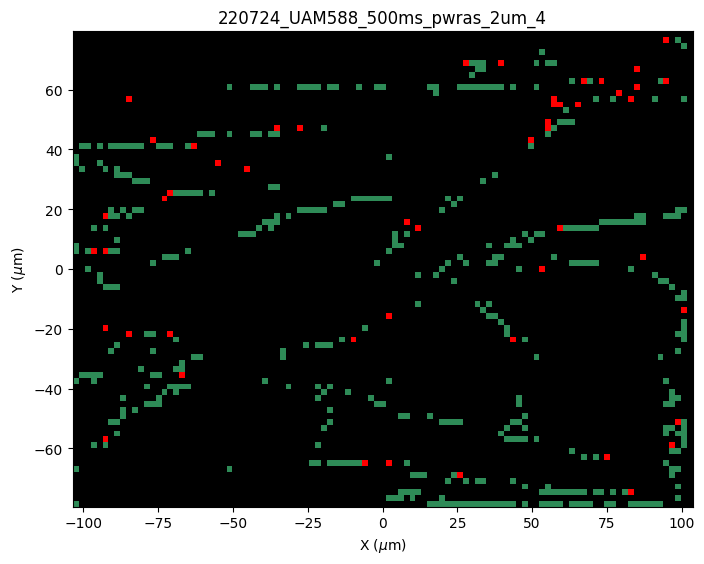


Procesando archivo: 220724_UAM588_500ms_pwras_2um_5
Válidos: 266, Outliers: 39


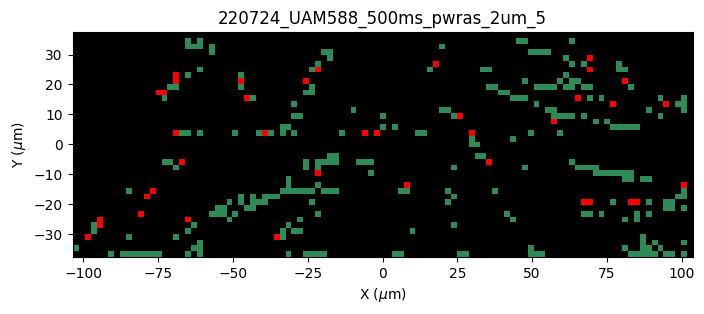


Procesando archivo: 220724_UAM588_500ms_pwras_2um_6
Válidos: 237, Outliers: 34


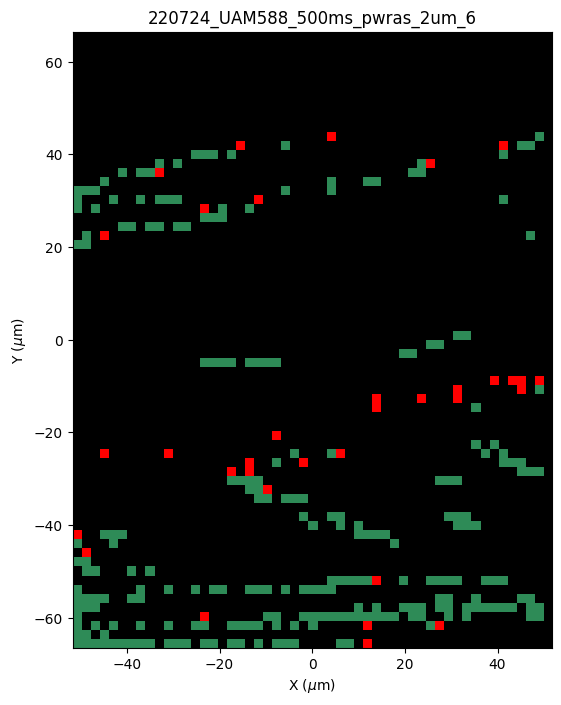


Procesando archivo: 220724_UAM588_700ms_pwras_2um
Válidos: 587, Outliers: 62


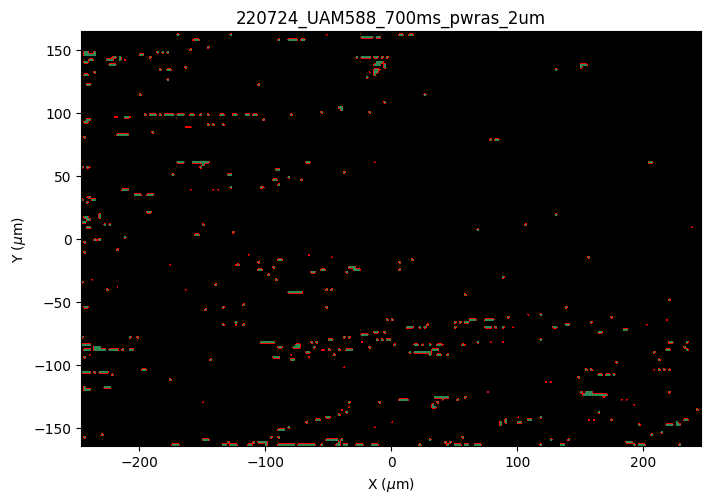


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2
Válidos: 79, Outliers: 0


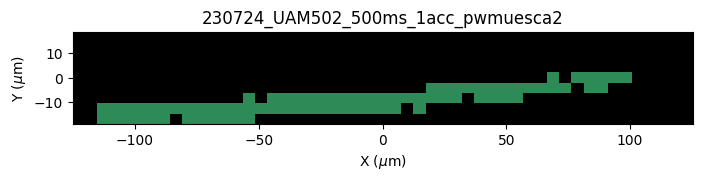


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_10
Válidos: 70, Outliers: 0


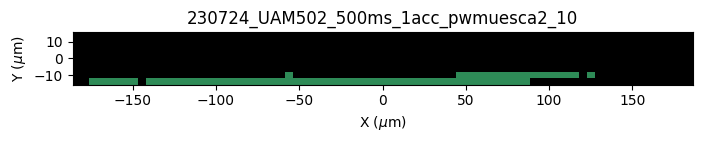


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_11
Válidos: 131, Outliers: 0


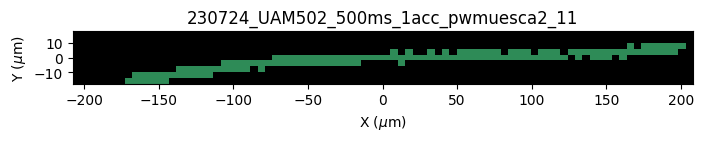


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_12
Válidos: 64, Outliers: 0


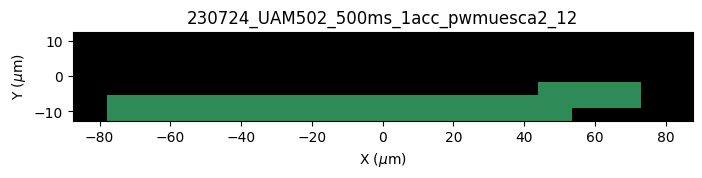


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_13
Válidos: 11, Outliers: 3


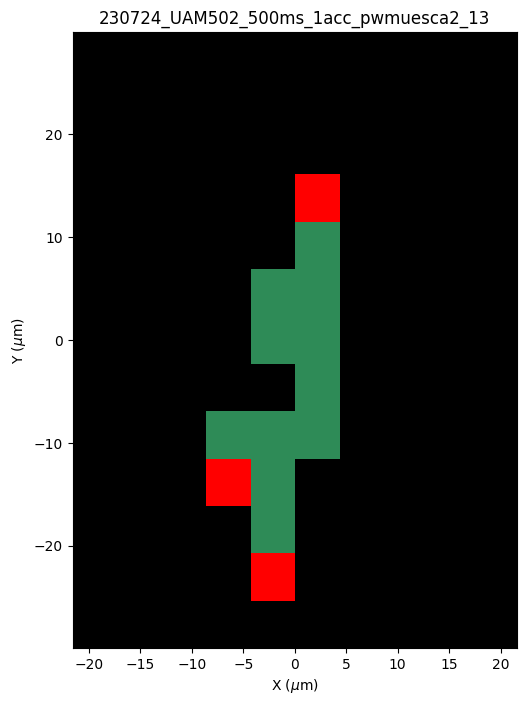


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_14
Válidos: 28, Outliers: 0


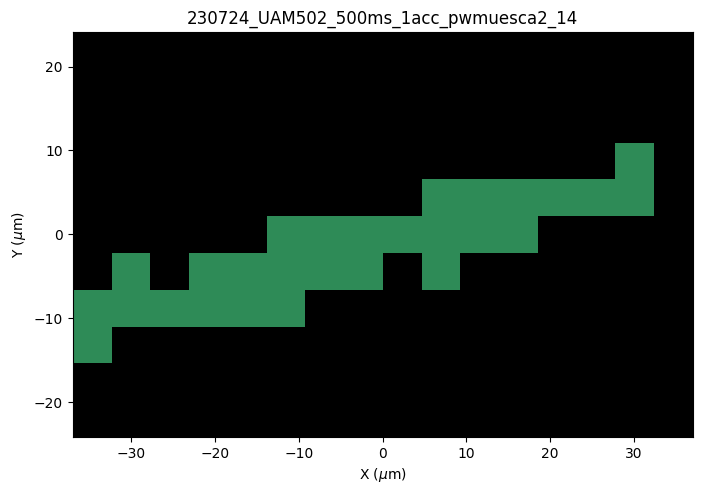


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_15
Válidos: 10, Outliers: 0


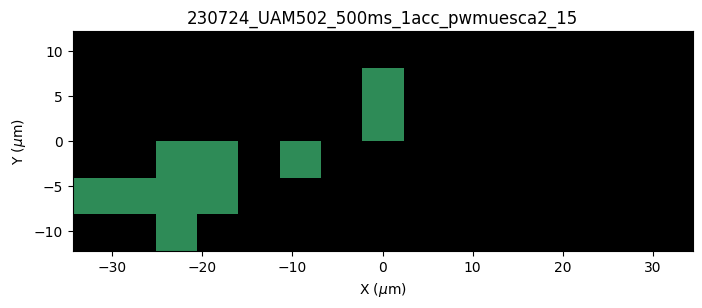


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_16
Válidos: 6, Outliers: 1


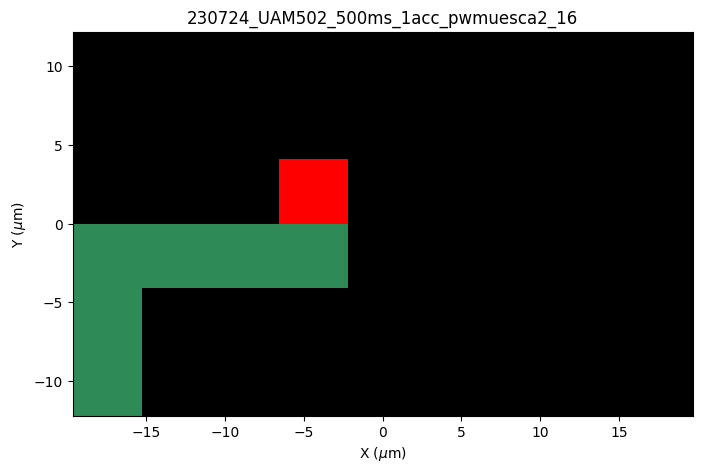


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_17
Válidos: 41, Outliers: 0


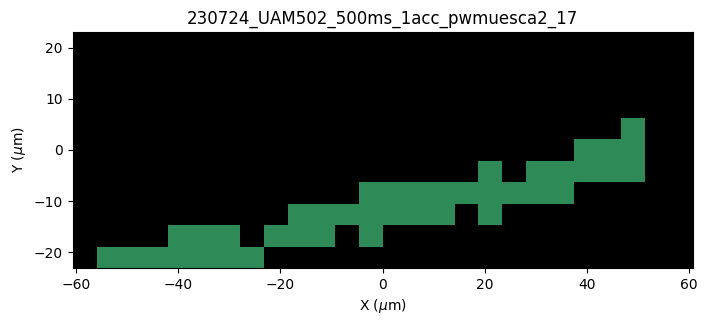


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_18
Válidos: 58, Outliers: 0


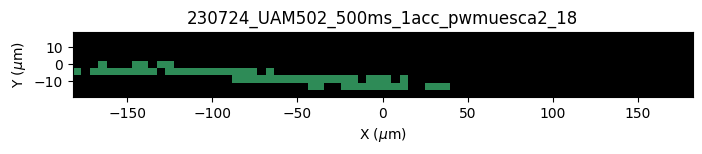


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_19
Válidos: 52, Outliers: 0


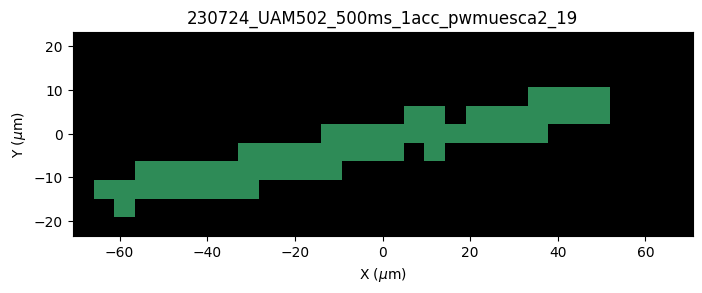


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_2
Válidos: 78, Outliers: 0


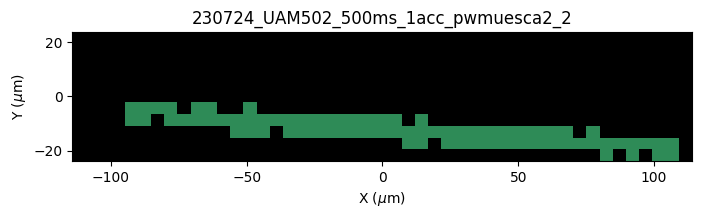


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_20
Válidos: 17, Outliers: 0


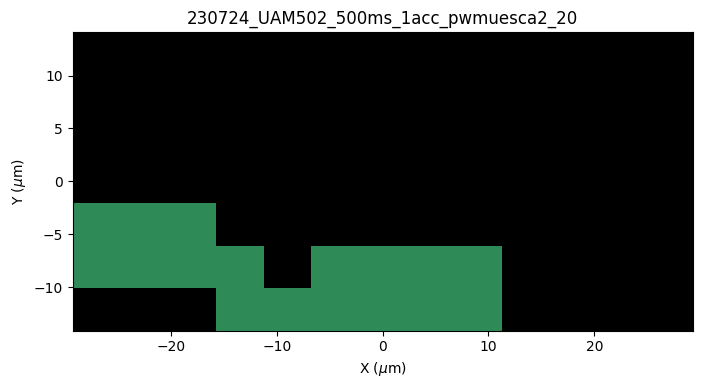


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_21
Válidos: 23, Outliers: 0


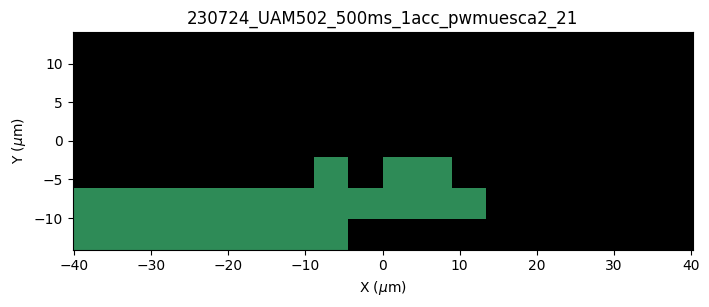


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_22
Válidos: 32, Outliers: 0


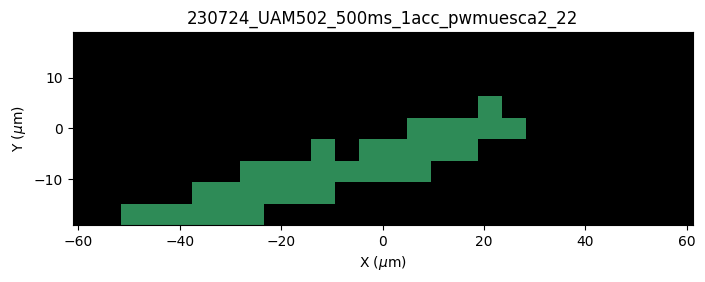


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_23
Válidos: 19, Outliers: 0


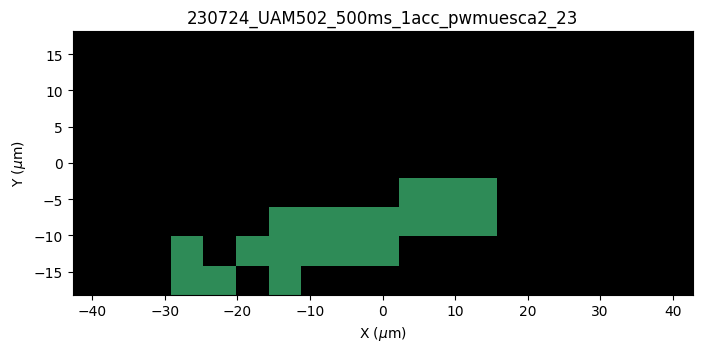


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_24
Válidos: 242, Outliers: 1


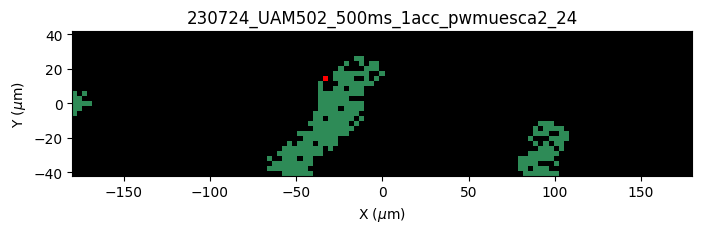


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_25
Válidos: 203, Outliers: 1


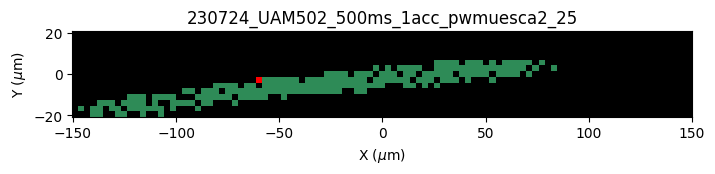


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_26
Válidos: 33, Outliers: 0


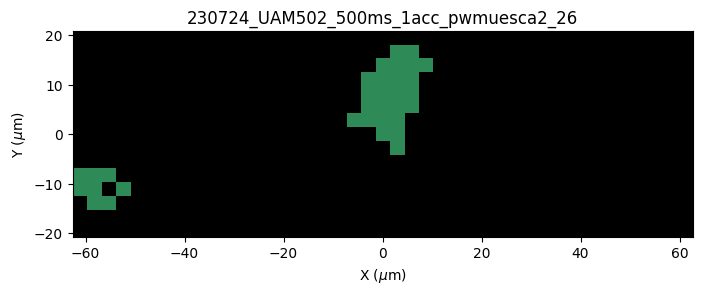


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_27
Válidos: 203, Outliers: 1


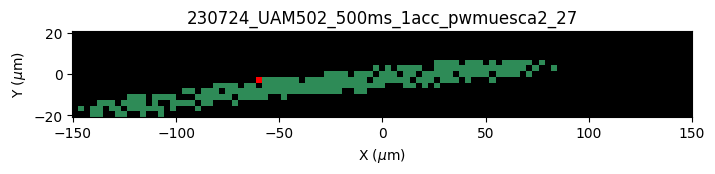


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_28
Válidos: 196, Outliers: 3


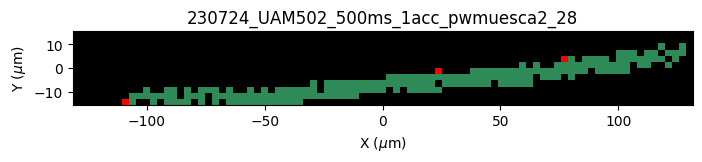


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_29
Válidos: 114, Outliers: 0


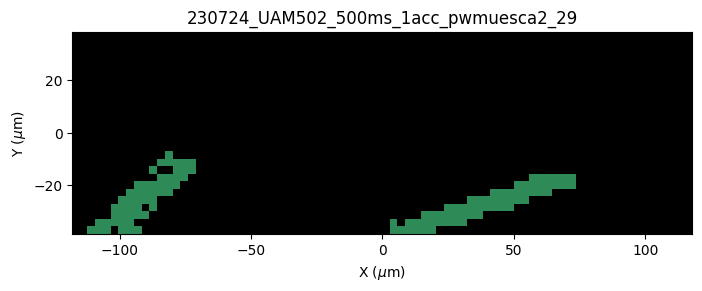


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_3
Válidos: 41, Outliers: 0


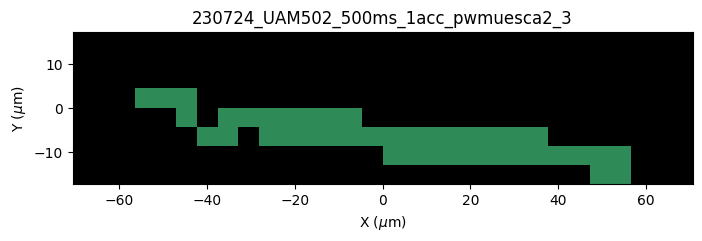


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_4
Válidos: 56, Outliers: 0


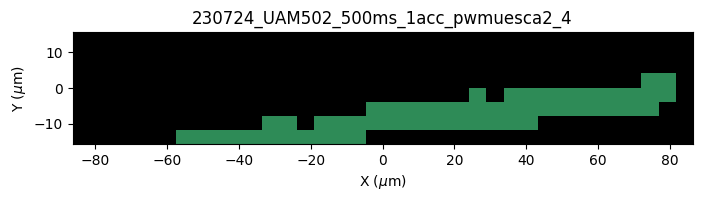


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_5
Válidos: 14, Outliers: 0


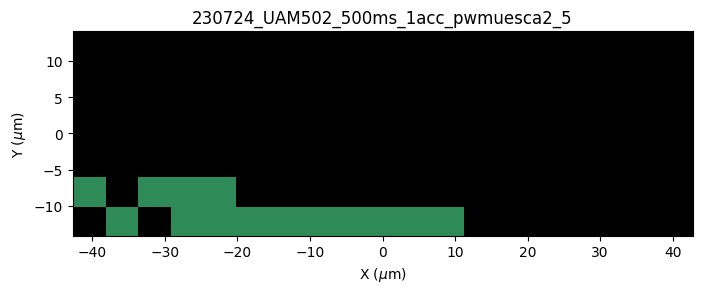


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_6
Válidos: 8, Outliers: 0


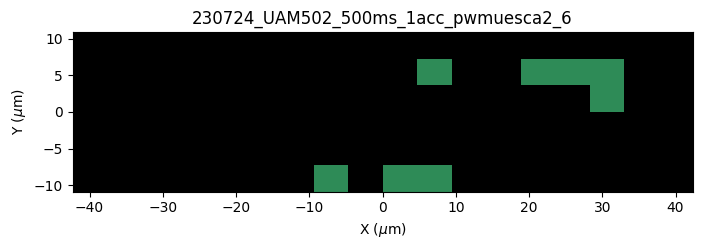


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_7
Válidos: 9, Outliers: 0


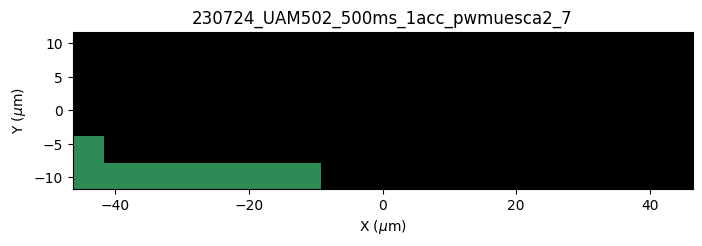


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_8
Válidos: 573, Outliers: 4


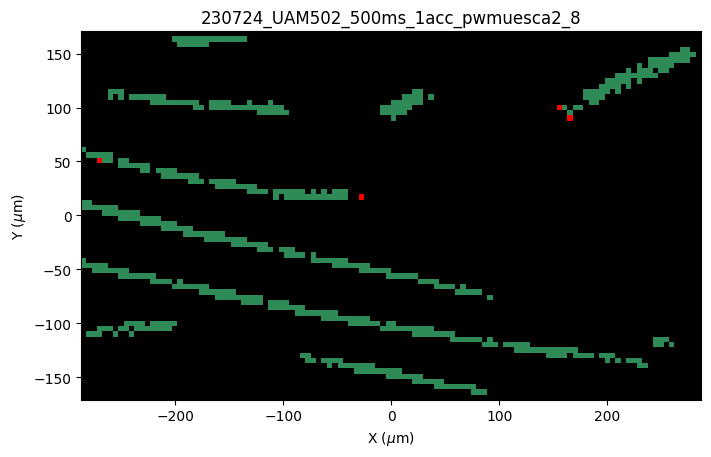


Procesando archivo: 230724_UAM502_500ms_1acc_pwmuesca2_9
Válidos: 181, Outliers: 2


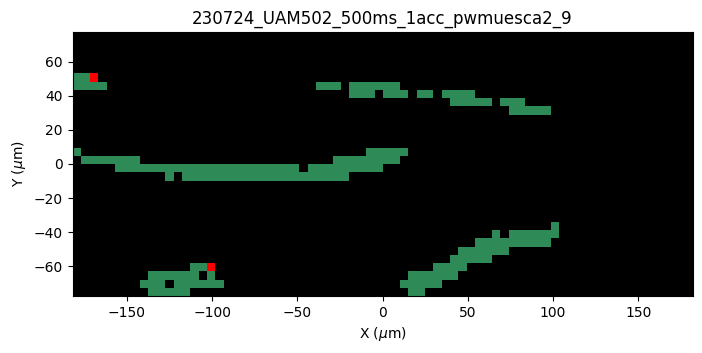


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_30
Válidos: 953, Outliers: 149


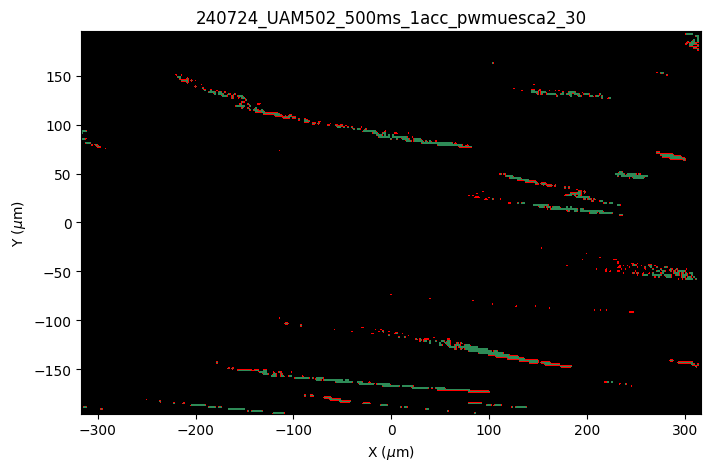


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_31
Válidos: 34, Outliers: 2


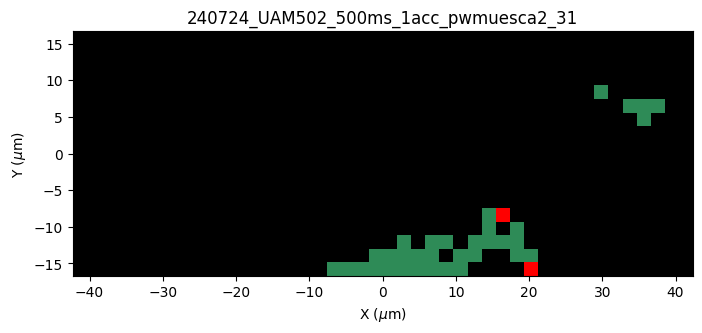


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_32
Válidos: 1, Outliers: 0


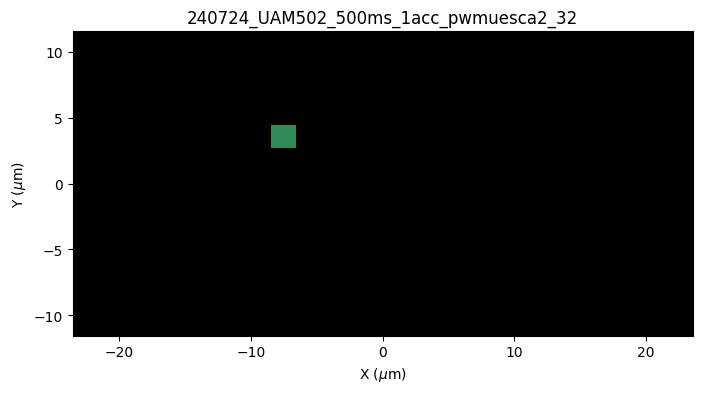


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_33
Válidos: 364, Outliers: 5


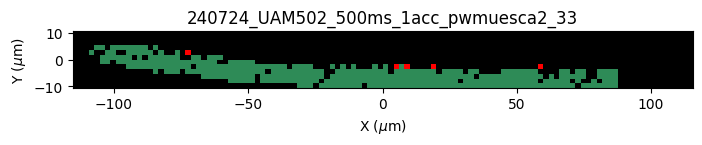


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_34
Válidos: 14, Outliers: 0


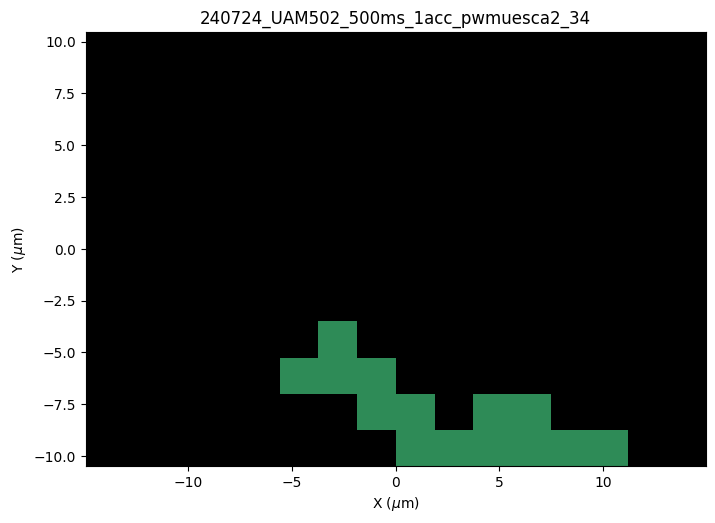


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_35
Válidos: 2, Outliers: 0


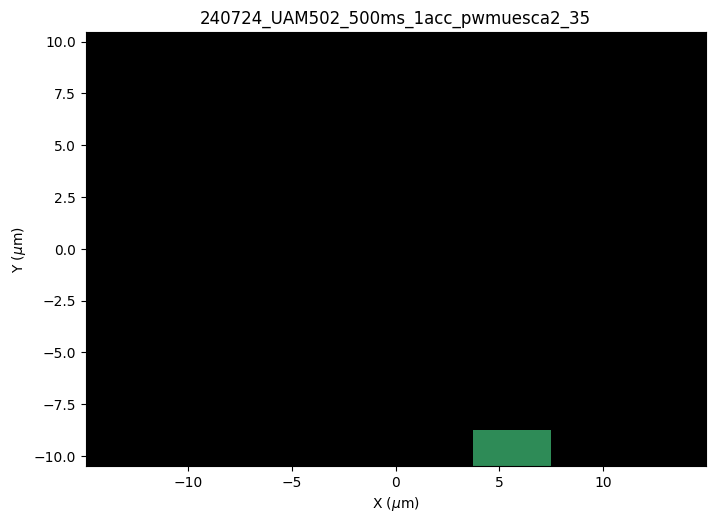


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_36
Válidos: 117, Outliers: 1


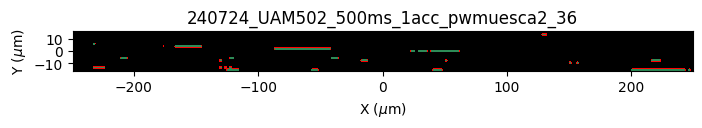


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_37
Válidos: 228, Outliers: 0


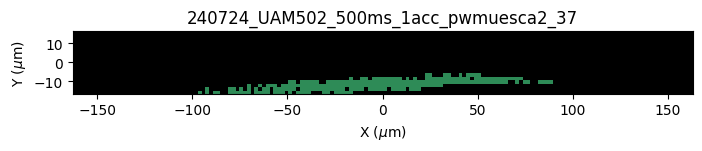


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_38
Válidos: 966, Outliers: 3


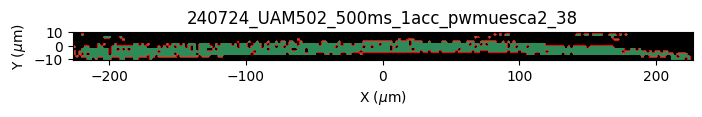


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_39
Válidos: 192, Outliers: 2


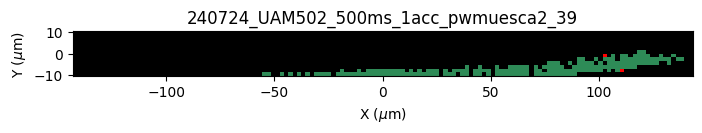


Procesando archivo: 240724_UAM502_500ms_1acc_pwmuesca2_40
Válidos: 243, Outliers: 0


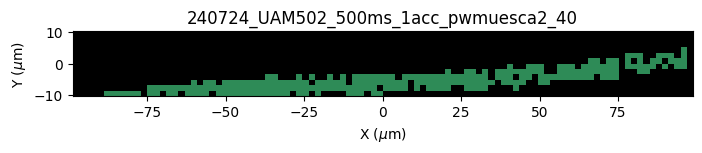


Procesando archivo: 310524_UAM502_1s_1acc_pwmuescaentre1y2_5um_14
Válidos: 230, Outliers: 72


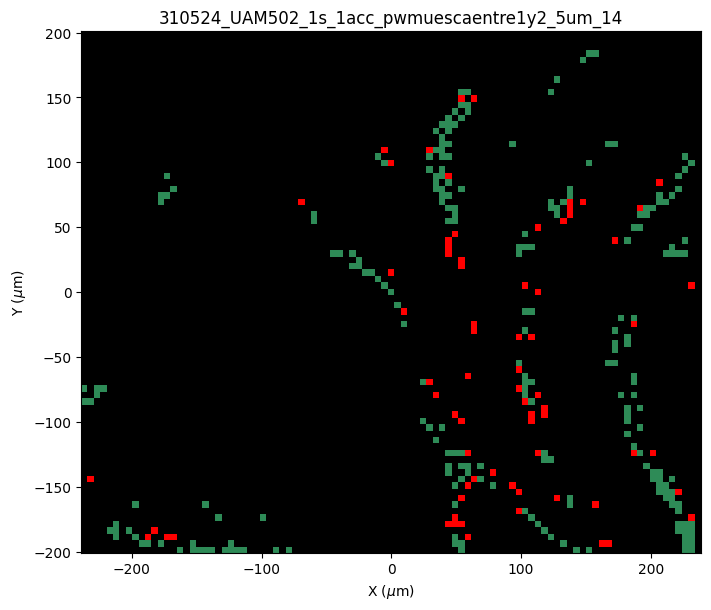


Procesando archivo: 310524_UAM502_1s_1acc_pwmuescaentre1y2_5um_15
Válidos: 96, Outliers: 12


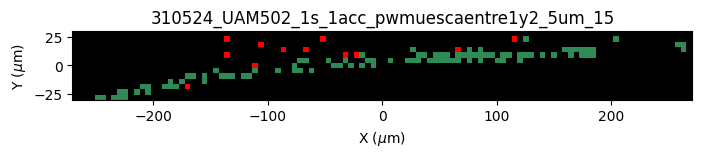


Procesando archivo: 310524_UAM502_1s_1acc_pwmuescaentre1y2_5um_16
Válidos: 170, Outliers: 1


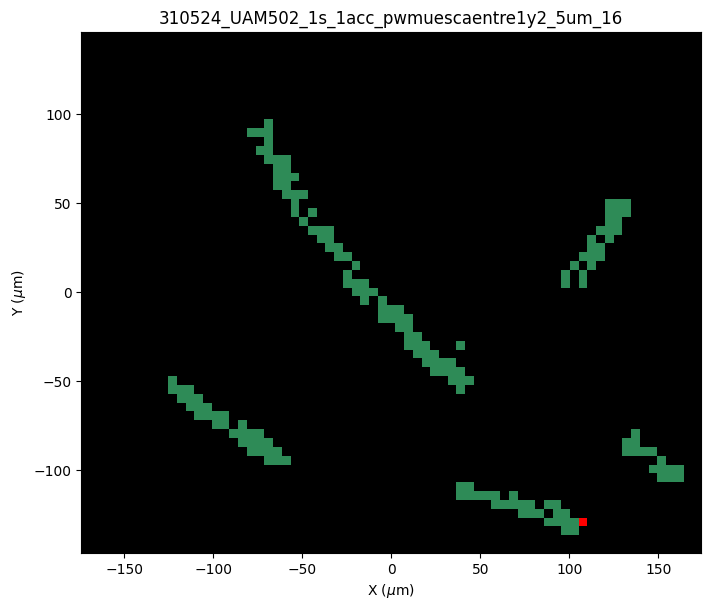


Procesando archivo: 310524_UAM502_300ms_1acc_pwras_5um_1
Válidos: 34, Outliers: 9


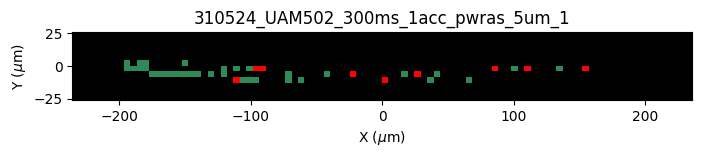


Procesando archivo: 310524_UAM502_300ms_1acc_pwras_5um_2
Válidos: 30, Outliers: 15


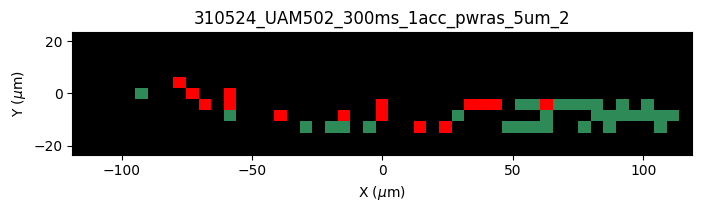


Procesando archivo: 310524_UAM502_300ms_1acc_pwras_5um_3
Válidos: 63, Outliers: 0


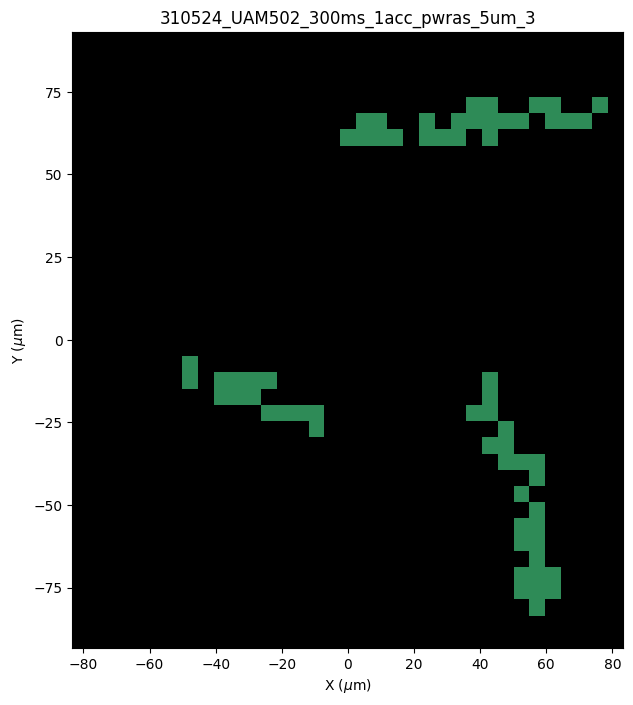


Procesando archivo: 310524_UAM502_300ms_1acc_pwras_5um_4
Válidos: 192, Outliers: 62


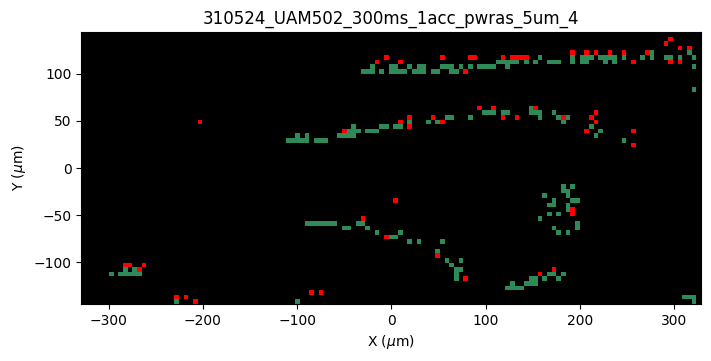


Procesando archivo: 310524_UAM502_300ms_1acc_pwras_5um_5
Válidos: 171, Outliers: 14


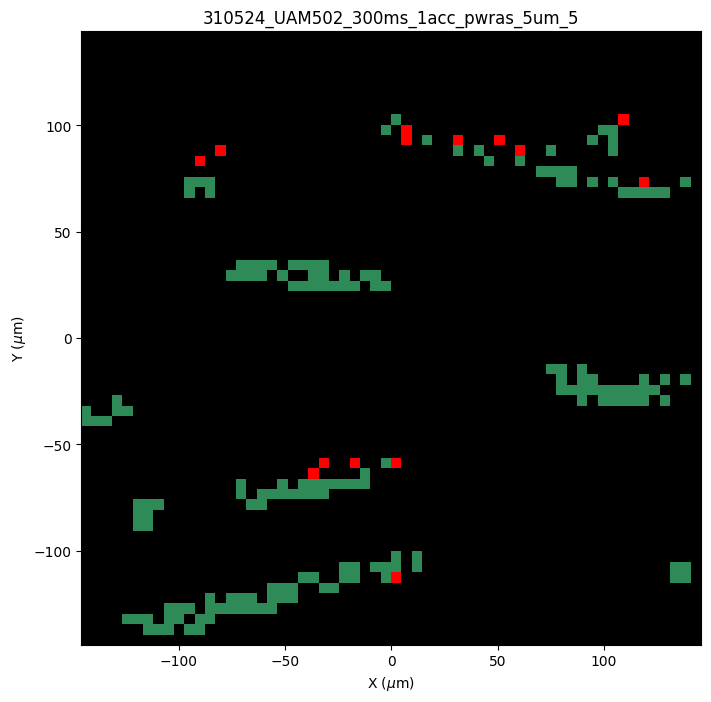


Procesando archivo: 310524_UAM502_500ms_1acc_pwcasi1_5um_6
Válidos: 68, Outliers: 16


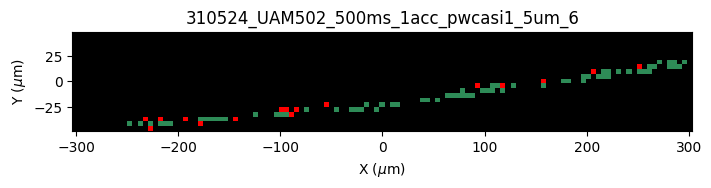


Procesando archivo: 310524_UAM502_500ms_1acc_pwmuescacasi1_5um_10
Válidos: 309, Outliers: 36


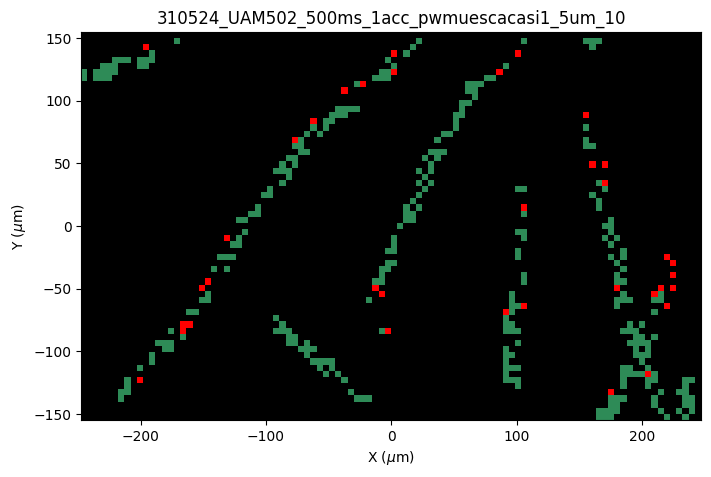


Procesando archivo: 310524_UAM502_500ms_1acc_pwmuescacasi1_5um_11
Válidos: 394, Outliers: 39


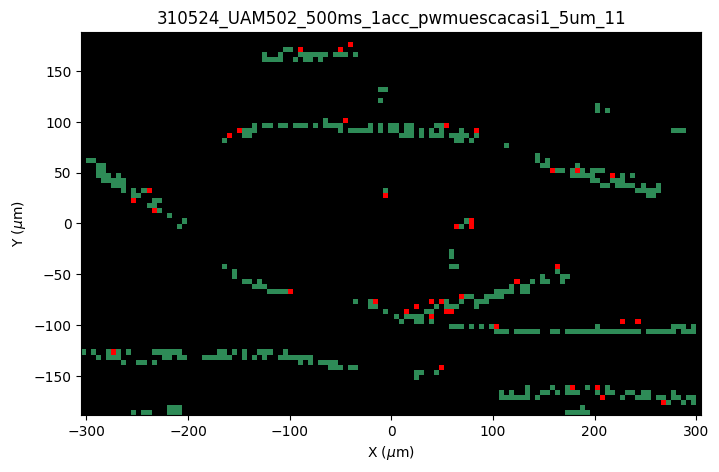


Procesando archivo: 310524_UAM502_500ms_1acc_pwmuescacasi1_5um_12
Válidos: 236, Outliers: 50


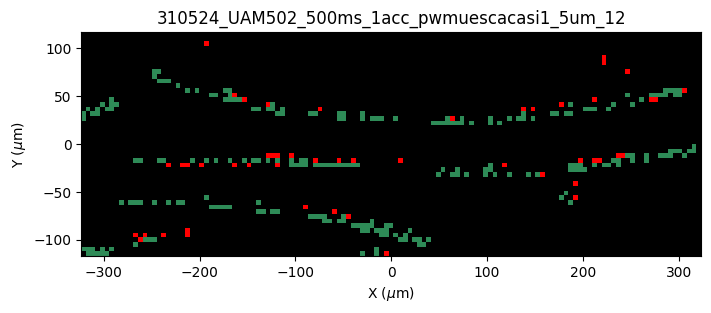


Procesando archivo: 310524_UAM502_500ms_1acc_pwmuescacasi1_5um_13
Válidos: 373, Outliers: 52


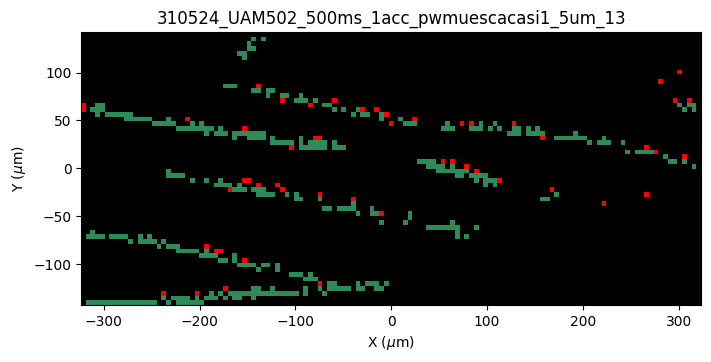


Procesando archivo: 310524_UAM502_500ms_1acc_pwmuescacasi1_5um_7
Válidos: 378, Outliers: 40


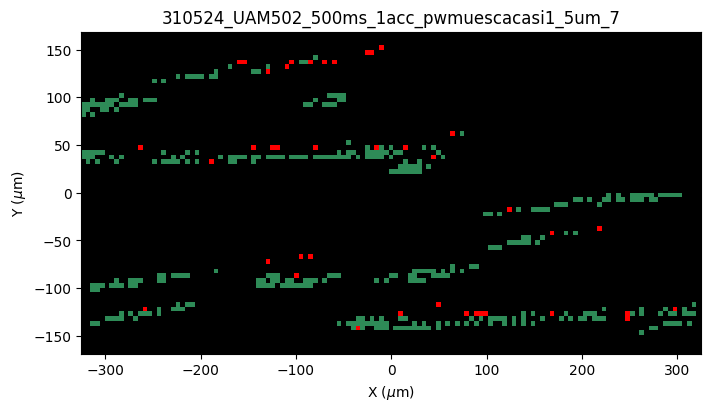


Procesando archivo: 310524_UAM502_500ms_1acc_pwmuescacasi1_5um_8
Válidos: 288, Outliers: 20


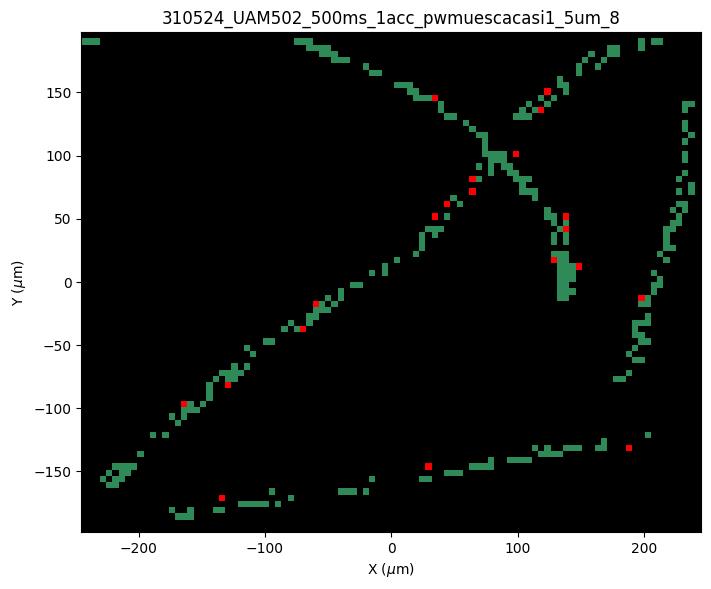


Procesando archivo: 310524_UAM502_500ms_1acc_pwmuescacasi1_5um_9
Válidos: 315, Outliers: 19


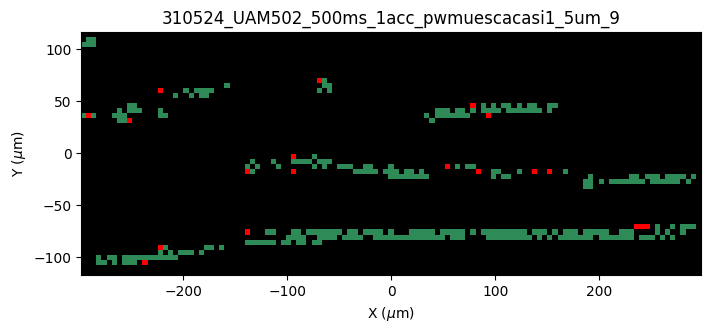

In [ ]:

def plot_coordinate_map(group, outliers_indices, df_infomapas, name, custom_cmap):
    """
    Plot a coordinate map based on X and Y values, highlighting outliers.

    Args:
        group (DataFrame): DataFrame containing the group of spectra to plot.
        outliers_indices (list or array): Indices of rows considered as outliers.
        df_infomapas (DataFrame): DataFrame with mapping information including coordinate limits and step sizes.
        name (str): The name or identifier of the file being processed.
        custom_cmap (ListedColormap): Custom colormap for visualizing valid points and outliers.

    Returns:
        None
    """
    # Coordinate map based on the `infomapas` file
    group_infomapas = df_infomapas[df_infomapas['filename'] == name]

    if group_infomapas.empty:
        print(f"No data found in `infomapas` for the file: {name}")
        return

    # Retrieve coordinate limits and step sizes
    X_min = group_infomapas['X_min'].values[0]
    X_max = group_infomapas['X_max'].values[0]
    Y_min = group_infomapas['Y_min'].values[0]
    Y_max = group_infomapas['Y_max'].values[0]
    X_step = group_infomapas['X_step'].values[0]
    Y_step = group_infomapas['Y_step'].values[0]

    # Create a map matrix with known limits and steps
    x_range = np.arange(X_min, X_max + X_step, X_step)
    y_range = np.arange(Y_min, Y_max + Y_step, Y_step)
    mapa = np.full((len(y_range), len(x_range)), -1)  # Initialize the map with black (-1 for missing)

    # Plot the group coordinates on the map
    for index, row in group.iterrows():
        x_coord = row['X']
        y_coord = row['Y']

        # Determine if the index is an outlier
        is_outlier = index in outliers_indices

        # Find positions in the map
        x_idx = np.argmin(np.abs(x_range - x_coord))
        y_idx = np.argmin(np.abs(y_range - y_coord))

        # Assign color: 1 for green (valid), 0 for red (outlier)
        mapa[y_idx, x_idx] = 0 if is_outlier else 1  # Red for outlier, green for valid

    # Plot the map
    plt.figure(figsize=(8, 8))
    plt.imshow(mapa, cmap=custom_cmap, origin='lower', extent=[X_min, X_max, Y_min, Y_max])
    plt.title(f"{name}", fontsize=14)
    plt.xlabel("X ($\\mu$m)", fontsize=12)
    plt.ylabel("Y ($\\mu$m)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Load the infomapas file
ruta_infomapas = r'C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\infomapas.CSV'
df_infomapas = pd.read_csv(ruta_infomapas)

# Custom colormap: black (-1), green (1), red (0)
custom_cmap = ListedColormap(['black', 'red', 'seagreen'])

def process_spectra_and_plot_maps(df_corrected, outliers_indices, df_infomapas, process_title):
    """
    Process a dataset of Raman spectra and plot coordinate maps for each file.

    Args:
        df_corrected (DataFrame): DataFrame containing corrected spectra data.
        outliers_indices (list or array): Indices of rows considered as outliers.
        df_infomapas (DataFrame): DataFrame with mapping information including coordinate limits and step sizes.
        process_title (str): Title describing the dataset being processed (e.g., "Trainval", "Test").

    Returns:
        None
    """
    # Group by 'name' to generate plots and calculate averages per file
    grouped_by_name = df_corrected.groupby('name')

    for name, group in grouped_by_name:
        # Count valid and discarded spectra
        valid_spectra_count = len(group) - sum(group.index.isin(outliers_indices))
        outliers_count = sum(group.index.isin(outliers_indices))

        # Print processing information
        print(f"\nProcessing file: {name}")
        print(f"Valid: {valid_spectra_count}, Outliers: {outliers_count}")
        
        # Generate the coordinate map
        plot_coordinate_map(group, outliers_indices, df_infomapas, name, custom_cmap)

# Call the processing function for trainval and test datasets
process_spectra_and_plot_maps(df, outliers_indices_trainval, df_infomapas, "Trainval")


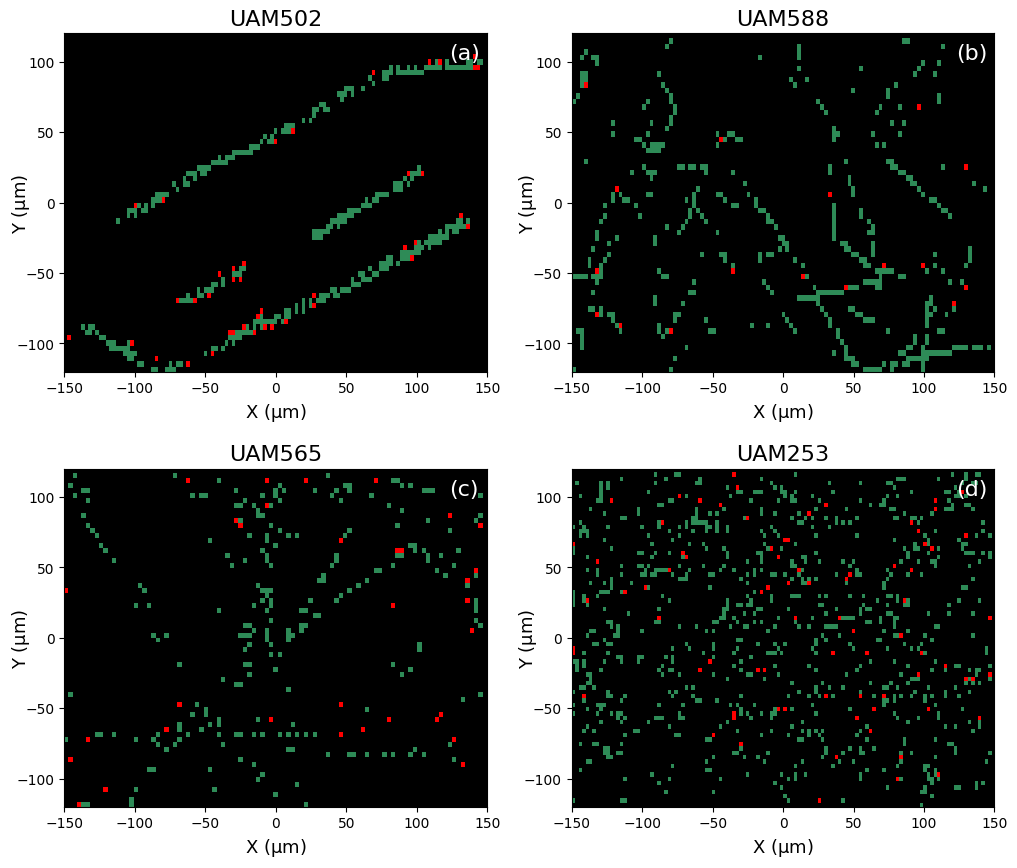

In [ ]:
def plot_coordinate_map_subplots_2x2(df_corrected, outliers_indices, df_infomapas, names, custom_cmap):
    # Set up 2x2 subplots with customized spacing
    fig, axes = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': 0.2, 'hspace': -0.11})
    axes = axes.flatten() 

    # List of titles and subplot labels
    titles = ['UAM502', 'UAM588', 'UAM565', 'UAM253']
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']  # Labels for the subplots

    for i, name in enumerate(names):
        # Filter the DataFrame for the current name
        group = df_corrected[df_corrected['name'] == name]
        group_infomapas = df_infomapas[df_infomapas['filename'] == name]

        if group.empty or group_infomapas.empty:
            print(f"No data for the file: {name}")
            axes[i].set_title(f"{name} (No data)")
            axes[i].axis('off')
            continue

        # Extract limits and steps from the infomapas file
        X_min = group_infomapas['X_min'].values[0]
        X_max = group_infomapas['X_max'].values[0]
        Y_min = group_infomapas['Y_min'].values[0]
        Y_max = group_infomapas['Y_max'].values[0]
        X_step = group_infomapas['X_step'].values[0]
        Y_step = group_infomapas['Y_step'].values[0]

        # Create a matrix for the map
        x_range = np.arange(X_min, X_max + X_step, X_step)
        y_range = np.arange(Y_min, Y_max + Y_step, Y_step)
        mapa = np.full((len(y_range), len(x_range)), -1)  # Initialize the map

        # Fill the map with values
        for index, row in group.iterrows():
            x_coord = row['X']
            y_coord = row['Y']
            is_outlier = index in outliers_indices

            # Coordinates in the map
            x_idx = np.argmin(np.abs(x_range - x_coord))
            y_idx = np.argmin(np.abs(y_range - y_coord))

            # Assign values: 0 (outlier), 1 (valid)
            mapa[y_idx, x_idx] = 0 if is_outlier else 1

        ax = axes[i]
        im = ax.imshow(mapa, cmap=custom_cmap, origin='lower', extent=[-150, 150, -120, 120])
        ax.set_title(f"{titles[i]}", fontsize=16)
        ax.set_xlabel("X ($\\mathrm{\\mu}$m)", fontsize=13, labelpad=4)
        ax.set_ylabel("Y ($\\mathrm{\\mu}$m)", fontsize=13, labelpad=-11)
        ax.text(0.91, 0.97, subplot_labels[i], transform=ax.transAxes, fontsize=16, verticalalignment='top', color='white')

    # Disable empty subplots if there are fewer than 4 names
    for j in range(len(names), len(axes)):
        axes[j].axis('off')

    # plt.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figS3\\figS3_outlierRamanImages.svg', format='svg', bbox_inches='tight', dpi=300)
    # plt.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figS3\\figS3_outlierRamanImages.png', format='png', bbox_inches='tight', dpi=300)
    plt.show()

# Custom colormap configuration
custom_cmap = ListedColormap(['black', 'red', 'seagreen'])

# List of names to plot
names_to_plot = [
    '100724_UAM502_500ms_1acc_pwmuesca1',
    '091024_UAM588_500ms_1acc_pwras_1',
    '090824_UAM565_700ms_1acc_pwmuescacasi1_5um_2',
    '110624_UAM253_1s_1acc_pwmuesca1_5um_1'
]

plot_coordinate_map_subplots_2x2(df, outliers_indices_test, df_infomapas, names_to_plot, custom_cmap)